# Fraud detection
This dataset comes from a [Kaggle competition](https://www.kaggle.com/c/ieee-fraud-detection/overview).

>In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.
>
>If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

## Notes

[A short write-up about machine learning and fraud detection](https://simmachines.com/ai-machine-learning-in-fraud-detection/)

[Using a random forest to learn imbalanced data](https://medium.com/mlrecipies/using-random-forest-to-learn-imbalanced-data-53ec3a874b5).

### I thought these links may help me understand ways in which the available data could be useful or important:

[4 keys to preventing credit card fraud](https://www.abine.com/blog/2013/preventing-credit-card-fraud-online/)

[Types of Fraud and Loss](https://www.wepay.com/api/payments-101/payments-fraud-and-loss)

## Metadata

Input files are already divided into training and test sets. Each set has two files: a transaction file, and an identity file, which can be joined on transaction ID.

I compiled some additional information about the fields in the two files by browsing [this thread on the competition discussion page](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203), and through my own examination of the kinds of values available in each column.

The metadata for these .csv files is sorely lacking, but a Vesta employee offered some helpful suggestions about the purposes of many of the columns, if not their specific identities.

__The target feature__ for training is "isFraud". In the training set, this variable is either 0 or 1, which led me to believe the target was a binary value, well-suited to a classifer model. However, the Kaggle competition expects an output set of Transaction IDs paired with the _probability_ of fraud, expressed as a decimal between 0 and 1. I thought that meant I would need to use a regression model, but have since learned about most classifiers' predict_proba() methods.

### Transaction table
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp).
    * Confirmed as being measured in seconds from an arbitrary, undisclosed starting point. The important(?) thing is it allows us to put transactions in order, if that will be helpful
* TransactionAMT: transaction payment amount in USD.
    * Some transaction amounts have > 2 decimal places--these represent foreign transactions that have been converted to USD.
* ProductCD: product code, the product for each transaction.
    * Valid values appear to be [W, H, C, S, R]
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    * card1: looks like it may be credit limit
    * card4: Card network ('visa','mastercard','discover','amex')
    * card6: Card type (debit vs. credit)
* addr: address
    * Both represent the purchaser. addr1 = billing ZIP code; addr2 = billing country
    * addr1: 100 - 540. Are these the first three digits of a 5-digit ZIP?
    * addr2: country code 87 = USA?
* dist: distance
    * distances between (not limited to) billing address, mailing address, zip code, IP address, phone area, etc.
* P_ and (R_) emaildomain: purchaser and recipient email domain
    * [The dataset] contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc. Certain transactions don't need recipient, so R_emaildomain is null.
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    * Counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. for both purchaser and recipient
    * The mode for many of these Cn features is 0 or 1, but there are often really high outliers. 
* D1-D15: timedelta, such as days between previous transaction, etc.
    * Timedelta using different attributes of the transaction, such as time since email address was used, time since address was used, etc.
* M1-M9: match, such as names on card and address, etc.
    * Mx is attribute of matching check, e.g. is phone areacode matched with billing zipcode, purchaser and recipient first/or last name match, etc.
    * These all appear to be T/F values, except for M4, which breaks down like this:
```
        M0    196405
        M2     59865
        M1     52826
```
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations. [Vesta is the company who provided data for the Kaggle competition.]

### Identity table
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc.
* id_12, id_15, id_16: Found/NotFound/New/Unknown
* id_13, id_14, id_17-22: continuous, ?
* id_23: IP proxy, which breaks down like this:
```
    IP_PROXY:TRANSPARENT    3489
    IP_PROXY:ANONYMOUS      1071
    IP_PROXY:HIDDEN          609
```
* id_24-26: continuous
* id_27: Found/NotFound
* id_28: Found/NotFound
* id_29: Found/NotFound
* id_30: operating system/version. Each OS has myriad versions. Because there are 75 unique values for id_30, I'm going to create a new feature that summarizes at this level:
```
    nan        66668
    Windows    36739
    iOS        19782
    Mac        13580
    Android     6303
    Linux       1136
    other         15
    func          10
```
* id_31: browser/browser version
* id_32: audio bit depth? 0/16/24/32
* id_33: screen resolution
* id_34: "match status"? 
```
    match_status:2     60011
    match_status:1     17376
    match_status:0       415
    match_status:-1        3
```
* id_35-id38: T/F
* DeviceType: 'desktop', 'mobile', nan
* DeviceInfo: 'Windows', 'iOS Device', 'MacOS', 'Trident/7.0' (aka IE11), lots of "rv" (revisions, of what?), and mobile platforms (1786 unique values)

#### Regarding whether or not a transaction is fraudulent:
"[Transactions are] all real data, no synthetic data. The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).

"However, in [the] real world fraudulent activity might not be reported, e.g. cardholder was unaware, or forgot to report in time and beyond the claim period, etc. In such cases, supposed fraud might be labeled as legit, but we never could know of them. Thus, we think they're unusual cases and negligible portion."

__And:__
"It's a complicated situation - usually they will be flagged as fraud. But not all the time afterwards, you can think of one case - the billing address was found to be fraudulent in a past transaction because the credit card associated with it was stolen. But the cardholder is actually the victim, we're not going to blacklist him forever if he uses another legit card for future transaction. There're more other cases but I can't elaborate them all here.
One thing we're blacklisting for sure is the card number used for fraud."

## Imports and functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

import re
import copy

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import ensemble

from sklearn import linear_model

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
# This function should work for both categorical and continuous variables.
# If the block of variables inclues non-numerical columns, return a list of those.
# We can use it to do a better job of filling in NaNs later.
def examine_group(df,prefix,min_range,max_range,**kwargs):
    zeropad = kwargs.get('zeropad',False)
    showfill = kwargs.get('showfill',False)
    objects = []
    for i in range(min_range,max_range+1):
        ifmt = '{:02d}'.format(i) if zeropad else i
        range_id = '{}{}'.format(prefix,ifmt)
        print("*** {}".format(range_id))
        print(df[range_id].describe())
# If the variable contains continuous data, plot it.
        if df[range_id].dtype not in ['O']:
            sns.distplot(df.loc[~df[range_id].isnull(),range_id],
                        label='raw data').set_title(range_id)
# If showfill=True, also plot the distribution of this variable with the median substituted for NaNs.
# It's a good, quick visual validation that using fillna to replace NaNs won't significantly alter
# the distribution (and therefore, the importance of this variable to the overall variance of the model)
            if showfill:
                filled_df = df[range_id].copy(deep=True)
                sns.distplot(filled_df.fillna(filled_df.median()),
                            label='fillna w/median')
            plt.legend()
            plt.show()
        else:
            objects.append(range_id)
    return objects

In [3]:
def card6_cleanup(card6):
    if card6 in ['debit','credit']:
        return card6
    else:
        return 'other'

In [4]:
def reduce_devices(device_id):
    if device_id in ['iOS Device','MacOS','Windows','Trident/7.0','NA']:
        return device_id
    if str(device_id).startswith('SM-') or str(device_id).startswith('SAMSUNG'):
        return 'SAMSUNG'
    elif str(device_id).startswith('LG'):
        return 'LG'
    elif str(device_id).startswith('Moto'):
        return 'Moto'   
    elif 'HUAWEI' in str(device_id):
        return 'Huawei'
    elif 'Huawei' in str(device_id):
        return 'Huawei'
    elif 'rv:' in str(device_id):
        return 'Unknown (rv:)'
    elif 'BLADE' in str(device_id):
        return 'ZTE Blade'
    elif 'Blade ' in str(device_id):
        return 'ZTE Blade'
    elif 'rv:' in str(device_id):
        return 'Unknown (rv:)'
    elif 'HTC' in str(device_id):
        return 'HTC'
    elif 'isense' in str(device_id):
        return 'Hisense'
    else:
        return'Other' #("Unclassified: {}".format(device_id))

In [5]:
def reduce_browsers(browser_id):
    if str(browser_id).startswith('chrome'):
        return 'Chrome'
    elif 'safari' in str(browser_id):
        return 'Safari'
    elif 'firefox' in str(browser_id):
        return 'Firefox'
    elif 'edge' in str(browser_id):
        return 'Microsoft Edge'
    elif 'samsung ' in str(browser_id):
        return 'Samsung Browser'
    elif 'opera ' in str(browser_id):
        return 'Opera'
    elif 'ie ' in str(browser_id):
        # Try to grab the version number--it's a lot more important for IE
        splits = str.split(browser_id,' ')
        version = [data[1] for data in zip(splits,splits[1:]) if 'ie' == data[0]][0]
        #[('ie', '11.0')]
        return('Internet Explorer {}'.format(version))    
    else:
        return 'Other'

In [6]:
def reduce_resolution(resolution):
    int_res = int(resolution)
    if int_res > 1920:
# "High"
        return 3
    elif int_res > 1024:
# "Medium"
        return 2
    elif int_res > 0:
# "Low"
        return 1
    else:
# "None"
        return 0

In [7]:
def plot_pred_diff(actual,predicted):
    diff_scaler = MinMaxScaler()
    diff = diff_scaler.fit_transform(np.array(abs(actual - predicted)).reshape(-1,1))
    plt.figure(figsize=(15,5))
    sns.scatterplot(Y_pred[:,1],Y,alpha=.3,hue=diff.flatten()).set_title("Actual vs. predicted values")    

In [8]:
# Start with the training datasets for transactions and identity
trans_df = pd.read_csv('ieee-fraud-detection/train_transaction.csv')

In [9]:
id_df = pd.read_csv('ieee-fraud-detection/train_identity.csv')

## Some basic examination/analysis of variables

### Transactions

In [10]:
trans_df.shape

(590540, 394)

In [11]:
trans_df.describe(include='all')

TransactionID        isFraud  TransactionDT  TransactionAmt ProductCD  \
count    5.905400e+05  590540.000000   5.905400e+05   590540.000000    590540   
unique            NaN            NaN            NaN             NaN         5   
top               NaN            NaN            NaN             NaN         W   
freq              NaN            NaN            NaN             NaN    439670   
mean     3.282270e+06       0.034990   7.372311e+06      135.027176       NaN   
std      1.704744e+05       0.183755   4.617224e+06      239.162522       NaN   
min      2.987000e+06       0.000000   8.640000e+04        0.251000       NaN   
25%      3.134635e+06       0.000000   3.027058e+06       43.321000       NaN   
50%      3.282270e+06       0.000000   7.306528e+06       68.769000       NaN   
75%      3.429904e+06       0.000000   1.124662e+07      125.000000       NaN   
max      3.577539e+06       1.000000   1.581113e+07    31937.391000       NaN   

                card1          card2          card3   card4          card5  \
count   590540.000000  581607.000000  588975.000000  588963  586281.000000   
unique            NaN            NaN            NaN       4            NaN   
top               NaN            NaN            NaN    visa            NaN   
freq              NaN            NaN            NaN  384767            NaN   
mean      9898.734658     362.555488     153.194925     NaN     199.278897   
std       4901.170153     157.793246      11.336444     NaN      41.244453   
min       1000.000000     100.000000     100.000000     NaN     100.000000   
25%       6019.000000     214.000000     150.000000     NaN     166.000000   
50%       9678.000000     361.000000     150.000000     NaN     226.000000   
75%      14184.000000     512.000000     150.000000     NaN     226.000000   
max      18396.000000     600.000000     231.000000     NaN     237.000000   

        ...          V330           V331           V332           V333  \
count   ...  82351.000000   82351.000000   82351.000000   82351.000000   
unique  ...           NaN            NaN            NaN            NaN   
top     ...           NaN            NaN            NaN            NaN   
freq    ...           NaN            NaN            NaN            NaN   
mean    ...      0.775874     721.741883    1375.783644    1014.622782   
std     ...      4.727971    6217.223583   11169.275702    7955.735482   
min     ...      0.000000       0.000000       0.000000       0.000000   
25%     ...      0.000000       0.000000       0.000000       0.000000   
50%     ...      0.000000       0.000000       0.000000       0.000000   
75%     ...      0.000000       0.000000      25.000000       0.000000   
max     ...     55.000000  160000.000000  160000.000000  160000.000000   

                V334         V335          V336           V337           V338  \
count   82351.000000  82351.00000  82351.000000   82351.000000   82351.000000   
unique           NaN          NaN           NaN            NaN            NaN   
top              NaN          NaN           NaN            NaN            NaN   
freq             NaN          NaN           NaN            NaN            NaN   
mean        9.807015     59.16455     28.530903      55.352422     151.160542   
std       243.861391    387.62948    274.576920     668.486833    1095.034387   
min         0.000000      0.00000      0.000000       0.000000       0.000000   
25%         0.000000      0.00000      0.000000       0.000000       0.000000   
50%         0.000000      0.00000      0.000000       0.000000       0.000000   
75%         0.000000      0.00000      0.000000       0.000000       0.000000   
max     55125.000000  55125.00000  55125.000000  104060.000000  104060.000000   

                 V339  
count    82351.000000  
unique            NaN  
top               NaN  
freq              NaN  
mean       100.700882  
std        814.946722  
min          0.000000  
25%          0.000000  
50%          0.00000

Not sure which products these codes represent.

In [12]:
trans_pcd = trans_df['ProductCD'].value_counts()
trans_pcd

W    439670
C     68519
R     37699
H     33024
S     11628
Name: ProductCD, dtype: int64

*** card1
count    590540.000000
mean       9898.734658
std        4901.170153
min        1000.000000
25%        6019.000000
50%        9678.000000
75%       14184.000000
max       18396.000000
Name: card1, dtype: float64


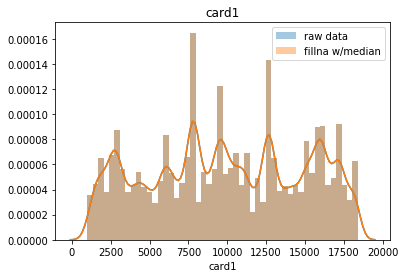

*** card2
count    581607.000000
mean        362.555488
std         157.793246
min         100.000000
25%         214.000000
50%         361.000000
75%         512.000000
max         600.000000
Name: card2, dtype: float64


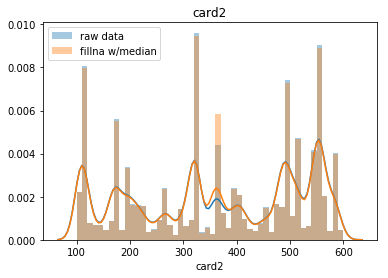

*** card3
count    588975.000000
mean        153.194925
std          11.336444
min         100.000000
25%         150.000000
50%         150.000000
75%         150.000000
max         231.000000
Name: card3, dtype: float64


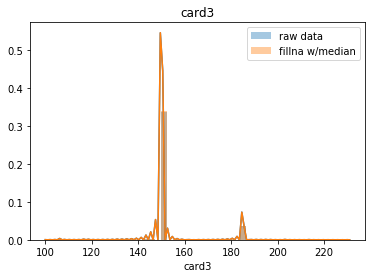

*** card4
count     588963
unique         4
top         visa
freq      384767
Name: card4, dtype: object
*** card5
count    586281.000000
mean        199.278897
std          41.244453
min         100.000000
25%         166.000000
50%         226.000000
75%         226.000000
max         237.000000
Name: card5, dtype: float64


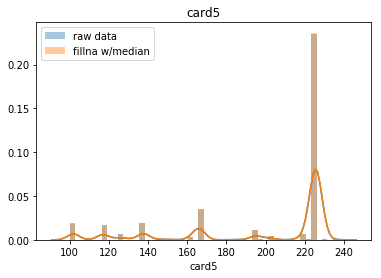

*** card6
count     588969
unique         4
top        debit
freq      439938
Name: card6, dtype: object


['card4', 'card6']

In [13]:
examine_group(trans_df,'card',1,6,showfill=True)

*** addr1
count    524834.000000
mean        290.733794
std         101.741072
min         100.000000
25%         204.000000
50%         299.000000
75%         330.000000
max         540.000000
Name: addr1, dtype: float64


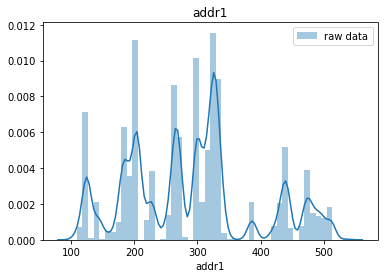

*** addr2
count    524834.000000
mean         86.800630
std           2.690623
min          10.000000
25%          87.000000
50%          87.000000
75%          87.000000
max         102.000000
Name: addr2, dtype: float64


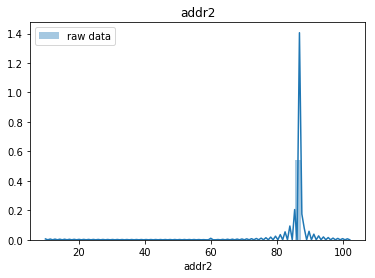

[]

In [14]:
# Peek at the addr columns. Data appears continuous but its purpose is more categorical (billing ZIP and country)
examine_group(trans_df,'addr',1,2)

*** dist1
count    238269.000000
mean        118.502180
std         371.872026
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64


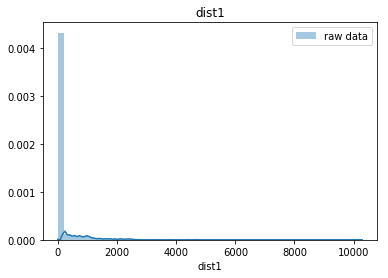

*** dist2
count    37627.000000
mean       231.855423
std        529.053494
min          0.000000
25%          7.000000
50%         37.000000
75%        206.000000
max      11623.000000
Name: dist2, dtype: float64


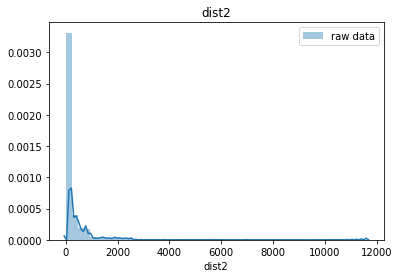

[]

In [15]:
# Peek at the dist columns. Continuous data representing distances between billing and shipping address, etc.
examine_group(trans_df,'dist',1,2)

In [16]:
# Peek at the emaildomain columns. Categorical data.
for i in ['P','R']:
    range_id = '{}_emaildomain'.format(i)
    print("*** {}".format(range_id))
    print(trans_df[range_id].describe())

*** P_emaildomain
count        496084
unique           59
top       gmail.com
freq         228355
Name: P_emaildomain, dtype: object
*** R_emaildomain
count        137291
unique           60
top       gmail.com
freq          57147
Name: R_emaildomain, dtype: object


R_emaildomain is not well-populated, as suggested above. I thought cases where this domain is not the same as the purchaser domain could be significant, but I didn't see any obvious patterns.

Further, I had issues with both the P_ and R_ emaildomain columns, because they are categorical data, and they contain different values between the training and test sets, adding complexity to attempts to encode them. So, I'm going to drop both.

*** C1
count    590540.000000
mean         14.092458
std         133.569018
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        4685.000000
Name: C1, dtype: float64


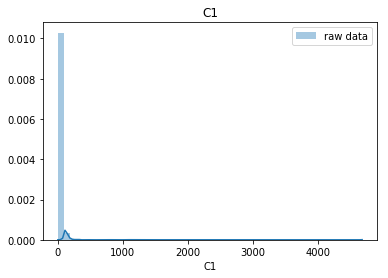

*** C2
count    590540.000000
mean         15.269734
std         154.668899
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        5691.000000
Name: C2, dtype: float64


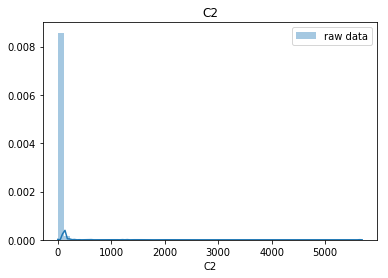

*** C3
count    590540.000000
mean          0.005644
std           0.150536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: C3, dtype: float64


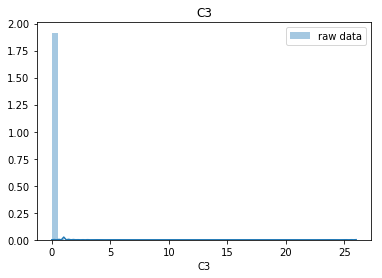

*** C4
count    590540.000000
mean          4.092185
std          68.848459
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2253.000000
Name: C4, dtype: float64


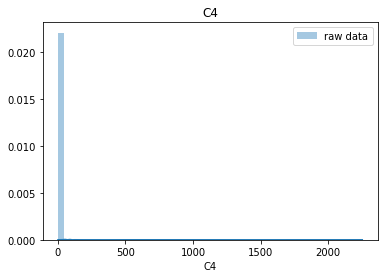

*** C5
count    590540.000000
mean          5.571526
std          25.786976
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         349.000000
Name: C5, dtype: float64


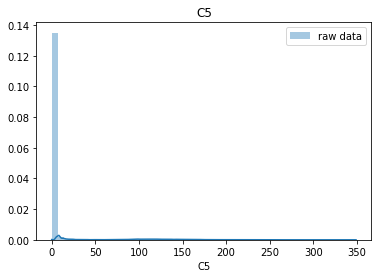

*** C6
count    590540.000000
mean          9.071082
std          71.508467
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        2253.000000
Name: C6, dtype: float64


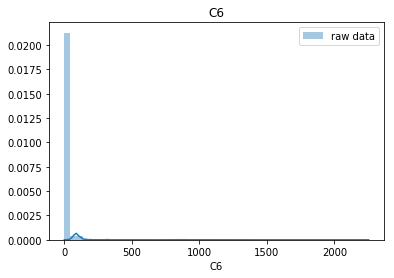

*** C7
count    590540.000000
mean          2.848478
std          61.727304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2255.000000
Name: C7, dtype: float64


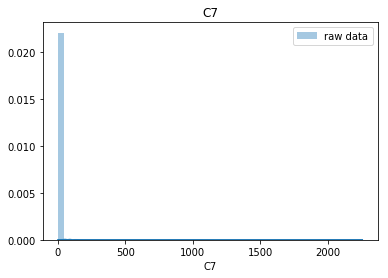

*** C8
count    590540.000000
mean          5.144574
std          95.378574
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3331.000000
Name: C8, dtype: float64


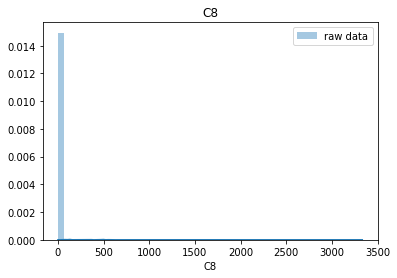

*** C9
count    590540.000000
mean          4.480240
std          16.674897
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         210.000000
Name: C9, dtype: float64


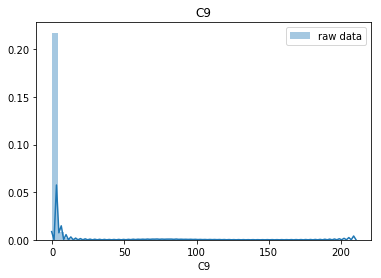

*** C10
count    590540.000000
mean          5.240343
std          95.581443
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3257.000000
Name: C10, dtype: float64


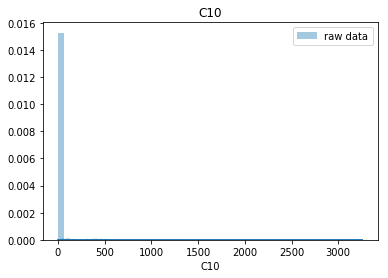

*** C11
count    590540.000000
mean         10.241521
std          94.336292
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        3188.000000
Name: C11, dtype: float64


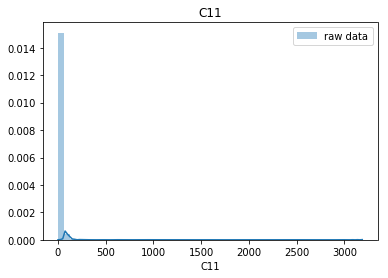

*** C12
count    590540.000000
mean          4.076227
std          86.666218
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3188.000000
Name: C12, dtype: float64


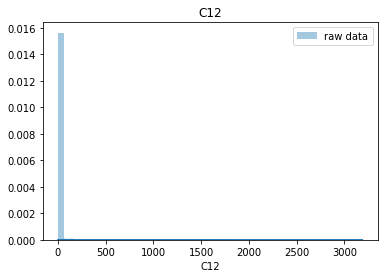

*** C13
count    590540.000000
mean         32.539918
std         129.364844
min           0.000000
25%           1.000000
50%           3.000000
75%          12.000000
max        2918.000000
Name: C13, dtype: float64


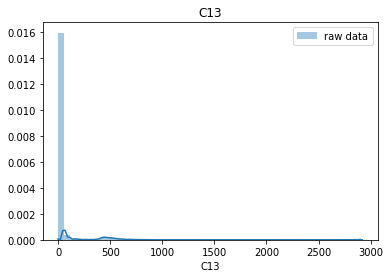

*** C14
count    590540.000000
mean          8.295215
std          49.544262
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1429.000000
Name: C14, dtype: float64


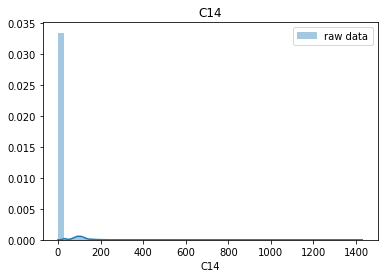

[]

In [17]:
examine_group(trans_df,'C',1,14)

In [18]:
trans_df['C2'].mode()

0    1.0
dtype: float64

*** D1
count    589271.000000
mean         94.347568
std         157.660387
min           0.000000
25%           0.000000
50%           3.000000
75%         122.000000
max         640.000000
Name: D1, dtype: float64


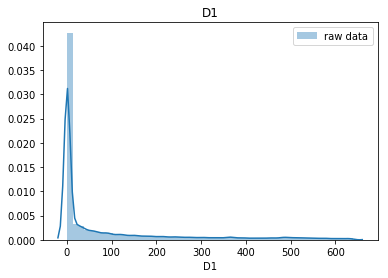

*** D2
count    309743.000000
mean        169.563231
std         177.315865
min           0.000000
25%          26.000000
50%          97.000000
75%         276.000000
max         640.000000
Name: D2, dtype: float64


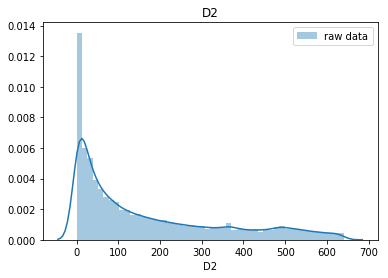

*** D3
count    327662.000000
mean         28.343348
std          62.384721
min           0.000000
25%           1.000000
50%           8.000000
75%          27.000000
max         819.000000
Name: D3, dtype: float64


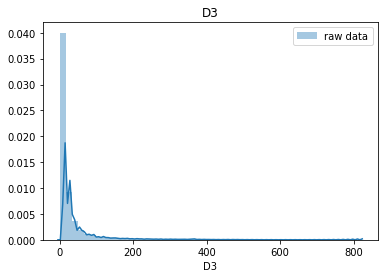

*** D4
count    421618.000000
mean        140.002441
std         191.096774
min        -122.000000
25%           0.000000
50%          26.000000
75%         253.000000
max         869.000000
Name: D4, dtype: float64


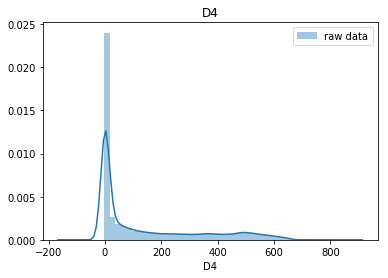

*** D5
count    280699.000000
mean         42.335965
std          89.000144
min           0.000000
25%           1.000000
50%          10.000000
75%          32.000000
max         819.000000
Name: D5, dtype: float64


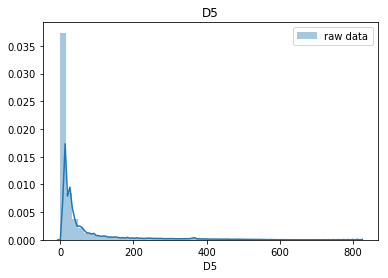

*** D6
count    73187.000000
mean        69.805717
std        143.669253
min        -83.000000
25%          0.000000
50%          0.000000
75%         40.000000
max        873.000000
Name: D6, dtype: float64


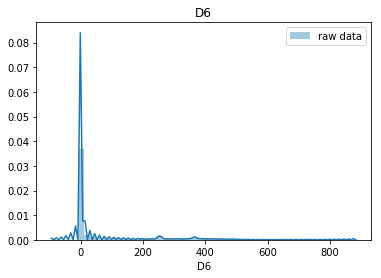

*** D7
count    38917.000000
mean        41.638950
std         99.743264
min          0.000000
25%          0.000000
50%          0.000000
75%         17.000000
max        843.000000
Name: D7, dtype: float64


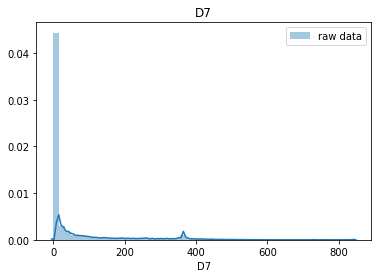

*** D8
count    74926.000000
mean       146.058108
std        231.663840
min          0.000000
25%          0.958333
50%         37.875000
75%        187.958328
max       1707.791626
Name: D8, dtype: float64


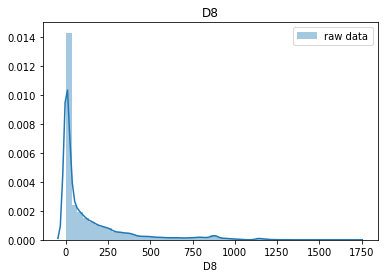

*** D9
count    74926.000000
mean         0.561057
std          0.316880
min          0.000000
25%          0.208333
50%          0.666666
75%          0.833333
max          0.958333
Name: D9, dtype: float64


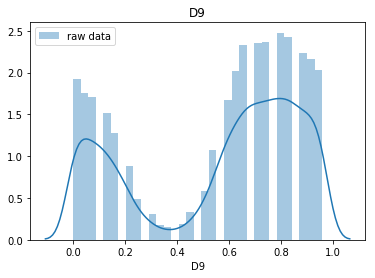

*** D10
count    514518.000000
mean        123.982137
std         182.615225
min           0.000000
25%           0.000000
50%          15.000000
75%         197.000000
max         876.000000
Name: D10, dtype: float64


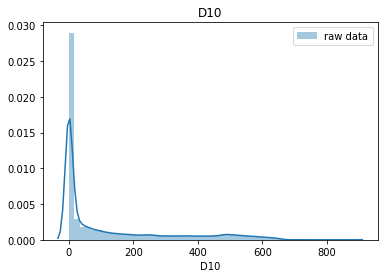

*** D11
count    311253.000000
mean        146.621465
std         186.042622
min         -53.000000
25%           0.000000
50%          43.000000
75%         274.000000
max         670.000000
Name: D11, dtype: float64


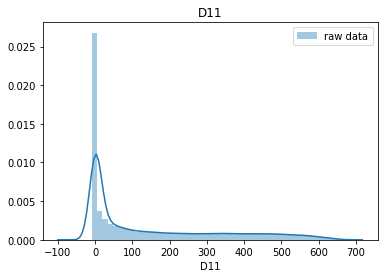

*** D12
count    64717.000000
mean        54.037533
std        124.274558
min        -83.000000
25%          0.000000
50%          0.000000
75%         13.000000
max        648.000000
Name: D12, dtype: float64


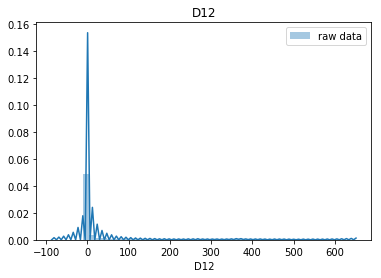

*** D13
count    61952.000000
mean        17.901295
std         67.614425
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        847.000000
Name: D13, dtype: float64


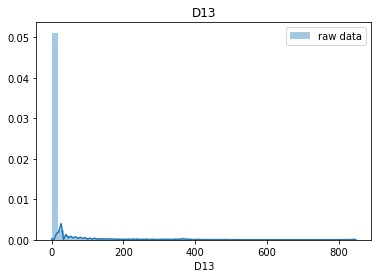

*** D14
count    62187.000000
mean        57.724444
std        136.312450
min       -193.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        878.000000
Name: D14, dtype: float64


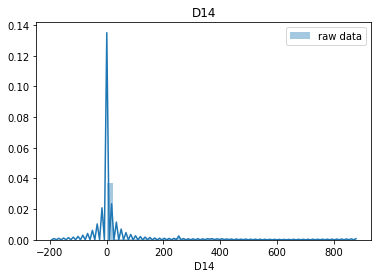

*** D15
count    501427.000000
mean        163.744579
std         202.726660
min         -83.000000
25%           0.000000
50%          52.000000
75%         314.000000
max         879.000000
Name: D15, dtype: float64


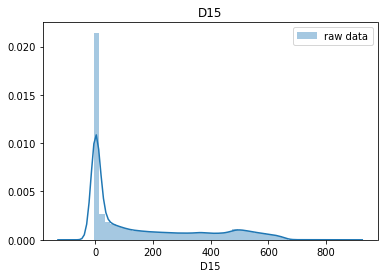

[]

In [19]:
examine_group(trans_df,'D',1,15)

In [20]:
examine_group(trans_df,'M',1,9)

*** M1
count     319440
unique         2
top            T
freq      319415
Name: M1, dtype: object
*** M2
count     319440
unique         2
top            T
freq      285468
Name: M2, dtype: object
*** M3
count     319440
unique         2
top            T
freq      251731
Name: M3, dtype: object
*** M4
count     309096
unique         3
top           M0
freq      196405
Name: M4, dtype: object
*** M5
count     240058
unique         2
top            F
freq      132491
Name: M5, dtype: object
*** M6
count     421180
unique         2
top            F
freq      227856
Name: M6, dtype: object
*** M7
count     244275
unique         2
top            F
freq      211374
Name: M7, dtype: object
*** M8
count     244288
unique         2
top            F
freq      155251
Name: M8, dtype: object
*** M9
count     244288
unique         2
top            T
freq      205656
Name: M9, dtype: object


['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

We don't know much of anything about the Vesta-generated variables, but let's check to make sure that we're not going to severely mess with their distributions if we choose to fill NaNs for each variable with its median.

(This largely appears to be true--so many of these variables have a tight distribution that using the median may even help drag the mean away from the outliers and toward the median.)

*** V1
count    311253.000000
mean          0.999945
std           0.007390
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V1, dtype: float64


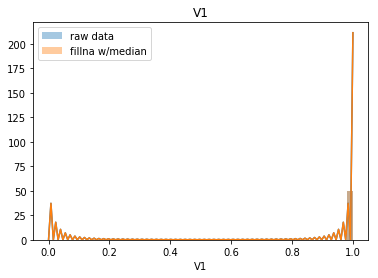

*** V2
count    311253.000000
mean          1.045204
std           0.240133
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V2, dtype: float64


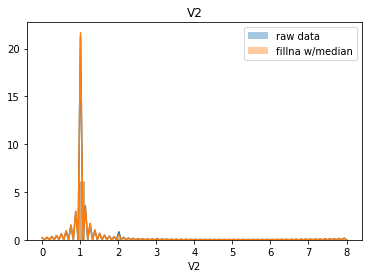

*** V3
count    311253.000000
mean          1.078075
std           0.320890
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V3, dtype: float64


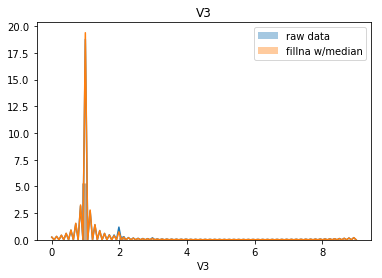

*** V4
count    311253.000000
mean          0.846456
std           0.440053
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V4, dtype: float64


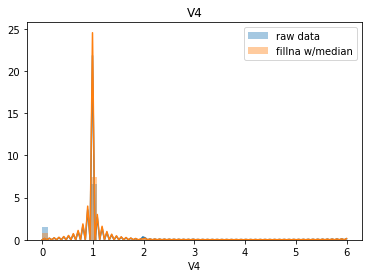

*** V5
count    311253.000000
mean          0.876991
std           0.475902
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V5, dtype: float64


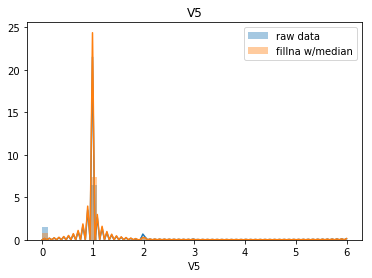

*** V6
count    311253.000000
mean          1.045686
std           0.239385
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V6, dtype: float64


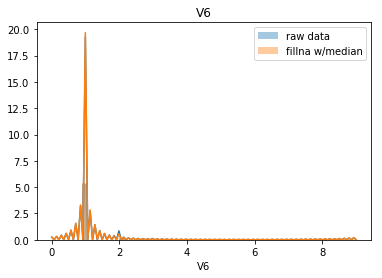

*** V7
count    311253.000000
mean          1.072870
std           0.304779
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V7, dtype: float64


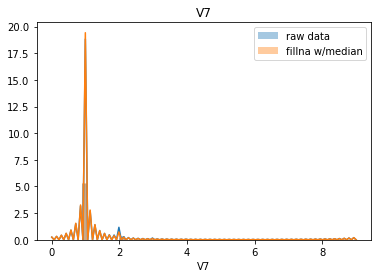

*** V8
count    311253.000000
mean          1.027704
std           0.186069
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V8, dtype: float64


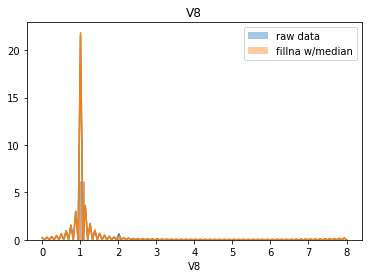

*** V9
count    311253.000000
mean          1.041529
std           0.226339
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V9, dtype: float64


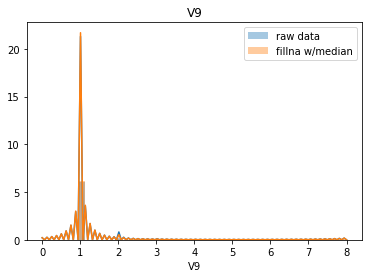

*** V10
count    311253.000000
mean          0.463915
std           0.521522
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           4.000000
Name: V10, dtype: float64


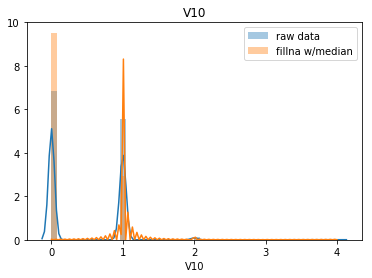

*** V11
count    311253.000000
mean          0.478987
std           0.552431
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V11, dtype: float64


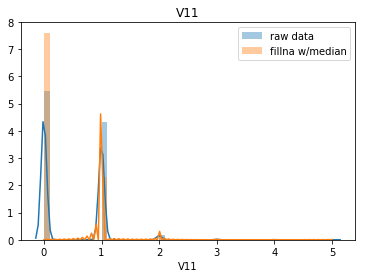

*** V12
count    514467.000000
mean          0.559711
std           0.510533
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V12, dtype: float64


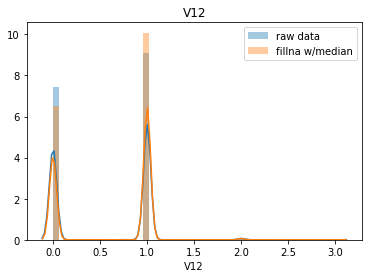

*** V13
count    514467.000000
mean          0.599166
std           0.532185
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V13, dtype: float64


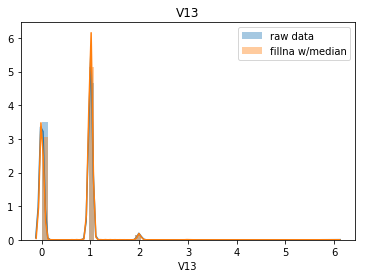

*** V14
count    514467.000000
mean          0.999500
std           0.022345
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V14, dtype: float64


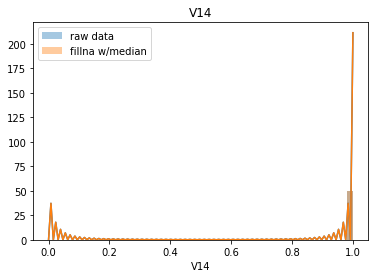

*** V15
count    514467.000000
mean          0.122342
std           0.332422
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V15, dtype: float64


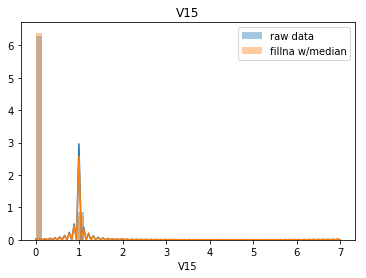

*** V16
count    514467.000000
mean          0.123460
std           0.342841
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V16, dtype: float64


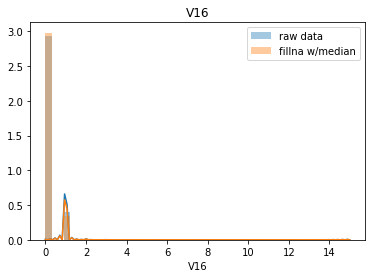

*** V17
count    514467.000000
mean          0.134040
std           0.364456
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V17, dtype: float64


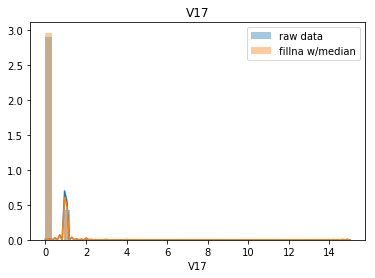

*** V18
count    514467.000000
mean          0.135363
std           0.371763
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V18, dtype: float64


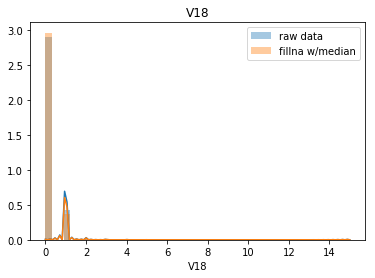

*** V19
count    514467.000000
mean          0.816371
std           0.425512
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V19, dtype: float64


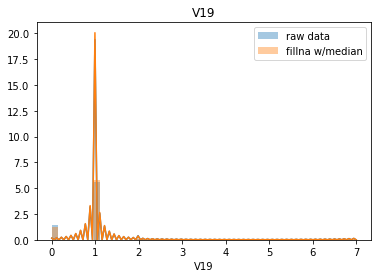

*** V20
count    514467.000000
mean          0.847843
std           0.459451
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          15.000000
Name: V20, dtype: float64


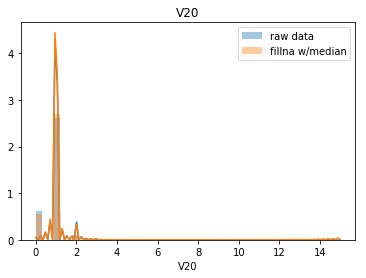

*** V21
count    514467.000000
mean          0.129684
std           0.339060
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
Name: V21, dtype: float64


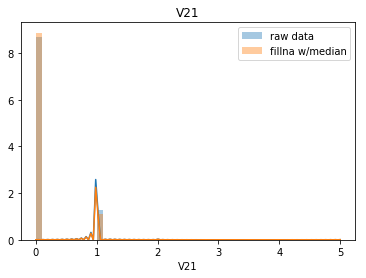

*** V22
count    514467.000000
mean          0.132292
std           0.359415
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V22, dtype: float64


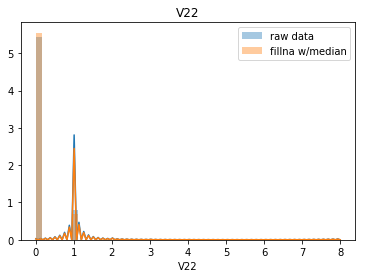

*** V23
count    514467.000000
mean          1.034791
std           0.247681
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V23, dtype: float64


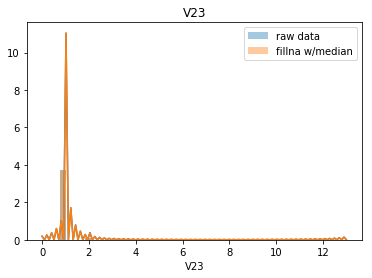

*** V24
count    514467.000000
mean          1.058097
std           0.305485
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V24, dtype: float64


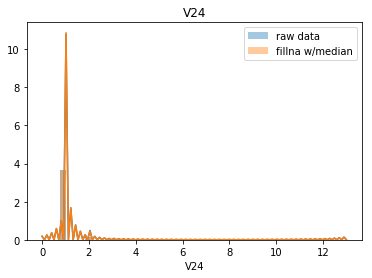

*** V25
count    514467.000000
mean          0.977660
std           0.185245
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V25, dtype: float64


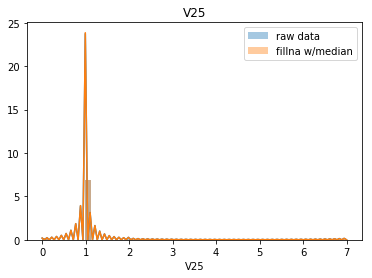

*** V26
count    514467.000000
mean          0.988040
std           0.209302
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V26, dtype: float64


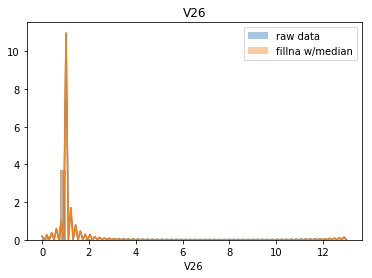

*** V27
count    514467.000000
mean          0.000776
std           0.028596
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: V27, dtype: float64


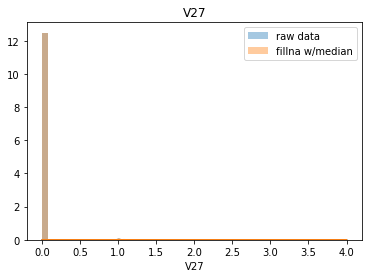

*** V28
count    514467.000000
mean          0.000830
std           0.031133
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: V28, dtype: float64


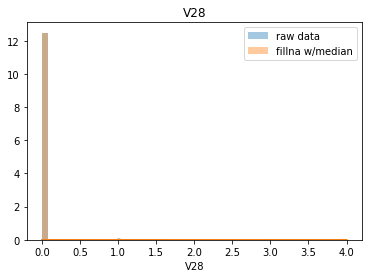

*** V29
count    514467.000000
mean          0.387840
std           0.510652
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V29, dtype: float64


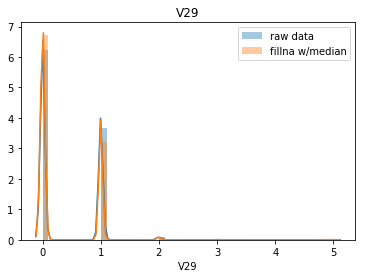

*** V30
count    514467.000000
mean          0.406436
std           0.554311
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           9.000000
Name: V30, dtype: float64


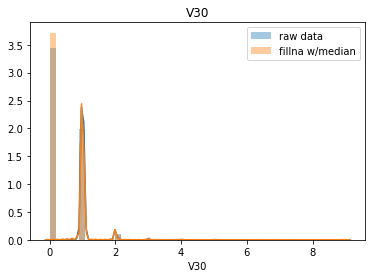

*** V31
count    514467.000000
mean          0.140761
std           0.355793
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V31, dtype: float64


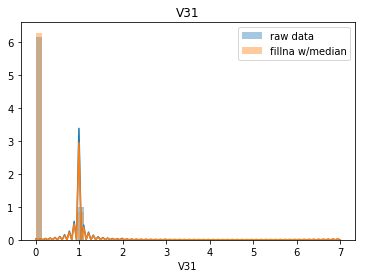

*** V32
count    514467.000000
mean          0.142417
std           0.368278
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V32, dtype: float64


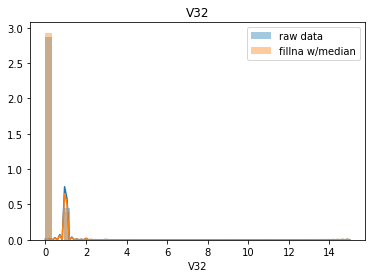

*** V33
count    514467.000000
mean          0.130693
std           0.340900
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V33, dtype: float64


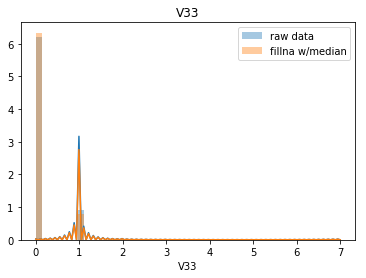

*** V34
count    514467.000000
mean          0.139154
std           0.357549
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: V34, dtype: float64


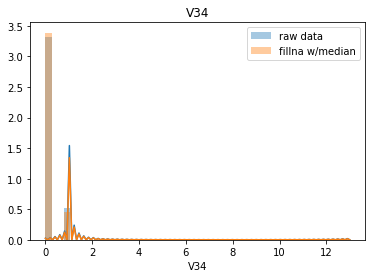

*** V35
count    421571.000000
mean          0.542594
std           0.516010
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V35, dtype: float64


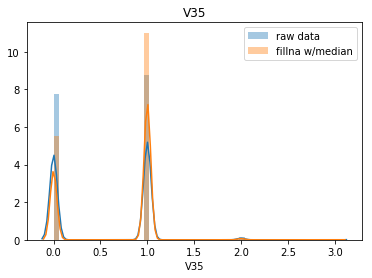

*** V36
count    421571.000000
mean          0.579198
std           0.539039
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: V36, dtype: float64


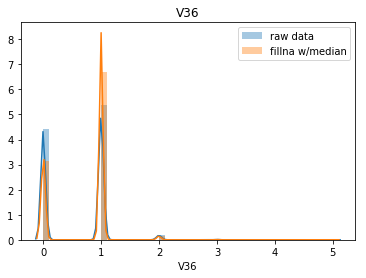

*** V37
count    421571.000000
mean          1.108065
std           0.690571
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          54.000000
Name: V37, dtype: float64


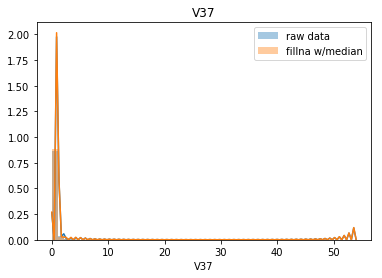

*** V38
count    421571.00000
mean          1.16240
std           0.85892
min           0.00000
25%           1.00000
50%           1.00000
75%           1.00000
max          54.00000
Name: V38, dtype: float64


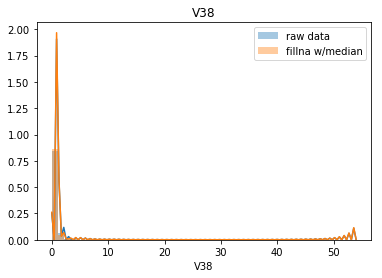

*** V39
count    421571.000000
mean          0.166076
std           0.451956
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V39, dtype: float64


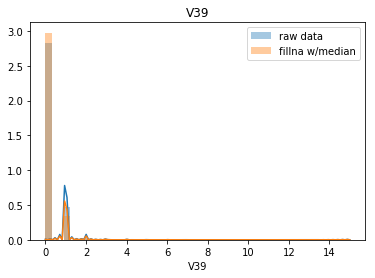

*** V40
count    421571.000000
mean          0.177145
std           0.505786
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: V40, dtype: float64


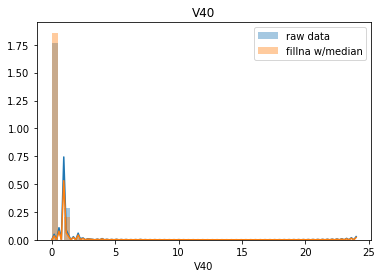

*** V41
count    421571.000000
mean          0.999269
std           0.027020
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V41, dtype: float64


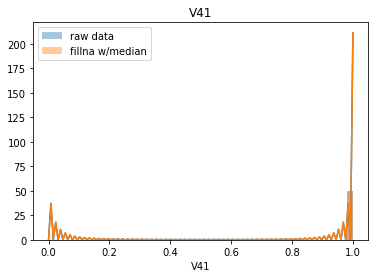

*** V42
count    421571.000000
mean          0.156118
std           0.382896
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V42, dtype: float64


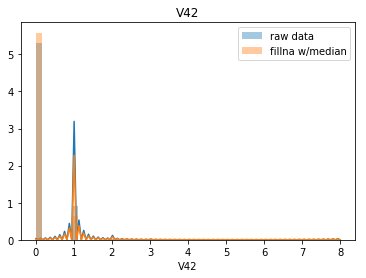

*** V43
count    421571.000000
mean          0.168942
std           0.433359
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V43, dtype: float64


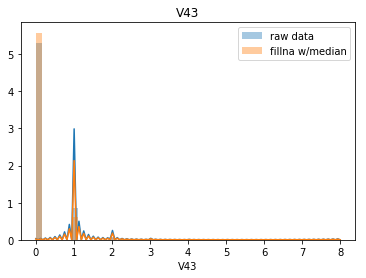

*** V44
count    421571.000000
mean          1.083891
std           0.639143
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          48.000000
Name: V44, dtype: float64


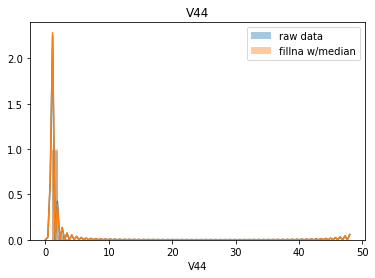

*** V45
count    421571.000000
mean          1.120779
std           0.729774
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          48.000000
Name: V45, dtype: float64


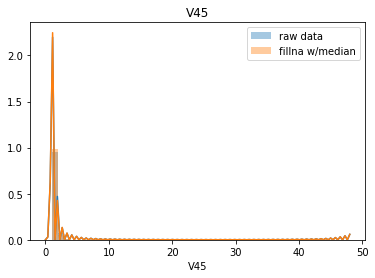

*** V46
count    421571.000000
mean          1.022286
std           0.166719
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V46, dtype: float64


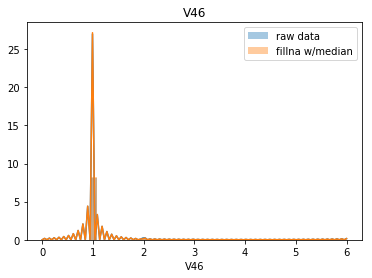

*** V47
count    421571.000000
mean          1.038515
std           0.231862
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          12.000000
Name: V47, dtype: float64


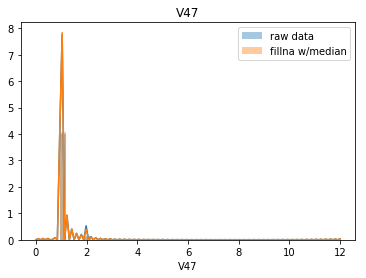

*** V48
count    421571.000000
mean          0.383174
std           0.508189
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V48, dtype: float64


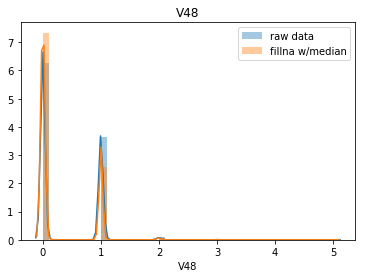

*** V49
count    421571.000000
mean          0.397724
std           0.542654
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V49, dtype: float64


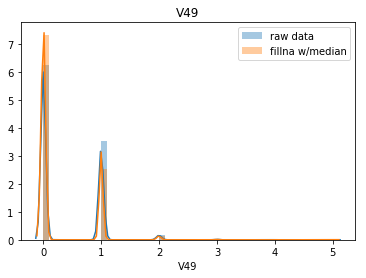

*** V50
count    421571.000000
mean          0.164746
std           0.373995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
Name: V50, dtype: float64


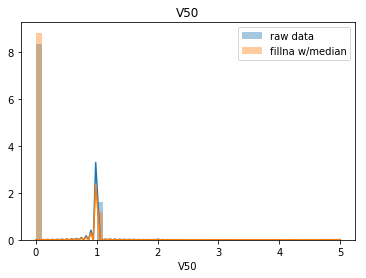

*** V51
count    421571.000000
mean          0.170579
std           0.403899
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: V51, dtype: float64


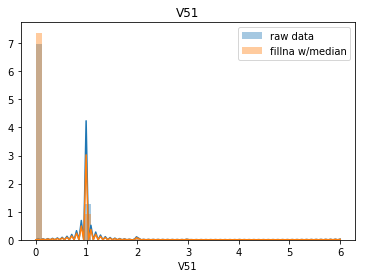

*** V52
count    421571.000000
mean          0.182695
std           0.439002
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V52, dtype: float64


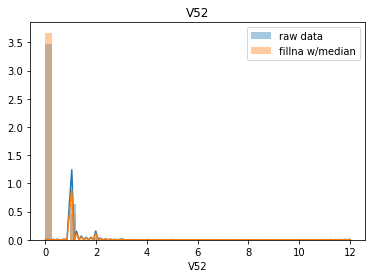

*** V53
count    513444.000000
mean          0.577586
std           0.511571
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: V53, dtype: float64


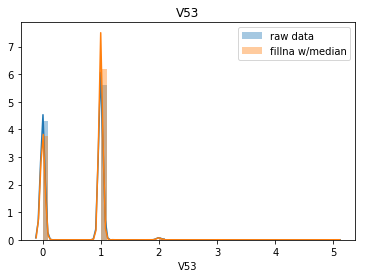

*** V54
count    513444.000000
mean          0.619982
std           0.534635
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V54, dtype: float64


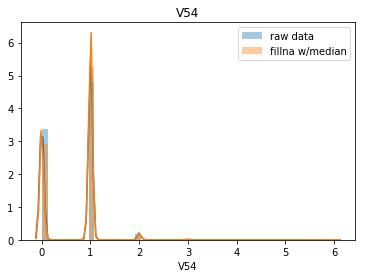

*** V55
count    513444.000000
mean          1.067670
std           0.391364
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          17.000000
Name: V55, dtype: float64


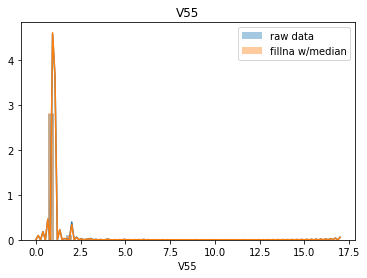

*** V56
count    513444.000000
mean          1.120979
std           0.661129
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          51.000000
Name: V56, dtype: float64


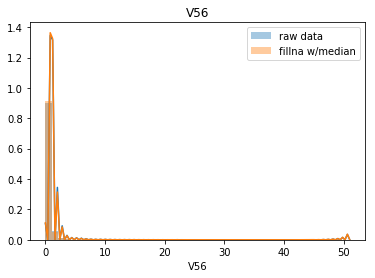

*** V57
count    513444.000000
mean          0.128312
std           0.349094
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: V57, dtype: float64


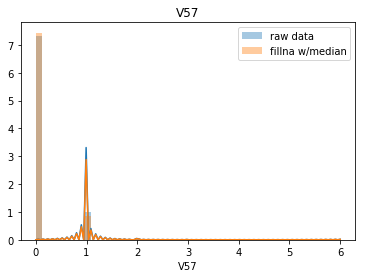

*** V58
count    513444.000000
mean          0.132453
std           0.372907
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: V58, dtype: float64


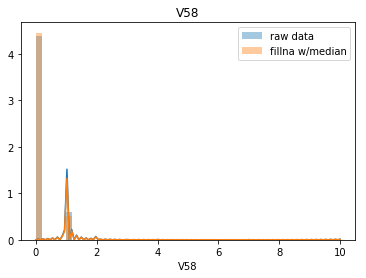

*** V59
count    513444.000000
mean          0.134433
std           0.379291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V59, dtype: float64


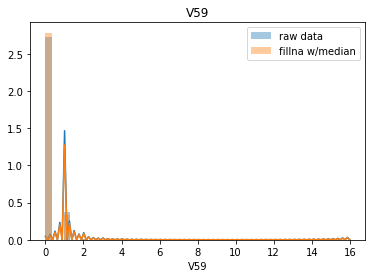

*** V60
count    513444.000000
mean          0.142537
std           0.418230
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V60, dtype: float64


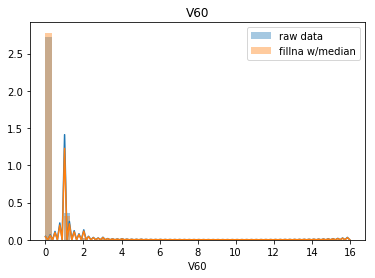

*** V61
count    513444.000000
mean          0.829785
std           0.436617
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V61, dtype: float64


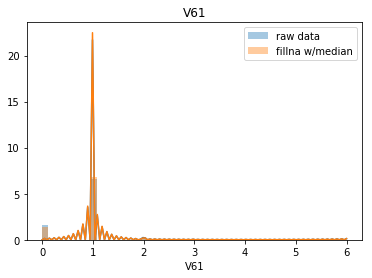

*** V62
count    513444.000000
mean          0.867563
std           0.483803
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          10.000000
Name: V62, dtype: float64


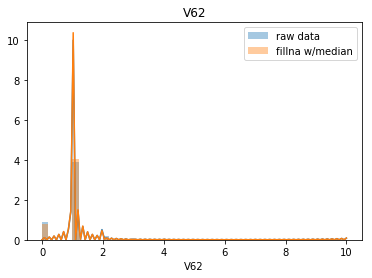

*** V63
count    513444.000000
mean          0.130743
std           0.355262
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V63, dtype: float64


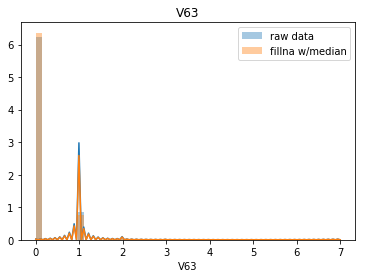

*** V64
count    513444.000000
mean          0.141825
std           0.406157
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V64, dtype: float64


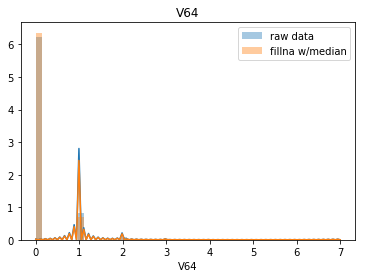

*** V65
count    513444.000000
mean          0.999663
std           0.018353
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V65, dtype: float64


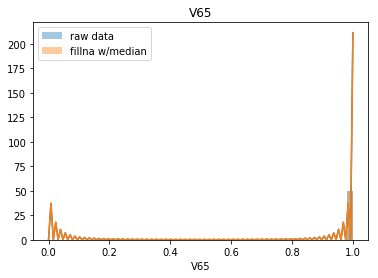

*** V66
count    513444.000000
mean          0.981038
std           0.216235
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V66, dtype: float64


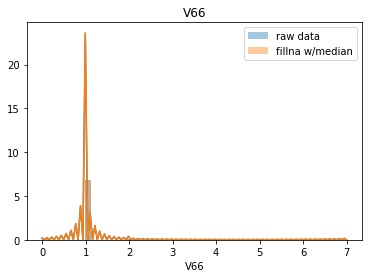

*** V67
count    513444.000000
mean          0.998121
std           0.245912
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V67, dtype: float64


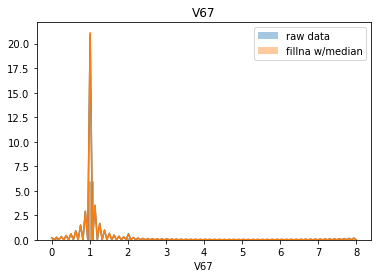

*** V68
count    513444.000000
mean          0.000534
std           0.023760
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: V68, dtype: float64


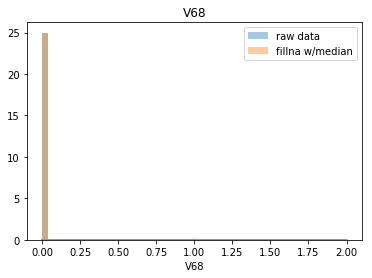

*** V69
count    513444.000000
mean          0.390200
std           0.513696
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V69, dtype: float64


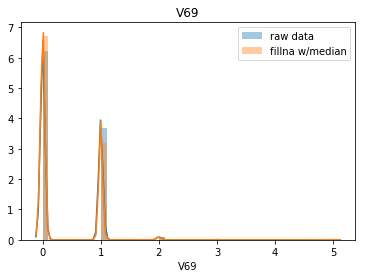

*** V70
count    513444.000000
mean          0.407924
std           0.554499
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           6.000000
Name: V70, dtype: float64


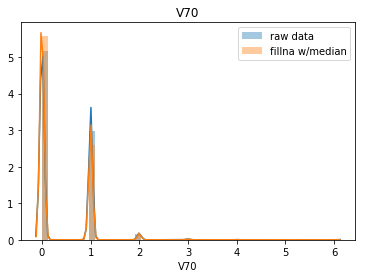

*** V71
count    513444.000000
mean          0.140639
std           0.364303
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: V71, dtype: float64


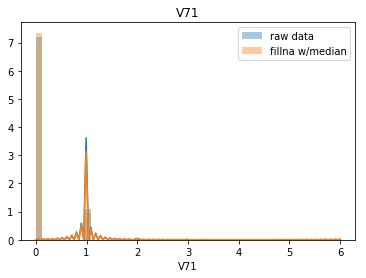

*** V72
count    513444.000000
mean          0.145124
std           0.389212
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: V72, dtype: float64


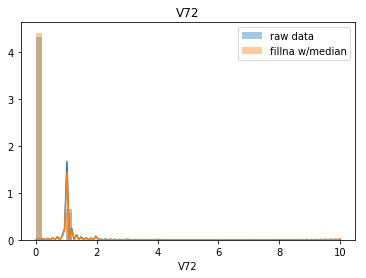

*** V73
count    513444.000000
mean          0.139982
std           0.367098
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V73, dtype: float64


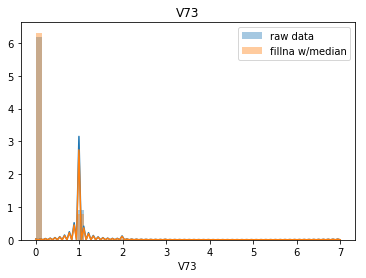

*** V74
count    513444.000000
mean          0.152147
std           0.393274
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V74, dtype: float64


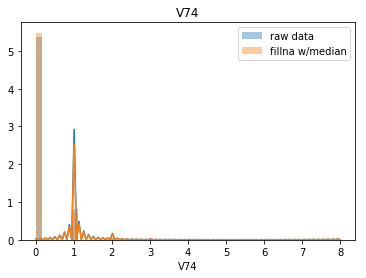

*** V75
count    501376.000000
mean          0.544278
std           0.514318
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: V75, dtype: float64


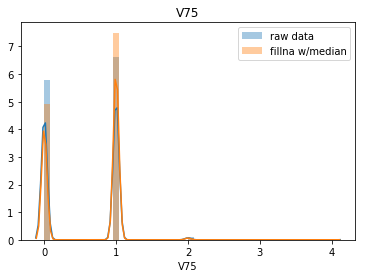

*** V76
count    501376.000000
mean          0.587557
std           0.538230
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V76, dtype: float64


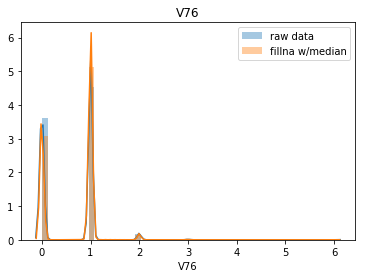

*** V77
count    501376.000000
mean          1.086893
std           0.532958
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: V77, dtype: float64


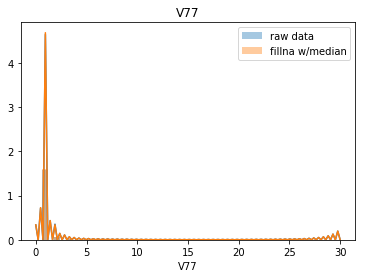

*** V78
count    501376.000000
mean          1.144462
std           0.781474
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          31.000000
Name: V78, dtype: float64


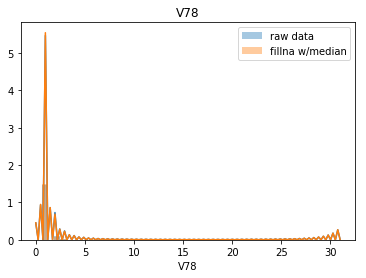

*** V79
count    501376.000000
mean          0.136867
std           0.379904
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V79, dtype: float64


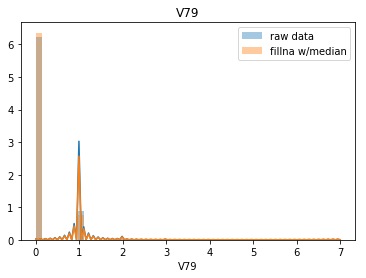

*** V80
count    501376.000000
mean          0.143954
std           0.409932
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: V80, dtype: float64


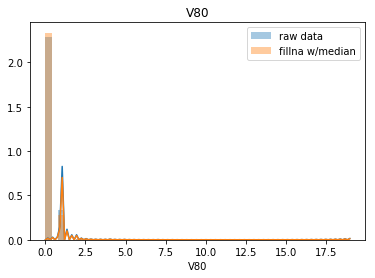

*** V81
count    501376.000000
mean          0.152696
std           0.452298
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: V81, dtype: float64


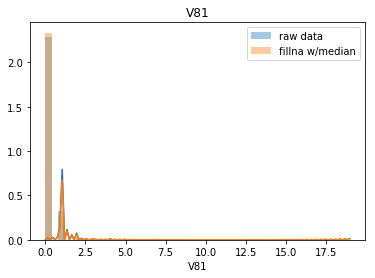

*** V82
count    501376.000000
mean          0.844610
std           0.422529
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V82, dtype: float64


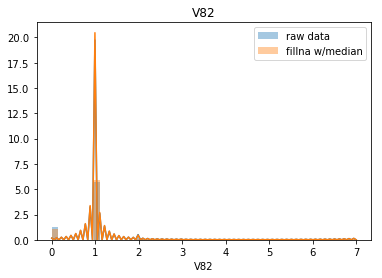

*** V83
count    501376.000000
mean          0.881965
std           0.470757
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V83, dtype: float64


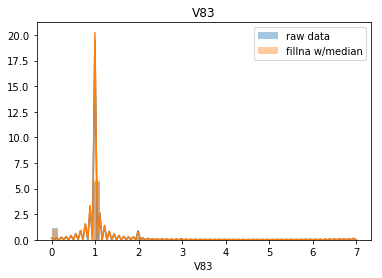

*** V84
count    501376.000000
mean          0.137145
std           0.361875
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V84, dtype: float64


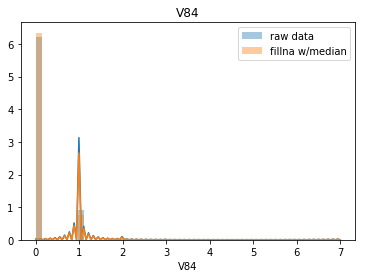

*** V85
count    501376.000000
mean          0.149788
std           0.419445
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V85, dtype: float64


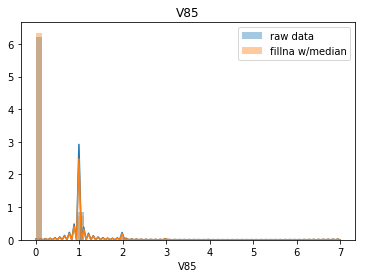

*** V86
count    501376.000000
mean          1.064885
std           0.419807
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: V86, dtype: float64


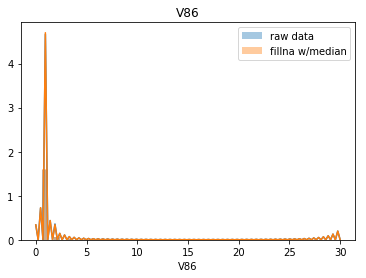

*** V87
count    501376.000000
mean          1.099456
std           0.511281
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: V87, dtype: float64


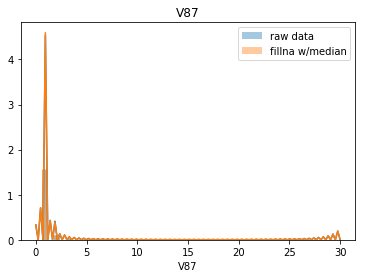

*** V88
count    501376.000000
mean          0.999246
std           0.027447
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V88, dtype: float64


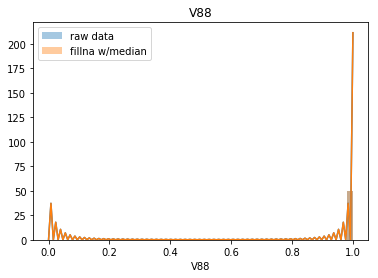

*** V89
count    501376.000000
mean          0.000902
std           0.031943
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: V89, dtype: float64


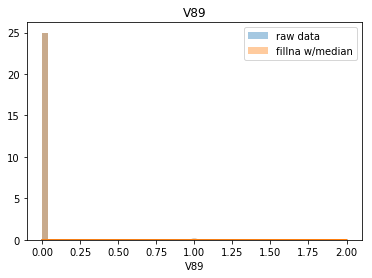

*** V90
count    501376.000000
mean          0.401862
std           0.516153
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           5.000000
Name: V90, dtype: float64


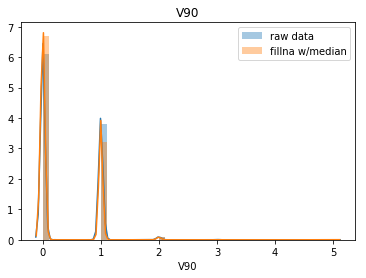

*** V91
count    501376.000000
mean          0.420461
std           0.561865
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           6.000000
Name: V91, dtype: float64


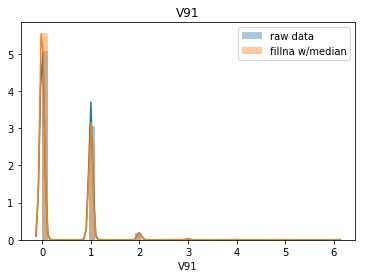

*** V92
count    501376.000000
mean          0.150322
std           0.375682
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V92, dtype: float64


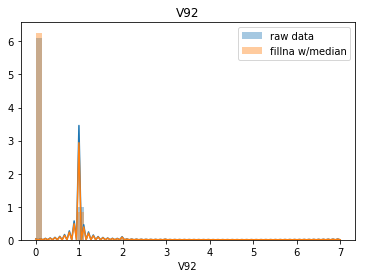

*** V93
count    501376.000000
mean          0.154812
std           0.402314
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V93, dtype: float64


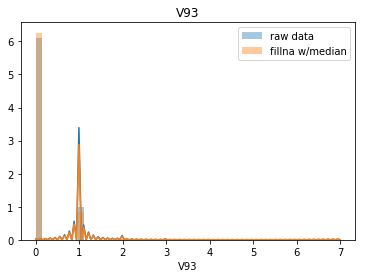

*** V94
count    501376.000000
mean          0.137007
std           0.343878
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: V94, dtype: float64


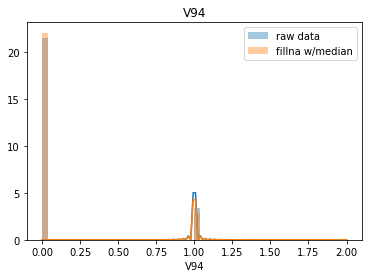

*** V95
count    590226.000000
mean          1.038019
std          21.034304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         880.000000
Name: V95, dtype: float64


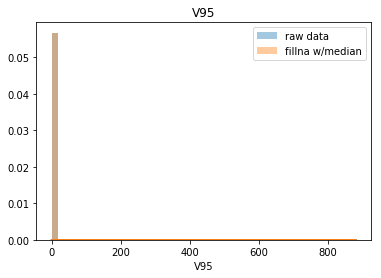

*** V96
count    590226.00000
mean          3.00519
std          40.23949
min           0.00000
25%           0.00000
50%           0.00000
75%           1.00000
max        1410.00000
Name: V96, dtype: float64


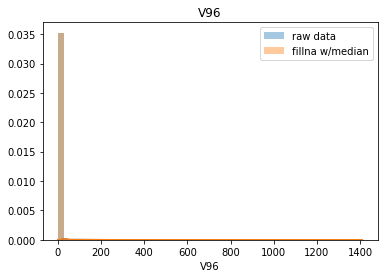

*** V97
count    590226.000000
mean          1.718933
std          27.700449
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         976.000000
Name: V97, dtype: float64


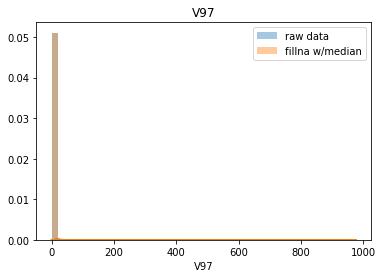

*** V98
count    590226.000000
mean          0.061985
std           0.284995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V98, dtype: float64


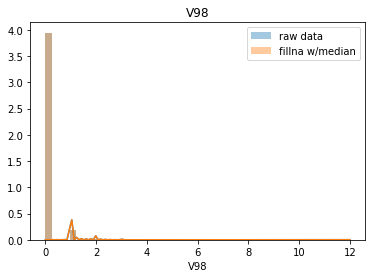

*** V99
count    590226.000000
mean          0.894986
std           2.722552
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          88.000000
Name: V99, dtype: float64


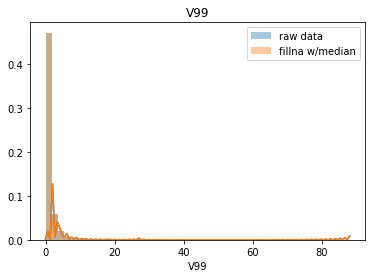

*** V100
count    590226.000000
mean          0.273504
std           0.947176
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          28.000000
Name: V100, dtype: float64


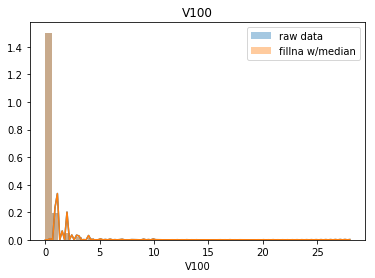

*** V101
count    590226.000000
mean          0.889249
std          20.582571
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         869.000000
Name: V101, dtype: float64


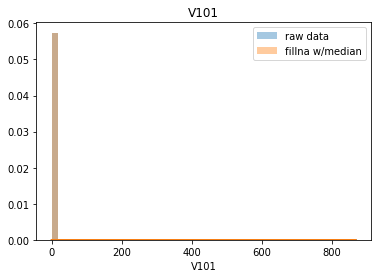

*** V102
count    590226.000000
mean          1.827229
std          35.928456
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1285.000000
Name: V102, dtype: float64


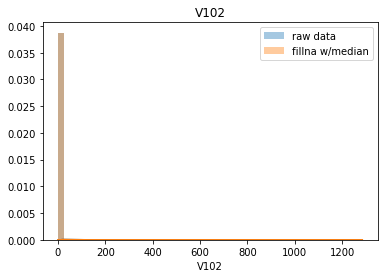

*** V103
count    590226.000000
mean          1.279288
std          25.685642
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         928.000000
Name: V103, dtype: float64


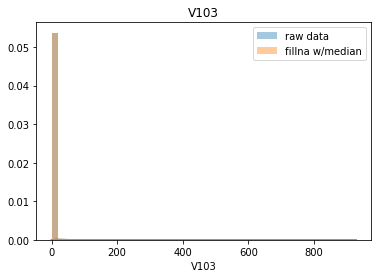

*** V104
count    590226.000000
mean          0.085433
std           0.648718
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          15.000000
Name: V104, dtype: float64


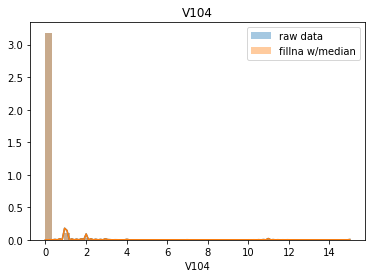

*** V105
count    590226.000000
mean          0.281145
std           3.373948
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.000000
Name: V105, dtype: float64


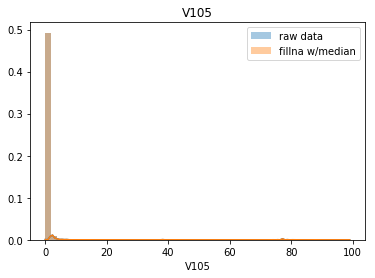

*** V106
count    590226.000000
mean          0.164584
std           1.825665
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: V106, dtype: float64


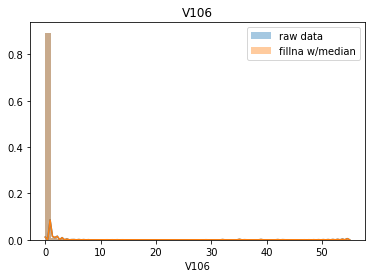

*** V107
count    590226.000000
mean          0.999580
std           0.020494
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: V107, dtype: float64


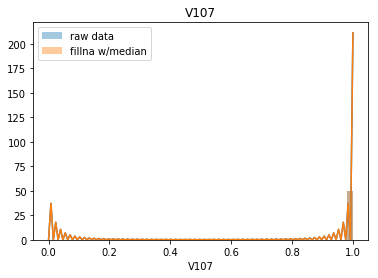

*** V108
count    590226.000000
mean          1.004613
std           0.081146
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V108, dtype: float64


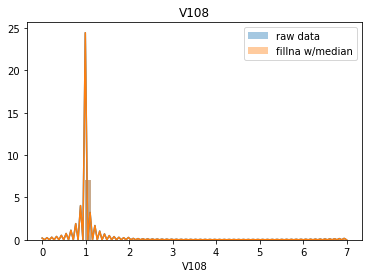

*** V109
count    590226.000000
mean          1.014816
std           0.127769
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V109, dtype: float64


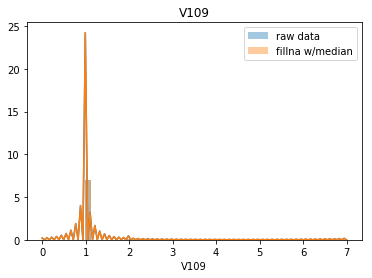

*** V110
count    590226.000000
mean          1.007739
std           0.097290
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V110, dtype: float64


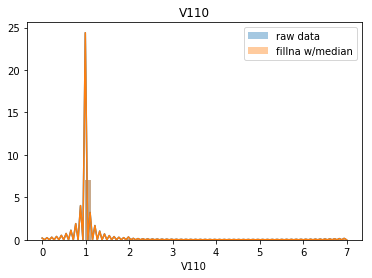

*** V111
count    590226.000000
mean          1.002563
std           0.070830
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V111, dtype: float64


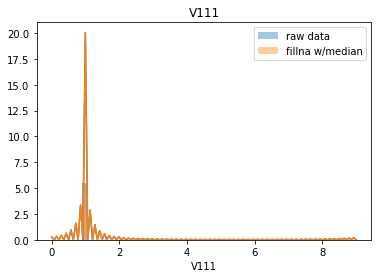

*** V112
count    590226.000000
mean          1.005356
std           0.084617
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V112, dtype: float64


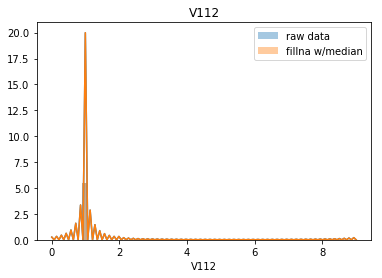

*** V113
count    590226.000000
mean          1.003383
std           0.074754
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V113, dtype: float64


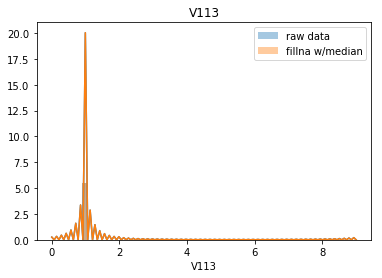

*** V114
count    590226.000000
mean          1.009298
std           0.110179
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V114, dtype: float64


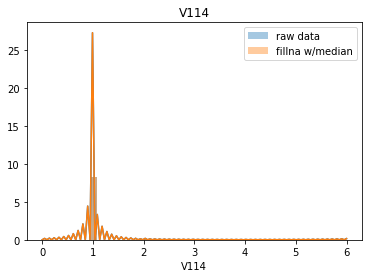

*** V115
count    590226.000000
mean          1.032450
std           0.190385
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V115, dtype: float64


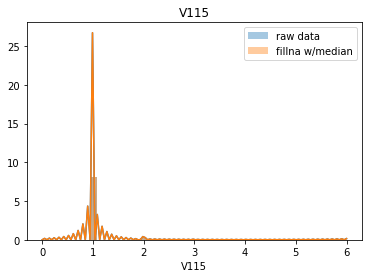

*** V116
count    590226.000000
mean          1.015738
std           0.136770
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           6.000000
Name: V116, dtype: float64


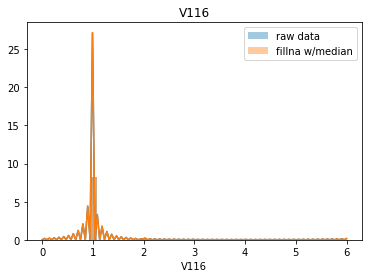

*** V117
count    590226.000000
mean          1.000391
std           0.035238
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V117, dtype: float64


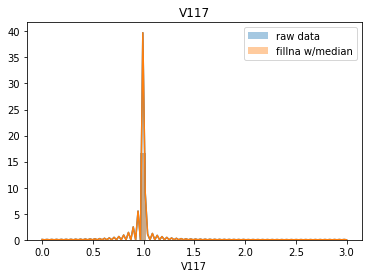

*** V118
count    590226.000000
mean          1.001474
std           0.041011
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V118, dtype: float64


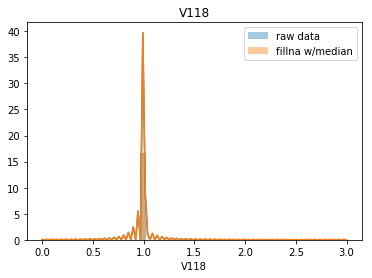

*** V119
count    590226.000000
mean          1.000729
std           0.036392
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V119, dtype: float64


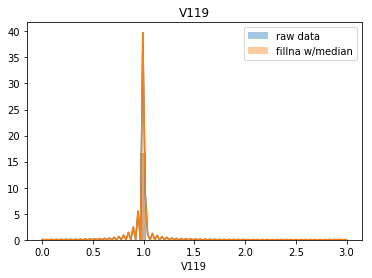

*** V120
count    590226.000000
mean          1.000874
std           0.041684
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V120, dtype: float64


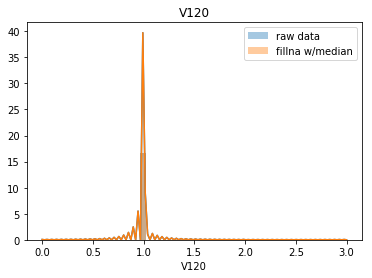

*** V121
count    590226.000000
mean          1.004276
std           0.067097
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V121, dtype: float64


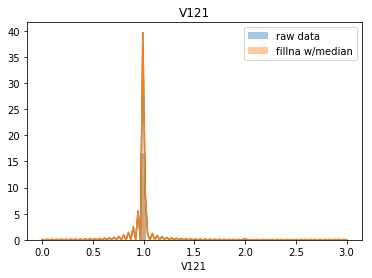

*** V122
count    590226.000000
mean          1.001759
std           0.048636
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V122, dtype: float64


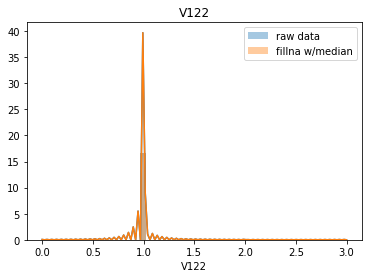

*** V123
count    590226.000000
mean          1.031120
std           0.228134
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V123, dtype: float64


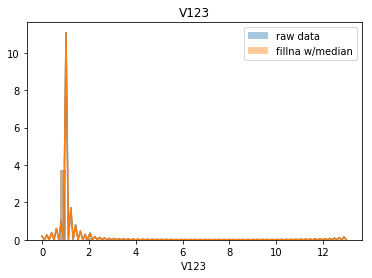

*** V124
count    590226.000000
mean          1.092975
std           0.374103
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V124, dtype: float64


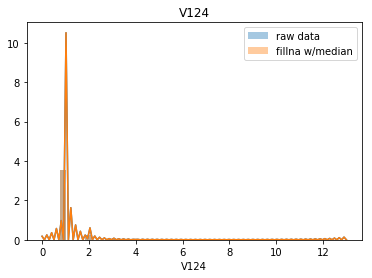

*** V125
count    590226.000000
mean          1.050415
std           0.280037
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V125, dtype: float64


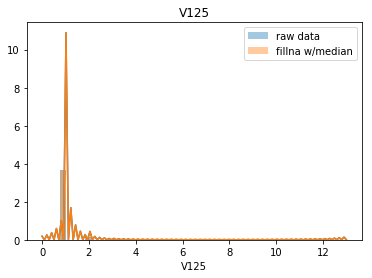

*** V126
count    590226.000000
mean        129.979417
std        2346.951681
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      160000.000000
Name: V126, dtype: float64


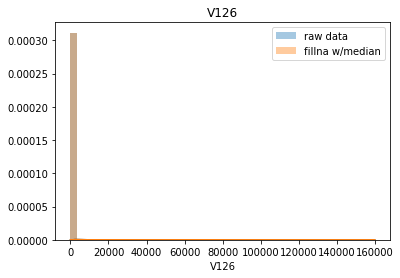

*** V127
count    590226.000000
mean        336.611559
std        4238.666949
min           0.000000
25%           0.000000
50%           0.000000
75%         107.949997
max      160000.000000
Name: V127, dtype: float64


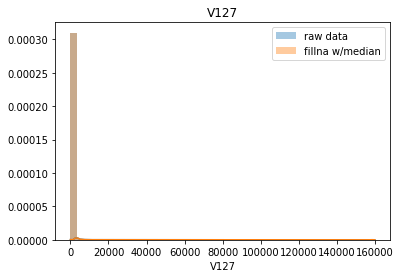

*** V128
count    590226.000000
mean        204.094038
std        3010.258774
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      160000.000000
Name: V128, dtype: float64


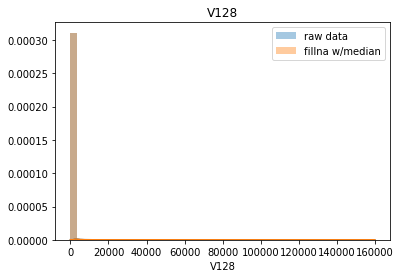

*** V129
count    590226.000000
mean          8.768944
std         113.832828
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V129, dtype: float64


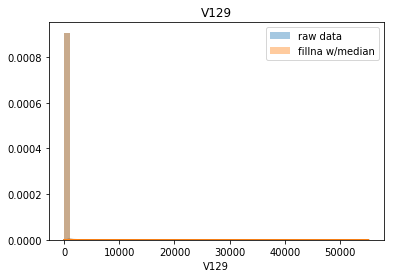

*** V130
count    590226.000000
mean         92.165849
std         315.960485
min           0.000000
25%           0.000000
50%           0.000000
75%          59.000000
max       55125.000000
Name: V130, dtype: float64


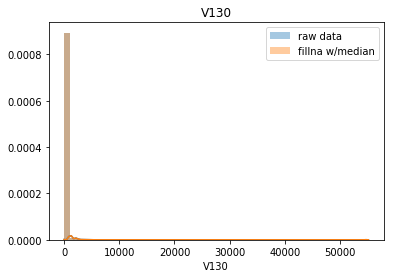

*** V131
count    590226.000000
mean         31.133302
std         161.161258
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V131, dtype: float64


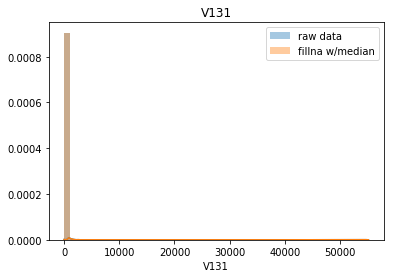

*** V132
count    590226.000000
mean        103.513188
std        2266.106140
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       93736.000000
Name: V132, dtype: float64


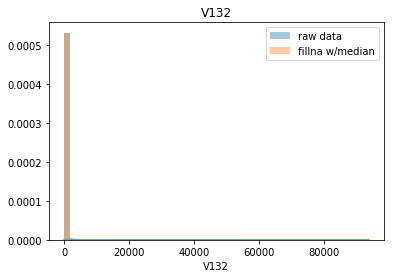

*** V133
count    590226.000000
mean        204.889160
std        3796.316755
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      133915.000000
Name: V133, dtype: float64


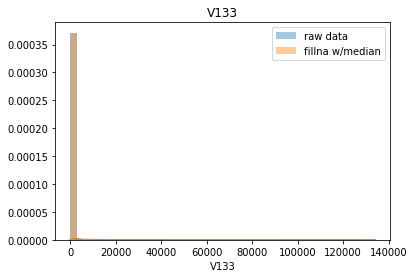

*** V134
count    590226.000000
mean        145.972328
std        2772.986817
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       98476.000000
Name: V134, dtype: float64


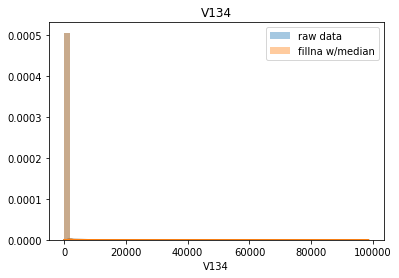

*** V135
count    590226.000000
mean         17.250132
std         293.847563
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       90750.000000
Name: V135, dtype: float64


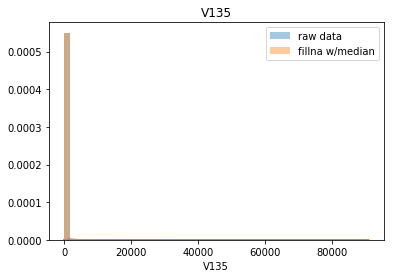

*** V136
count    590226.000000
mean         38.821196
std         451.808411
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       90750.000000
Name: V136, dtype: float64


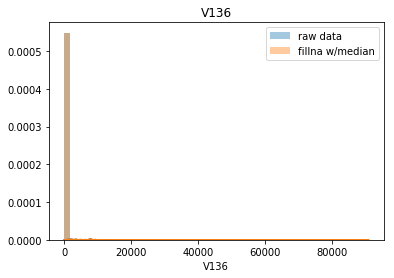

*** V137
count    590226.000000
mean         26.365090
std         348.332714
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       90750.000000
Name: V137, dtype: float64


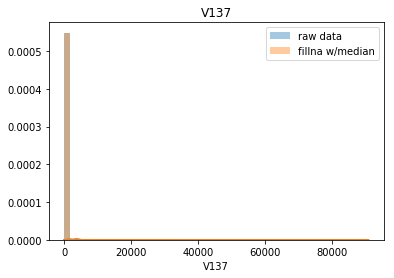

*** V138
count    81945.000000
mean         0.036439
std          0.428490
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         22.000000
Name: V138, dtype: float64


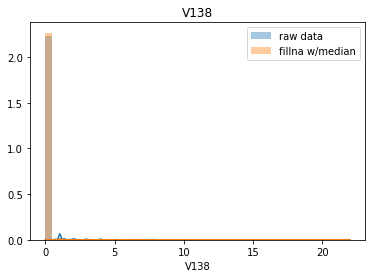

*** V139
count    81945.000000
mean         1.073915
std          1.333924
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: V139, dtype: float64


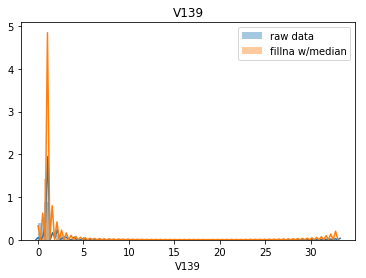

*** V140
count    81945.000000
mean         1.125267
std          1.467850
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         33.000000
Name: V140, dtype: float64


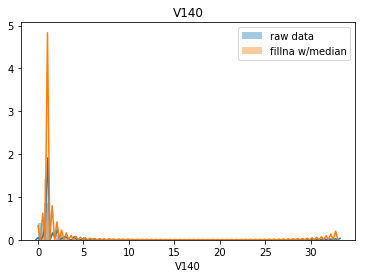

*** V141
count    81945.000000
mean         0.037696
std          0.215133
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: V141, dtype: float64


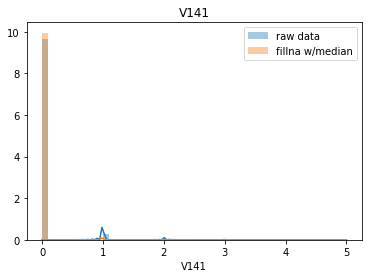

*** V142
count    81945.000000
mean         0.048581
std          0.313888
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          9.000000
Name: V142, dtype: float64


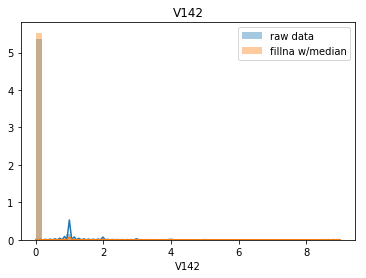

*** V143
count    81951.000000
mean         8.397006
std         55.267545
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        869.000000
Name: V143, dtype: float64


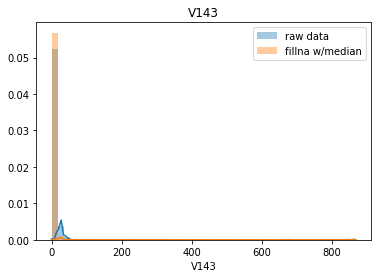

*** V144
count    81951.000000
mean         3.708484
std         10.485633
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         62.000000
Name: V144, dtype: float64


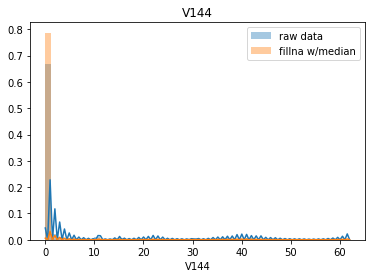

*** V145
count    81951.000000
mean        22.112946
std         64.371860
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        297.000000
Name: V145, dtype: float64


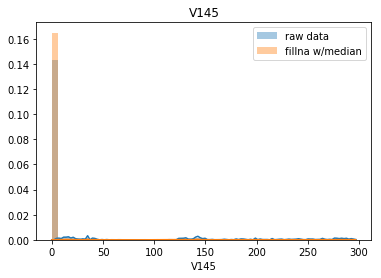

*** V146
count    81945.000000
mean         0.156276
std          0.682328
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: V146, dtype: float64


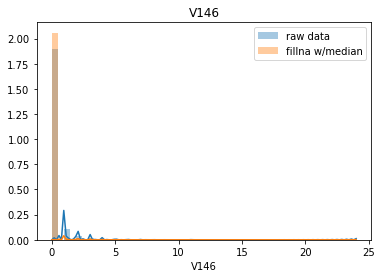

*** V147
count    81945.000000
mean         0.168601
std          0.750497
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         26.000000
Name: V147, dtype: float64


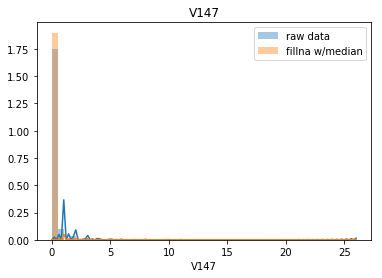

*** V148
count    81945.000000
mean         0.765001
std          0.581425
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: V148, dtype: float64


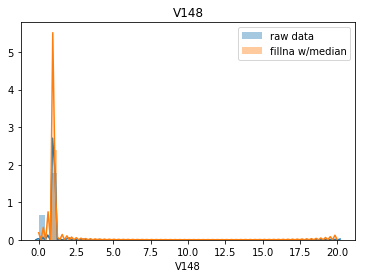

*** V149
count    81945.000000
mean         0.775313
std          0.628191
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         20.000000
Name: V149, dtype: float64


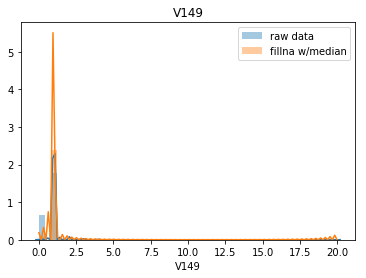

*** V150
count    81951.000000
mean       277.598028
std        829.576922
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max       3389.000000
Name: V150, dtype: float64


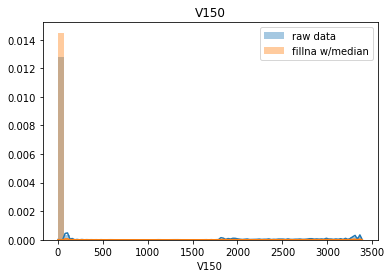

*** V151
count    81951.000000
mean         6.460190
std         15.232324
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         57.000000
Name: V151, dtype: float64


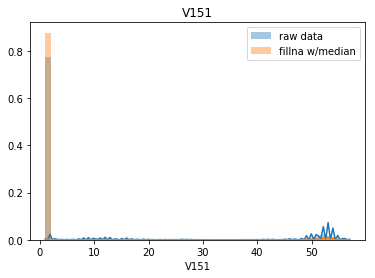

*** V152
count    81951.000000
mean         9.432710
std         21.554486
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         69.000000
Name: V152, dtype: float64


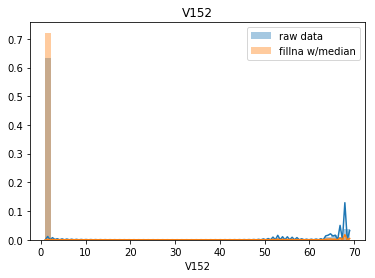

*** V153
count    81945.000000
mean         0.753200
std          0.532649
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         18.000000
Name: V153, dtype: float64


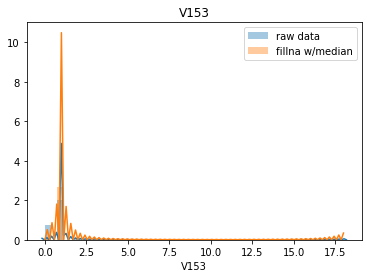

*** V154
count    81945.000000
mean         0.757423
std          0.546907
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         18.000000
Name: V154, dtype: float64


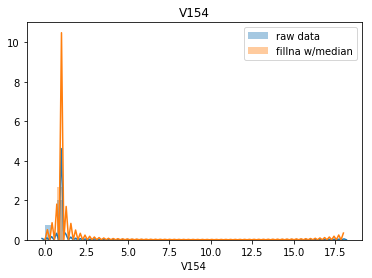

*** V155
count    81945.000000
mean         0.767381
std          0.602678
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: V155, dtype: float64


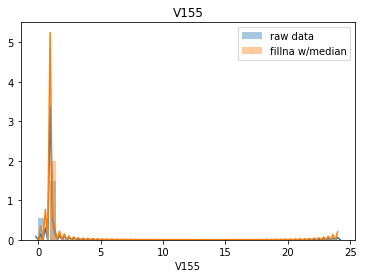

*** V156
count    81945.000000
mean         0.777485
std          0.647209
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: V156, dtype: float64


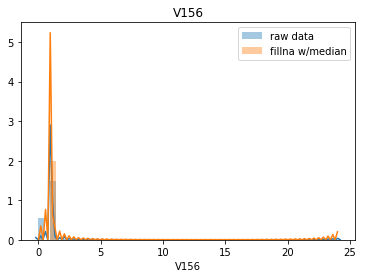

*** V157
count    81945.000000
mean         0.817573
std          0.682016
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: V157, dtype: float64


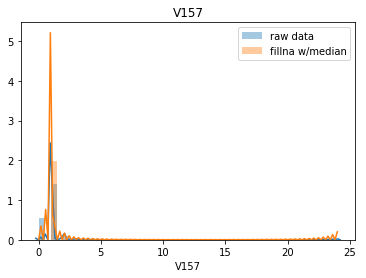

*** V158
count    81945.000000
mean         0.833461
std          0.734336
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: V158, dtype: float64


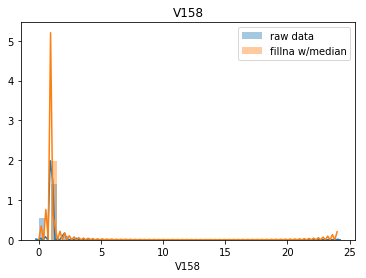

*** V159
count    81951.000000
mean      2719.299775
std       8355.445049
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      55125.000000
Name: V159, dtype: float64


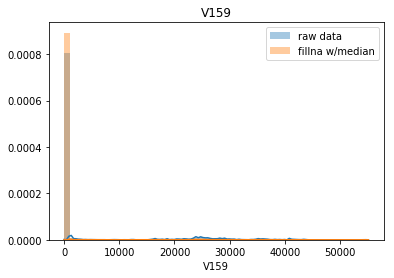

*** V160
count     81951.000000
mean      47453.181173
std      142076.069162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      641511.437500
Name: V160, dtype: float64


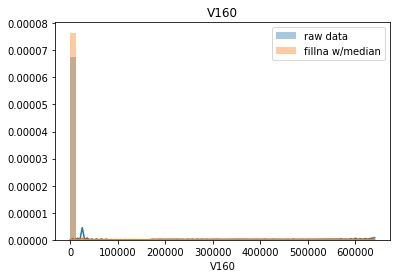

*** V161
count    81945.000000
mean         4.843938
std         58.929757
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3300.000000
Name: V161, dtype: float64


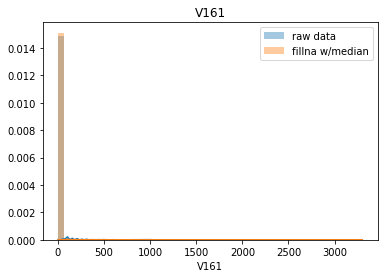

*** V162
count    81945.000000
mean         6.594661
std         69.195180
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3300.000000
Name: V162, dtype: float64


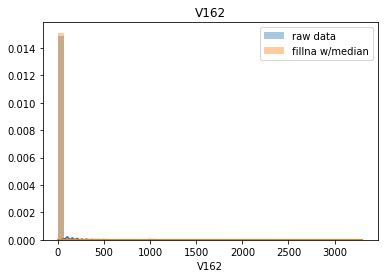

*** V163
count    81945.000000
mean         5.505955
std         63.077887
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       3300.000000
Name: V163, dtype: float64


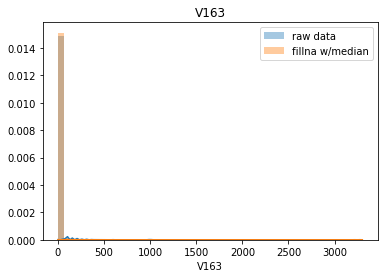

*** V164
count    81951.000000
mean       877.888928
std       6049.166505
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      93736.000000
Name: V164, dtype: float64


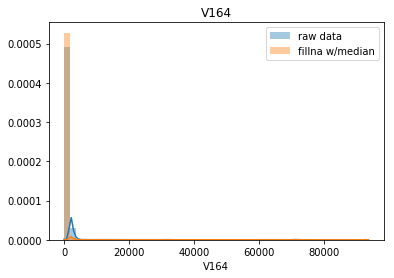

*** V165
count    81951.000000
mean      2239.912219
std       8223.258928
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      98476.000000
Name: V165, dtype: float64


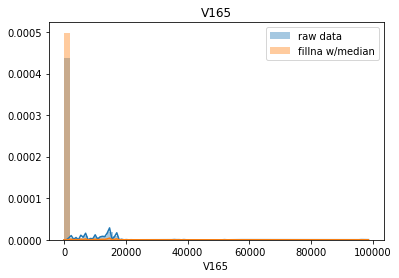

*** V166
count     81951.000000
mean        359.469437
std        1244.463270
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V166, dtype: float64


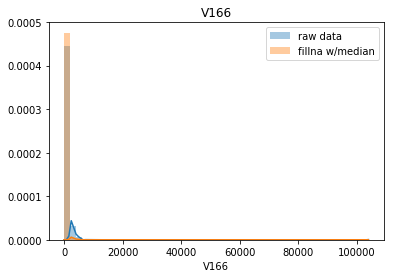

*** V167
count    139631.000000
mean          3.929514
std          42.200980
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         872.000000
Name: V167, dtype: float64


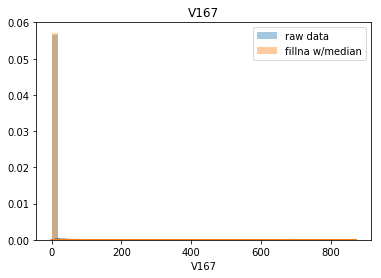

*** V168
count    139631.000000
mean          5.859501
std          54.032468
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         964.000000
Name: V168, dtype: float64


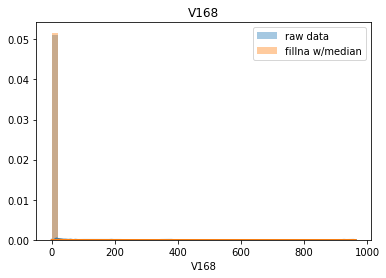

*** V169
count    139819.000000
mean          0.168053
std           0.904944
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: V169, dtype: float64


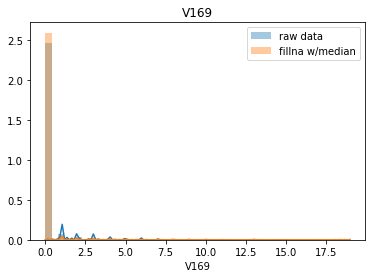

*** V170
count    139819.000000
mean          1.436779
std           1.751143
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          48.000000
Name: V170, dtype: float64


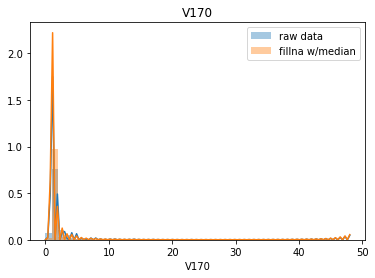

*** V171
count    139819.000000
mean          1.690908
std           2.444748
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          61.000000
Name: V171, dtype: float64


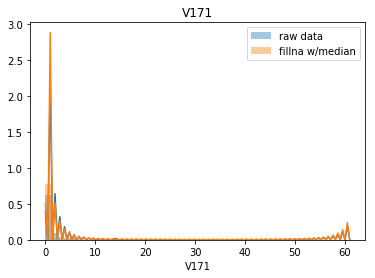

*** V172
count    139631.000000
mean          0.132012
std           0.924894
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: V172, dtype: float64


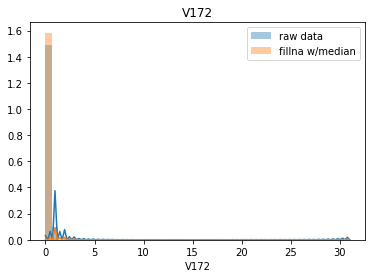

*** V173
count    139631.000000
mean          0.055231
std           0.264439
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: V173, dtype: float64


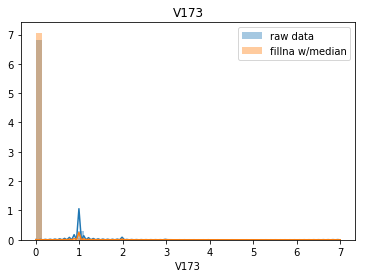

*** V174
count    139819.000000
mean          0.127794
std           0.379763
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V174, dtype: float64


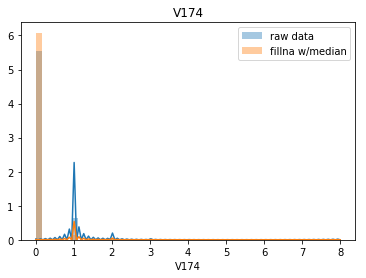

*** V175
count    139819.000000
mean          0.212639
std           0.857133
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          14.000000
Name: V175, dtype: float64


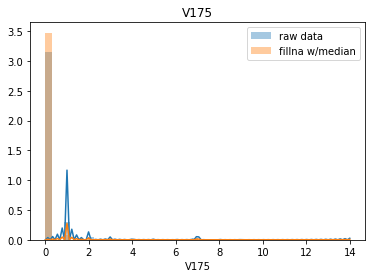

*** V176
count    139631.000000
mean          1.376979
std           1.829420
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          48.000000
Name: V176, dtype: float64


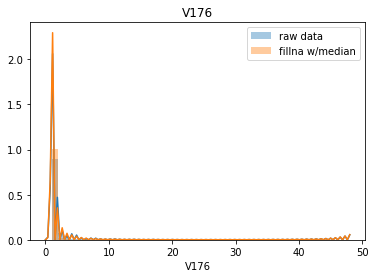

*** V177
count    139631.000000
mean          3.529245
std          41.310622
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         861.000000
Name: V177, dtype: float64


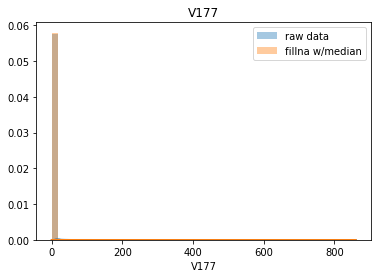

*** V178
count    139631.000000
mean          6.649283
std          69.447364
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1235.000000
Name: V178, dtype: float64


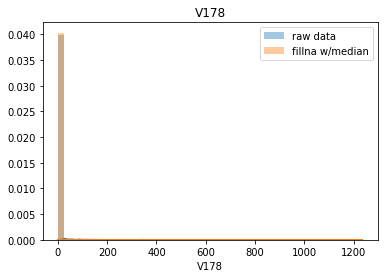

*** V179
count    139631.000000
mean          4.869012
std          50.489426
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         920.000000
Name: V179, dtype: float64


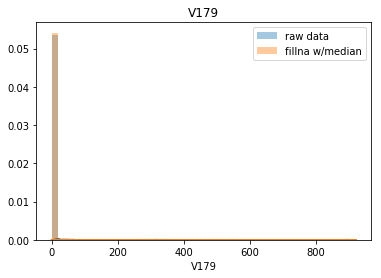

*** V180
count    139819.000000
mean          0.924123
std           6.112630
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          83.000000
Name: V180, dtype: float64


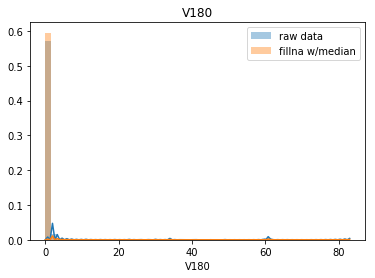

*** V181
count    139631.000000
mean          0.253332
std           1.248974
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          24.000000
Name: V181, dtype: float64


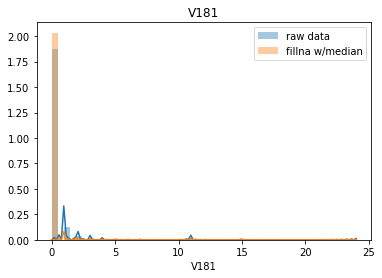

*** V182
count    139631.000000
mean          0.856243
std           5.792934
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          83.000000
Name: V182, dtype: float64


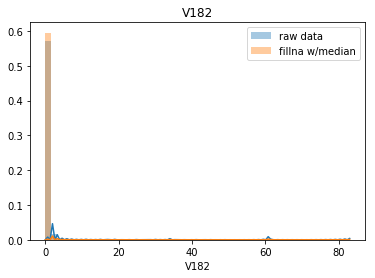

*** V183
count    139631.000000
mean          0.484692
std           2.946982
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          41.000000
Name: V183, dtype: float64


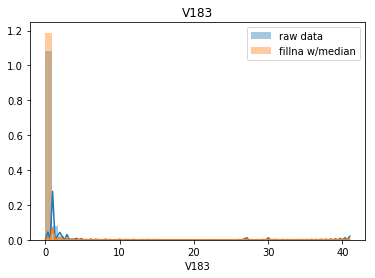

*** V184
count    139819.000000
mean          0.132364
std           0.543699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V184, dtype: float64


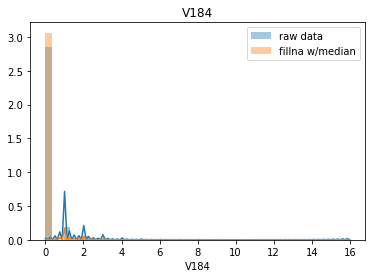

*** V185
count    139819.000000
mean          0.173903
std           0.699733
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: V185, dtype: float64


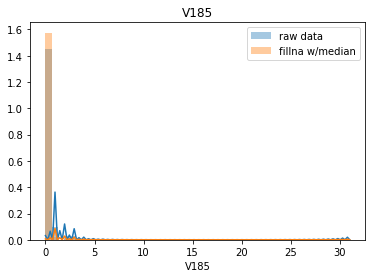

*** V186
count    139631.000000
mean          1.148799
std           1.223529
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          38.000000
Name: V186, dtype: float64


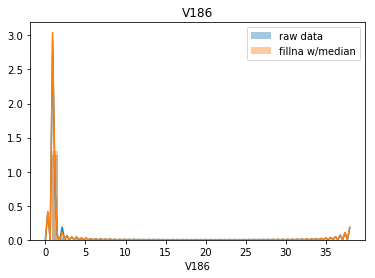

*** V187
count    139631.000000
mean          1.843752
std           9.884390
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         218.000000
Name: V187, dtype: float64


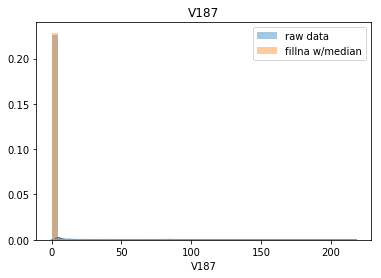

*** V188
count    139819.000000
mean          1.014755
std           0.671207
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: V188, dtype: float64


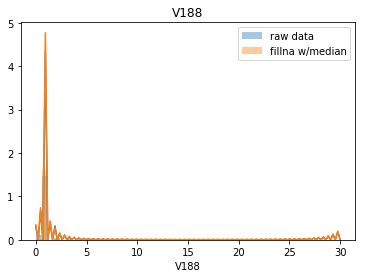

*** V189
count    139819.000000
mean          1.038314
std           0.792528
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: V189, dtype: float64


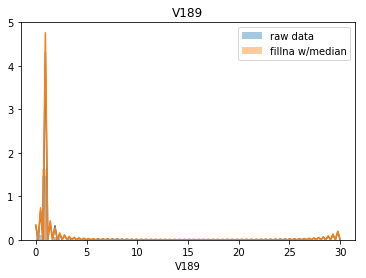

*** V190
count    139631.000000
mean          1.213083
std           1.480318
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          42.000000
Name: V190, dtype: float64


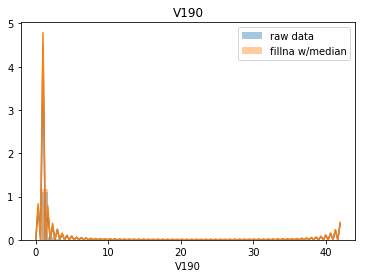

*** V191
count    139631.000000
mean          1.058984
std           0.677527
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          21.000000
Name: V191, dtype: float64


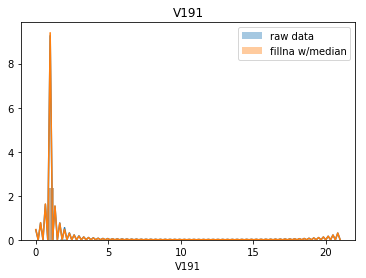

*** V192
count    139631.000000
mean          1.237361
std           2.635961
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          44.000000
Name: V192, dtype: float64


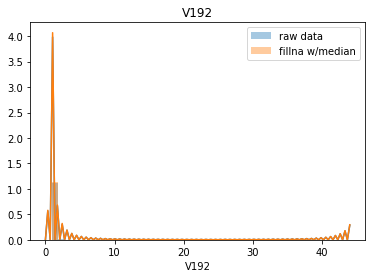

*** V193
count    139631.000000
mean          1.149845
std           1.714792
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          37.000000
Name: V193, dtype: float64


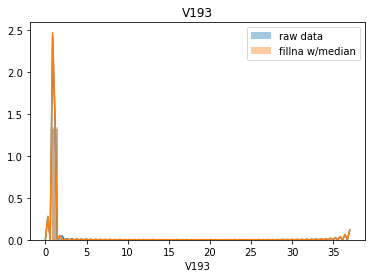

*** V194
count    139819.000000
mean          0.945773
std           0.304158
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V194, dtype: float64


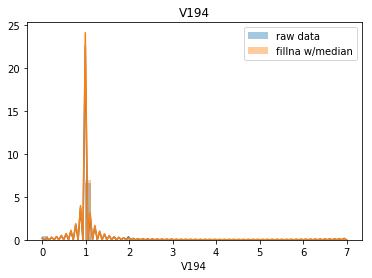

*** V195
count    139819.000000
mean          0.954227
std           0.376420
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: V195, dtype: float64


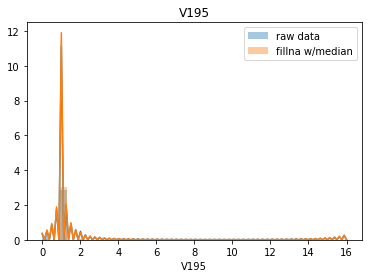

*** V196
count    139631.000000
mean          1.084580
std           1.105834
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          38.000000
Name: V196, dtype: float64


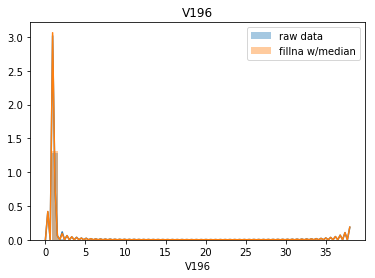

*** V197
count    139819.000000
mean          0.949385
std           0.336871
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          14.000000
Name: V197, dtype: float64


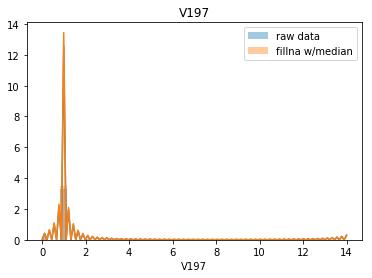

*** V198
count    139819.000000
mean          0.961951
std           0.493065
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          21.000000
Name: V198, dtype: float64


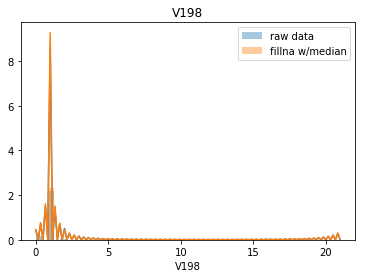

*** V199
count    139631.000000
mean          1.270749
std           1.671863
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: V199, dtype: float64


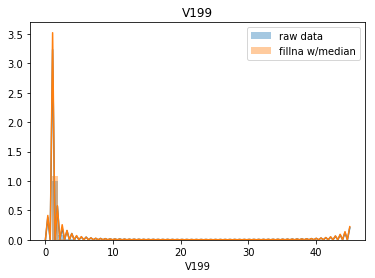

*** V200
count    139819.000000
mean          1.119977
std           1.253853
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: V200, dtype: float64


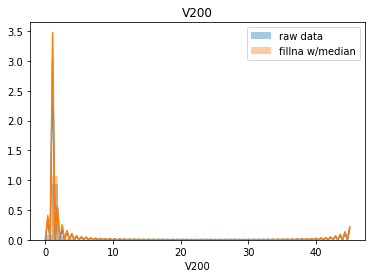

*** V201
count    139819.000000
mean          1.159106
std           1.418618
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          55.000000
Name: V201, dtype: float64


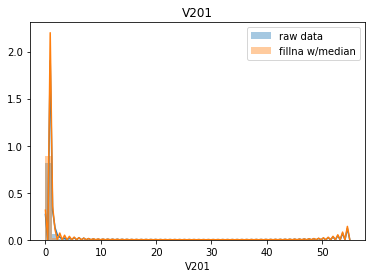

*** V202
count    139631.000000
mean        444.147142
std        4683.828419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V202, dtype: float64


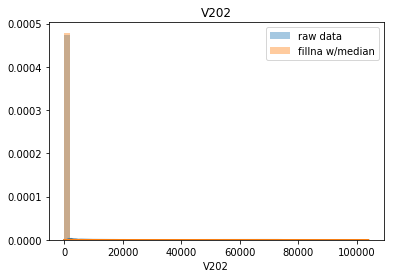

*** V203
count    139631.000000
mean       1078.327538
std        9105.607991
min           0.000000
25%           0.000000
50%           0.000000
75%          30.924400
max      139777.000000
Name: V203, dtype: float64


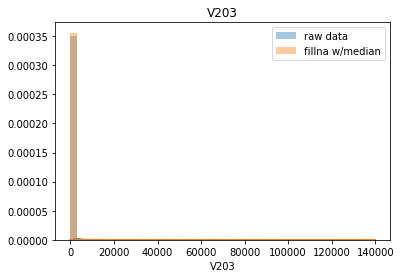

*** V204
count    139631.000000
mean        686.956931
std        6048.980716
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      104060.000000
Name: V204, dtype: float64


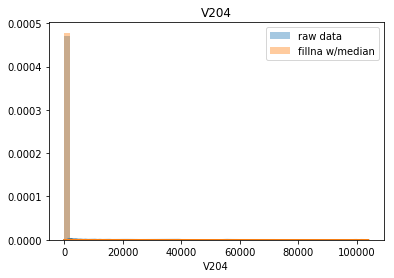

*** V205
count    139631.000000
mean         18.060417
std         266.545451
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V205, dtype: float64


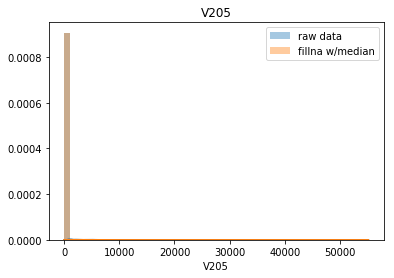

*** V206
count    139631.000000
mean          6.189360
std         191.474014
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V206, dtype: float64


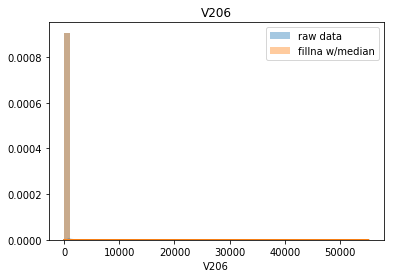

*** V207
count    139631.000000
mean         72.284098
std         925.676660
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V207, dtype: float64


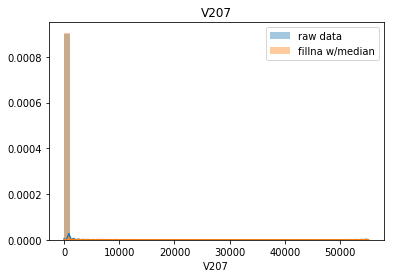

*** V208
count    139819.000000
mean          8.888193
std          59.047125
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3300.000000
Name: V208, dtype: float64


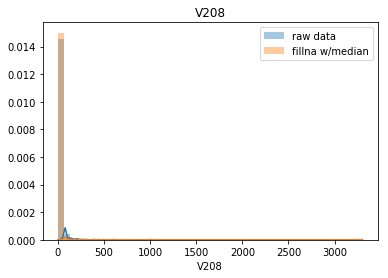

*** V209
count    139819.000000
mean         35.001872
std         250.800822
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        8050.000000
Name: V209, dtype: float64


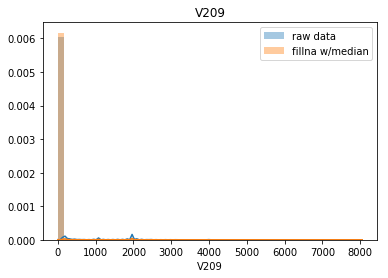

*** V210
count    139819.000000
mean         14.391835
std          86.523724
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        3300.000000
Name: V210, dtype: float64


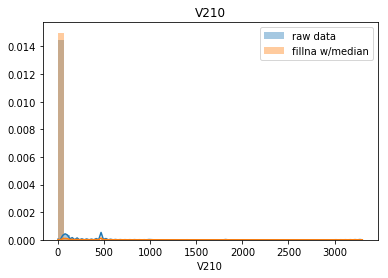

*** V211
count    139631.000000
mean        385.137037
std        4541.837915
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       92888.000000
Name: V211, dtype: float64


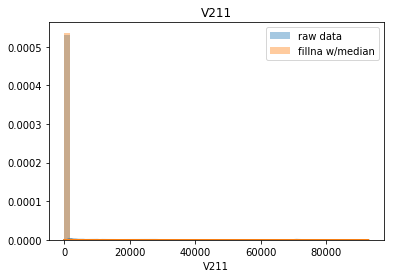

*** V212
count    139631.000000
mean        765.988339
std        7496.120737
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      129006.000000
Name: V212, dtype: float64


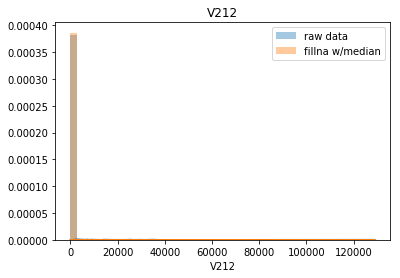

*** V213
count    139631.000000
mean        536.302802
std        5471.664736
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       97628.000000
Name: V213, dtype: float64


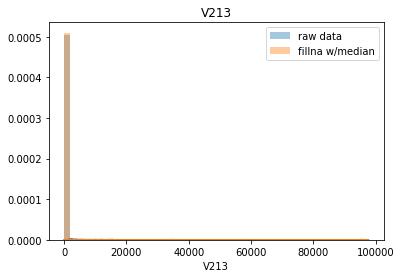

*** V214
count    139631.000000
mean         38.437547
std         571.834283
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V214, dtype: float64


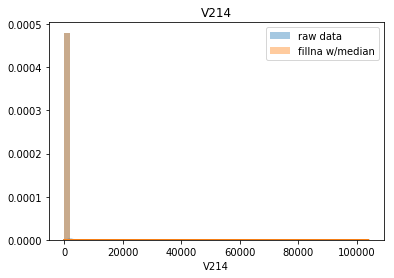

*** V215
count    139631.000000
mean        133.208217
std        1040.453748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V215, dtype: float64


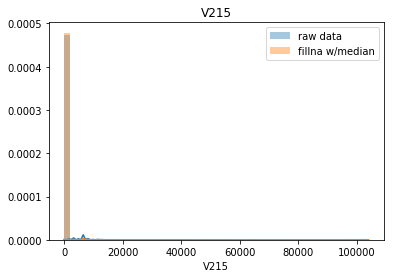

*** V216
count    139631.000000
mean         71.107143
std         680.267625
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V216, dtype: float64


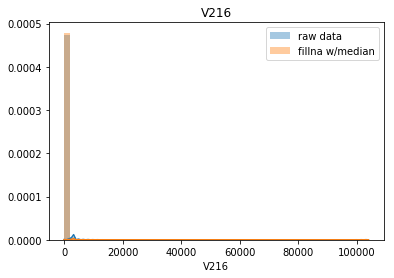

*** V217
count    130430.000000
mean          1.054619
std           9.547354
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         303.000000
Name: V217, dtype: float64


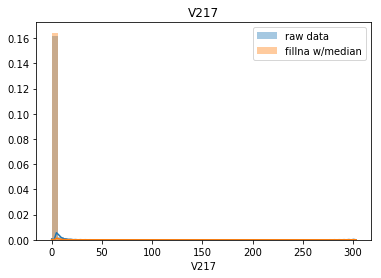

*** V218
count    130430.000000
mean          1.725784
std          13.919876
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         400.000000
Name: V218, dtype: float64


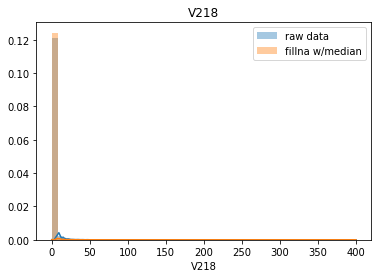

*** V219
count    130430.000000
mean          1.367132
std          12.044032
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         378.000000
Name: V219, dtype: float64


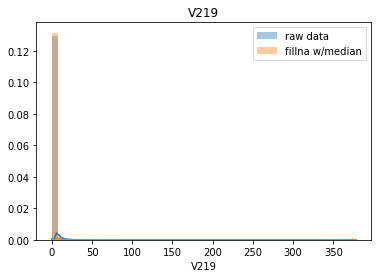

*** V220
count    141416.000000
mean          0.169472
std           1.002463
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          25.000000
Name: V220, dtype: float64


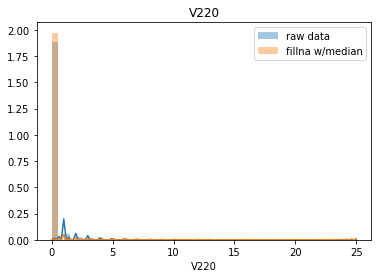

*** V221
count    141416.000000
mean          1.274912
std           2.728792
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         384.000000
Name: V221, dtype: float64


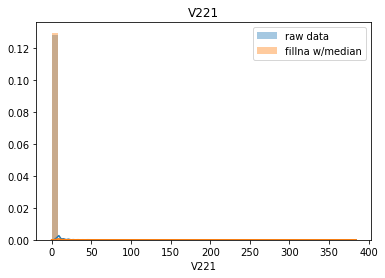

*** V222
count    141416.000000
mean          1.359005
std           2.913772
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         384.000000
Name: V222, dtype: float64


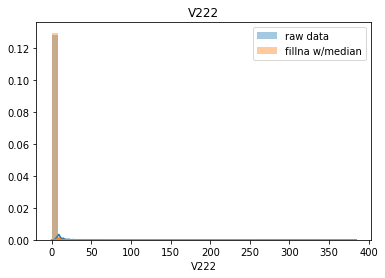

*** V223
count    130430.000000
mean          0.093153
std           0.402232
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V223, dtype: float64


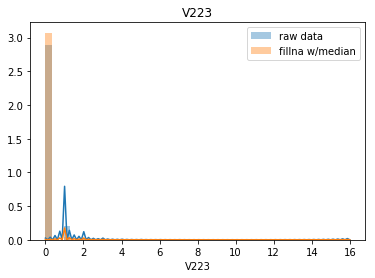

*** V224
count    130430.000000
mean          0.394748
std           3.443310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         144.000000
Name: V224, dtype: float64


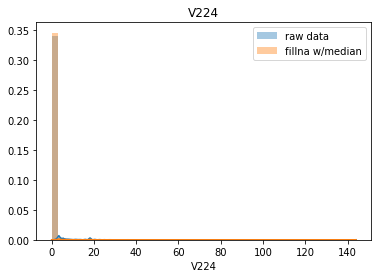

*** V225
count    130430.000000
mean          0.191758
std           1.290820
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          51.000000
Name: V225, dtype: float64


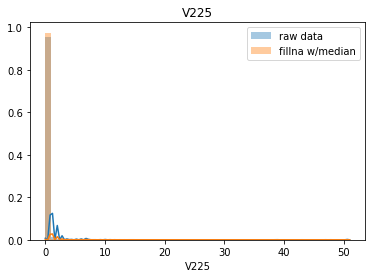

*** V226
count    130430.000000
mean          0.247612
std           2.756449
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         242.000000
Name: V226, dtype: float64


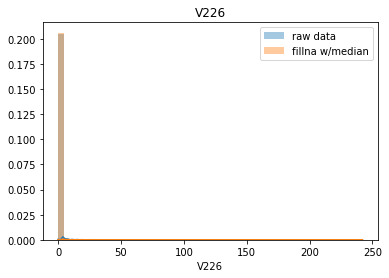

*** V227
count    141416.000000
mean          0.147975
std           2.049363
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         360.000000
Name: V227, dtype: float64


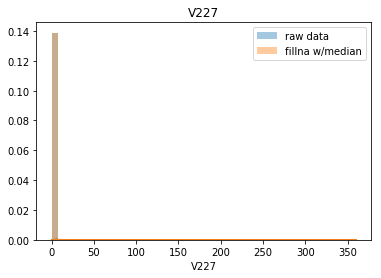

*** V228
count    130430.000000
mean          1.351928
std           1.409722
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          54.000000
Name: V228, dtype: float64


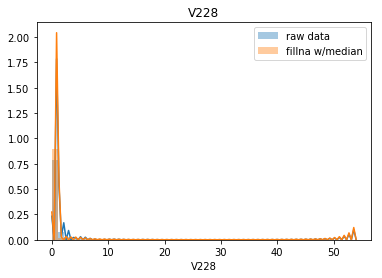

*** V229
count    130430.000000
mean          1.638710
std           4.316026
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         176.000000
Name: V229, dtype: float64


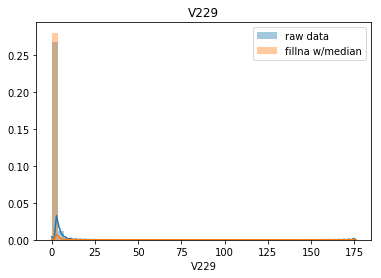

*** V230
count    130430.000000
mean          1.465476
std           2.122783
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          65.000000
Name: V230, dtype: float64


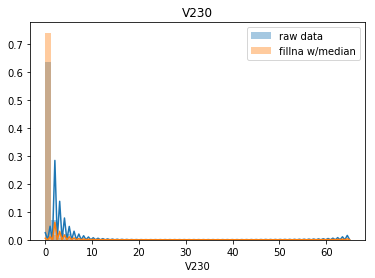

*** V231
count    130430.000000
mean          0.765506
std           8.877119
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         293.000000
Name: V231, dtype: float64


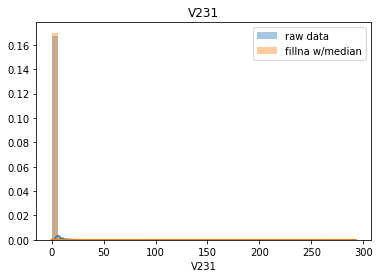

*** V232
count    130430.000000
mean          1.005597
std          10.460253
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         337.000000
Name: V232, dtype: float64


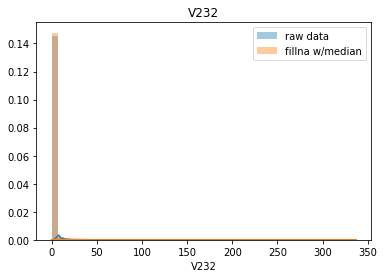

*** V233
count    130430.000000
mean          0.908388
std          10.149884
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         332.000000
Name: V233, dtype: float64


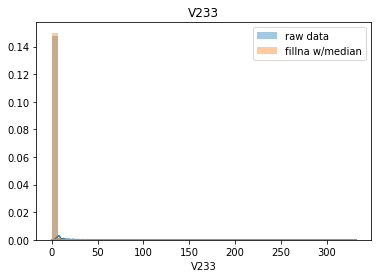

*** V234
count    141416.000000
mean          2.092847
std          11.323036
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         121.000000
Name: V234, dtype: float64


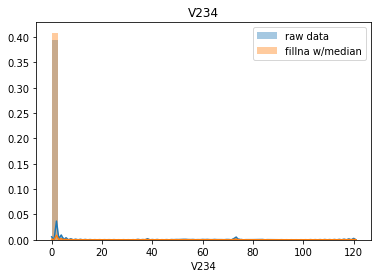

*** V235
count    130430.000000
mean          0.184106
std           0.902639
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.000000
Name: V235, dtype: float64


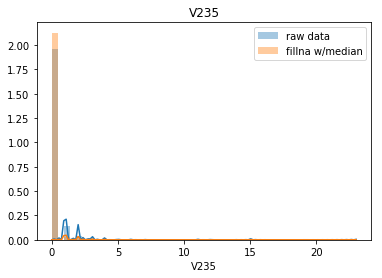

*** V236
count    130430.000000
mean          0.307667
std           2.152332
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          45.000000
Name: V236, dtype: float64


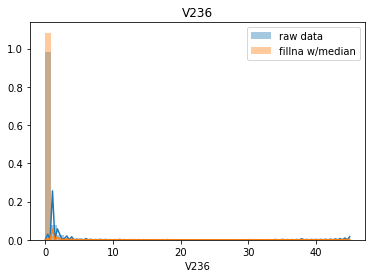

*** V237
count    130430.000000
mean          0.253500
std           1.716634
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          39.000000
Name: V237, dtype: float64


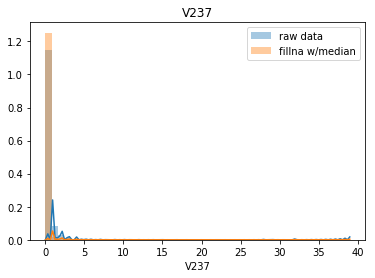

*** V238
count    141416.000000
mean          0.127956
std           0.574657
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.000000
Name: V238, dtype: float64


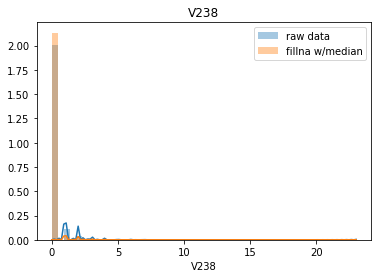

*** V239
count    141416.000000
mean          0.136965
std           0.616260
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.000000
Name: V239, dtype: float64


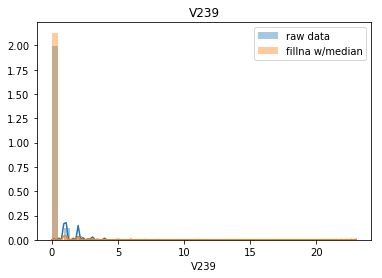

*** V240
count    130430.000000
mean          1.000997
std           0.049522
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           7.000000
Name: V240, dtype: float64


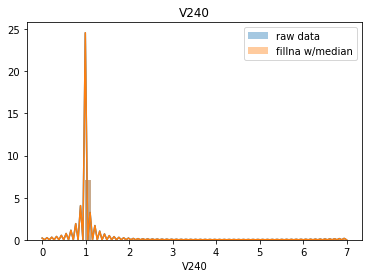

*** V241
count    130430.000000
mean          1.000238
std           0.022663
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: V241, dtype: float64


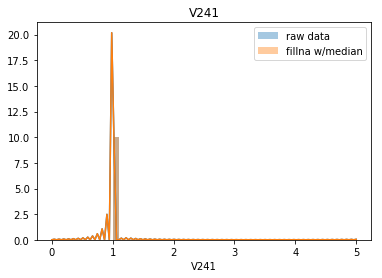

*** V242
count    130430.000000
mean          1.113463
std           0.660110
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: V242, dtype: float64


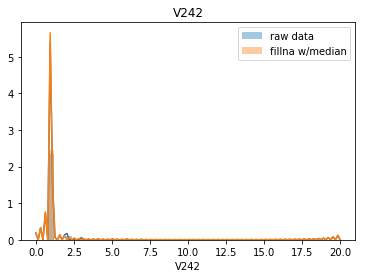

*** V243
count    130430.000000
mean          1.178387
std           1.398953
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          57.000000
Name: V243, dtype: float64


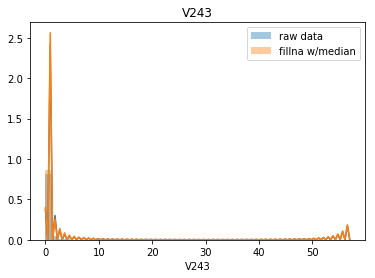

*** V244
count    130430.000000
mean          1.118562
std           0.698807
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          22.000000
Name: V244, dtype: float64


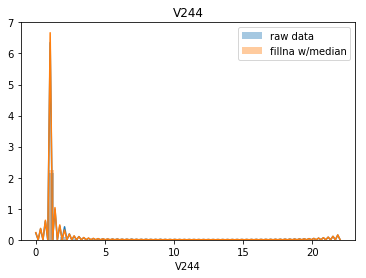

*** V245
count    141416.000000
mean          0.876619
std           1.821065
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         262.000000
Name: V245, dtype: float64


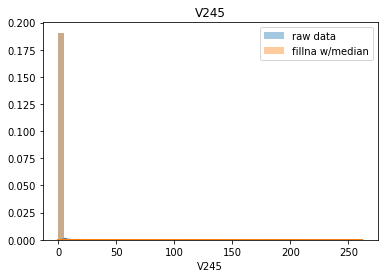

*** V246
count    130430.000000
mean          1.183723
std           1.040363
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          45.000000
Name: V246, dtype: float64


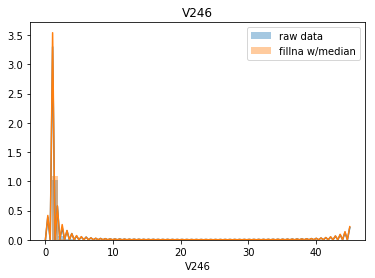

*** V247
count    130430.000000
mean          1.025355
std           0.281604
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          18.000000
Name: V247, dtype: float64


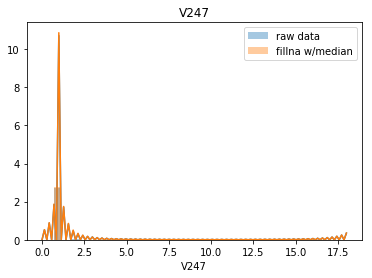

*** V248
count    130430.000000
mean          1.069493
std           0.888341
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          36.000000
Name: V248, dtype: float64


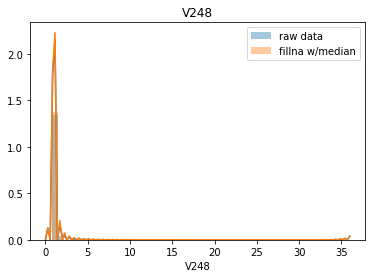

*** V249
count    130430.000000
mean          1.042851
std           0.528812
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          22.000000
Name: V249, dtype: float64


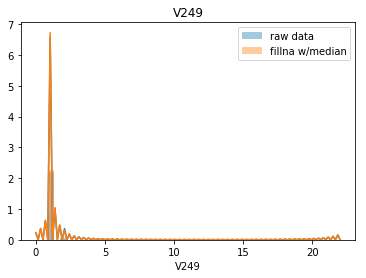

*** V250
count    141416.000000
mean          0.788588
std           0.488386
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          18.000000
Name: V250, dtype: float64


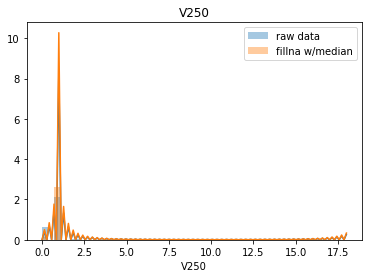

*** V251
count    141416.000000
mean          0.794231
std           0.501240
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          18.000000
Name: V251, dtype: float64


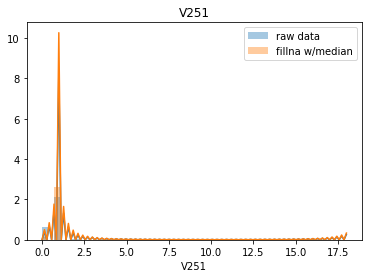

*** V252
count    130430.000000
mean          1.032048
std           0.389546
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          24.000000
Name: V252, dtype: float64


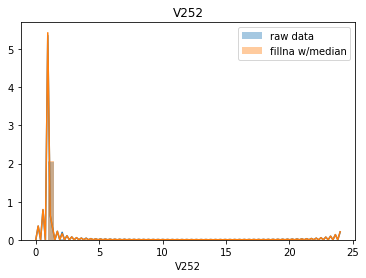

*** V253
count    130430.000000
mean          1.162164
std           3.612553
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         163.000000
Name: V253, dtype: float64


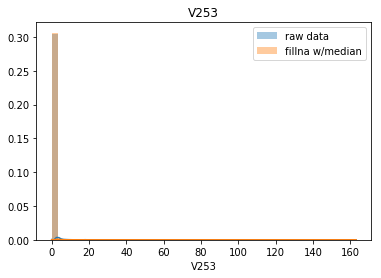

*** V254
count    130430.000000
mean          1.075113
std           1.357550
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          60.000000
Name: V254, dtype: float64


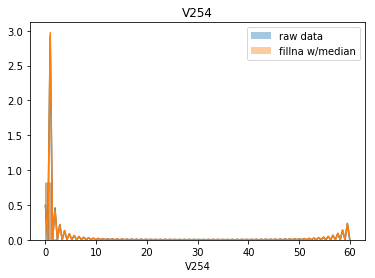

*** V255
count    141416.000000
mean          0.806656
std           0.939124
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          87.000000
Name: V255, dtype: float64


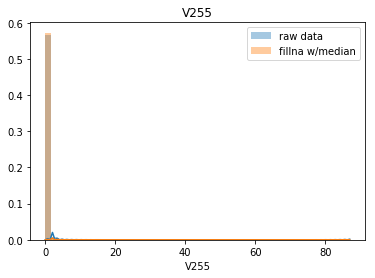

*** V256
count    141416.000000
mean          0.814950
std           0.969953
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          87.000000
Name: V256, dtype: float64


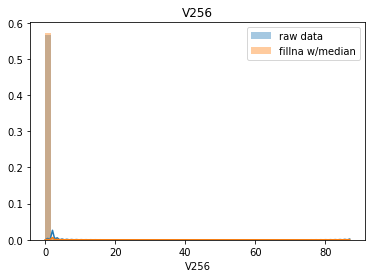

*** V257
count    130430.000000
mean          1.250993
std           1.299956
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          48.000000
Name: V257, dtype: float64


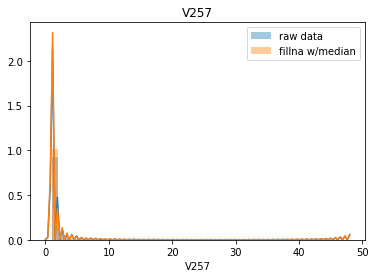

*** V258
count    130430.000000
mean          1.343510
std           2.015811
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          66.000000
Name: V258, dtype: float64


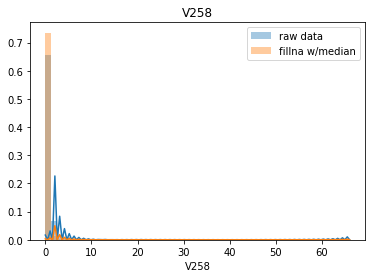

*** V259
count    141416.000000
mean          0.967832
std           2.113447
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         285.000000
Name: V259, dtype: float64


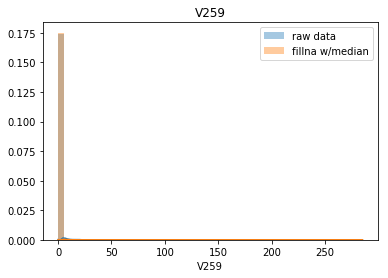

*** V260
count    130430.000000
mean          0.964425
std           0.379828
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V260, dtype: float64


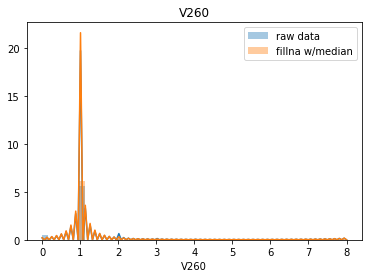

*** V261
count    130430.000000
mean          1.107161
std           1.323230
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          49.000000
Name: V261, dtype: float64


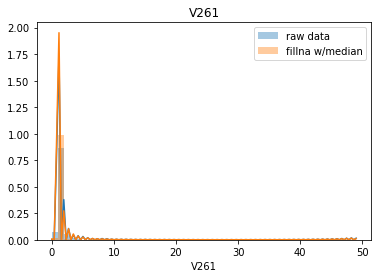

*** V262
count    130430.000000
mean          1.013279
std           0.625455
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          20.000000
Name: V262, dtype: float64


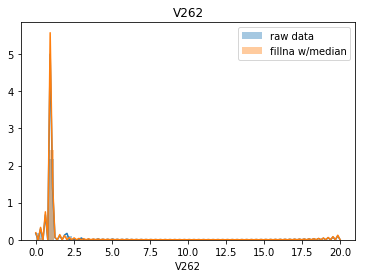

*** V263
count    130430.000000
mean        117.390676
std        1294.851543
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      153600.000000
Name: V263, dtype: float64


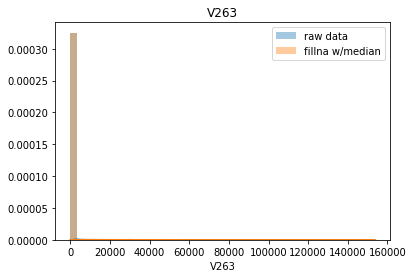

*** V264
count    130430.000000
mean        201.657617
std        2284.827492
min           0.000000
25%           0.000000
50%           0.000000
75%          33.593498
max      153600.000000
Name: V264, dtype: float64


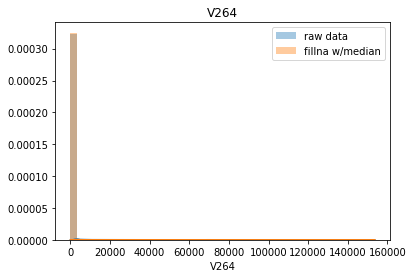

*** V265
count    130430.000000
mean        153.520534
std        1605.512276
min           0.000000
25%           0.000000
50%           0.000000
75%          20.897525
max      153600.000000
Name: V265, dtype: float64


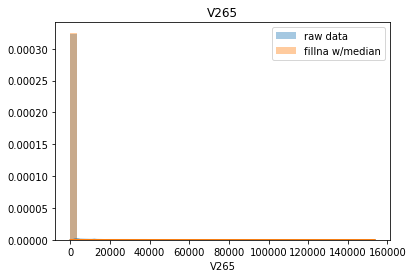

*** V266
count    130430.000000
mean          9.167839
std         208.038863
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V266, dtype: float64


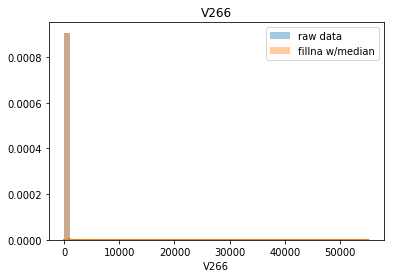

*** V267
count    130430.000000
mean         36.525103
std         644.878586
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V267, dtype: float64


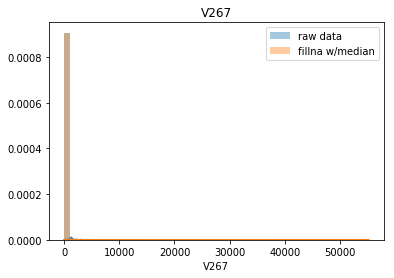

*** V268
count    130430.000000
mean         18.813407
std         311.280181
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V268, dtype: float64


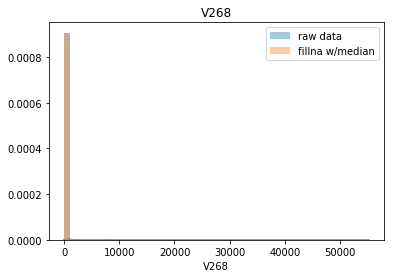

*** V269
count    130430.000000
mean          5.997508
std         207.317539
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V269, dtype: float64


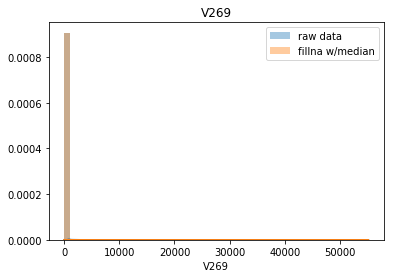

*** V270
count    141416.000000
mean          7.712764
std          65.507232
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: V270, dtype: float64


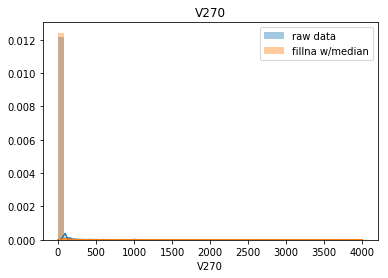

*** V271
count    141416.000000
mean          9.445133
std          74.147726
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: V271, dtype: float64


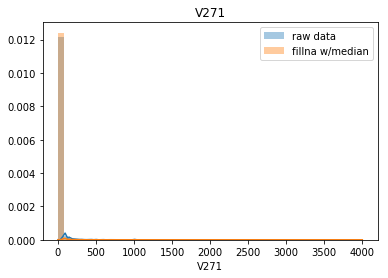

*** V272
count    141416.000000
mean          8.464571
std          69.723735
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: V272, dtype: float64


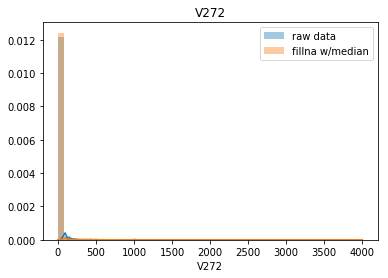

*** V273
count    130430.000000
mean         73.825549
std         935.187927
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       51200.000000
Name: V273, dtype: float64


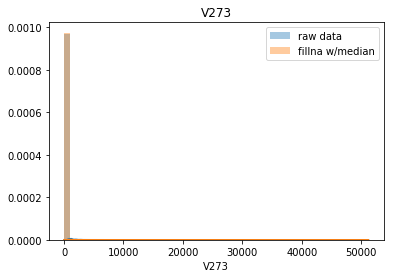

*** V274
count    130430.000000
mean        107.151636
std        1258.734139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       66000.000000
Name: V274, dtype: float64


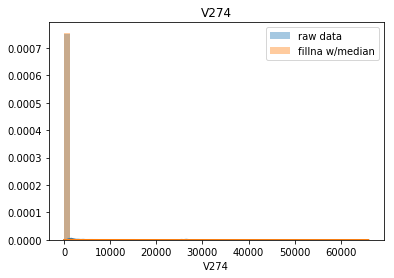

*** V275
count    130430.000000
mean         88.899939
std        1072.883139
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       51200.000000
Name: V275, dtype: float64


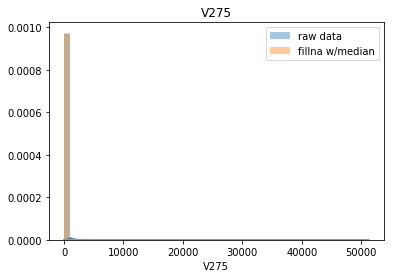

*** V276
count    130430.000000
mean         31.797277
std         615.659714
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V276, dtype: float64


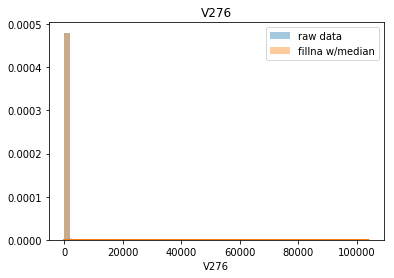

*** V277
count    130430.000000
mean         51.956645
std         732.145368
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V277, dtype: float64


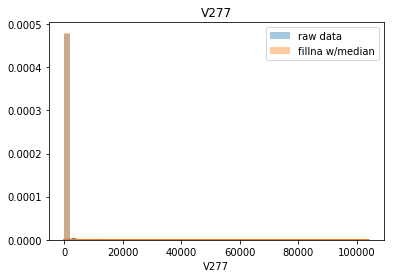

*** V278
count    130430.000000
mean         42.328228
std         660.611820
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V278, dtype: float64


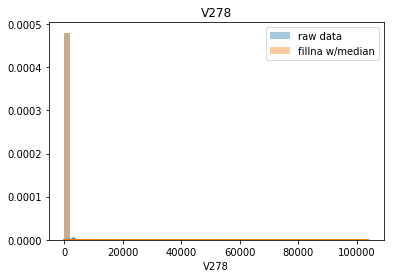

*** V279
count    590528.000000
mean          1.123061
std          21.021950
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         880.000000
Name: V279, dtype: float64


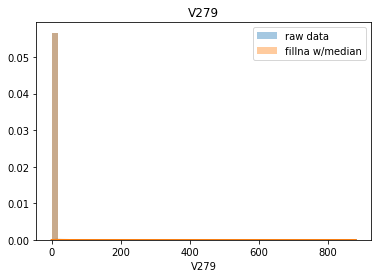

*** V280
count    590528.000000
mean          1.967082
std          27.851780
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         975.000000
Name: V280, dtype: float64


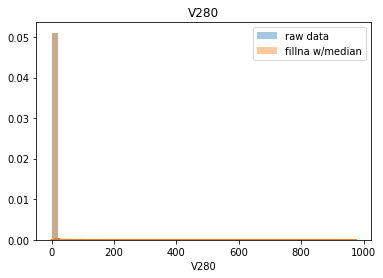

*** V281
count    589271.000000
mean          0.087783
std           0.512748
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          22.000000
Name: V281, dtype: float64


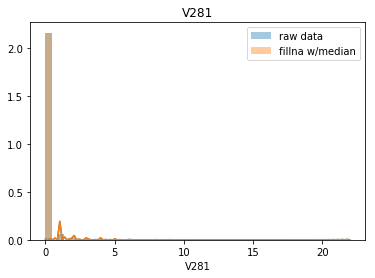

*** V282
count    589271.000000
mean          0.817171
std           0.921880
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          32.000000
Name: V282, dtype: float64


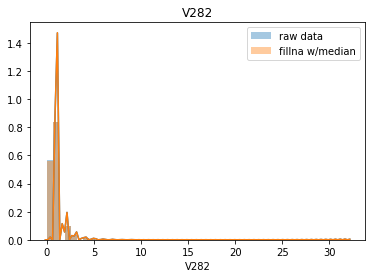

*** V283
count    589271.000000
mean          0.991114
std           1.558731
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          68.000000
Name: V283, dtype: float64


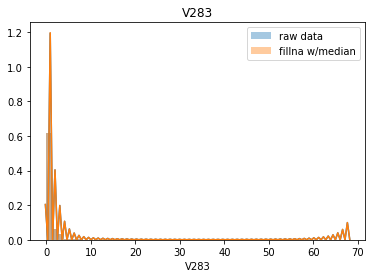

*** V284
count    590528.000000
mean          0.088543
std           0.338424
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V284, dtype: float64


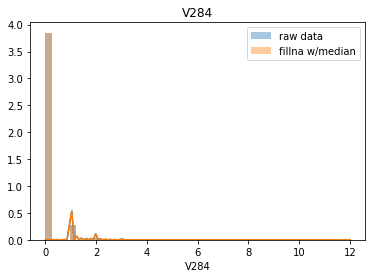

*** V285
count    590528.000000
mean          1.167660
std           3.282454
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          95.000000
Name: V285, dtype: float64


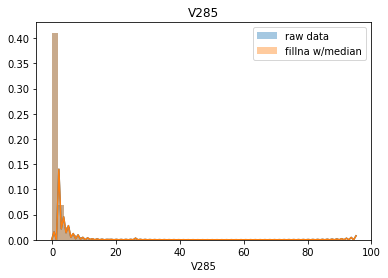

*** V286
count    590528.000000
mean          0.031492
std           0.190939
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V286, dtype: float64


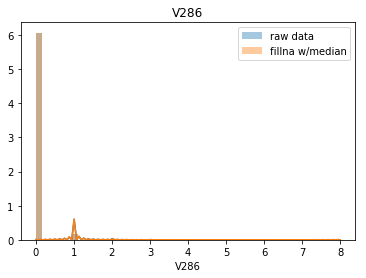

*** V287
count    590528.000000
mean          0.358579
std           1.078995
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: V287, dtype: float64


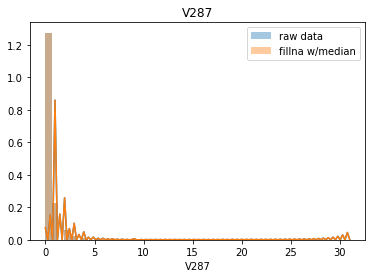

*** V288
count    589271.000000
mean          0.184350
std           0.430989
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          10.000000
Name: V288, dtype: float64


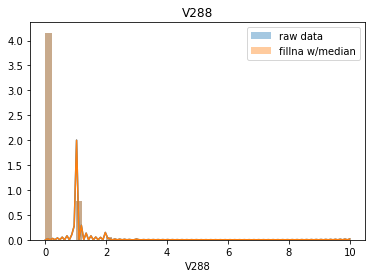

*** V289
count    589271.000000
mean          0.235975
std           0.599231
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V289, dtype: float64


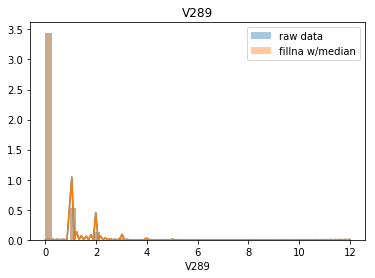

*** V290
count    590528.000000
mean          1.103011
std           0.768897
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          67.000000
Name: V290, dtype: float64


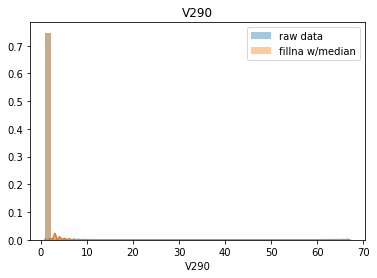

*** V291
count    590528.000000
mean          1.659811
std          16.252538
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1055.000000
Name: V291, dtype: float64


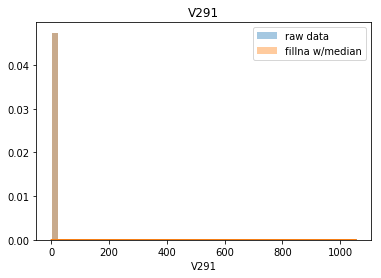

*** V292
count    590528.000000
mean          1.239916
std           3.775050
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         323.000000
Name: V292, dtype: float64


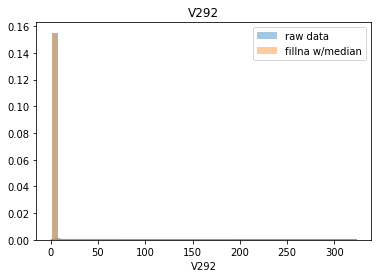

*** V293
count    590528.000000
mean          0.942599
std          20.588816
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         869.000000
Name: V293, dtype: float64


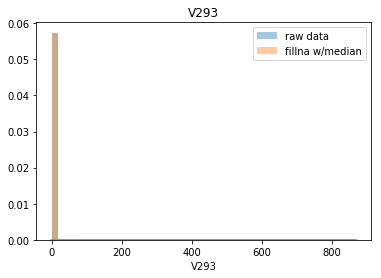

*** V294
count    590528.000000
mean          2.313863
std          39.526468
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1286.000000
Name: V294, dtype: float64


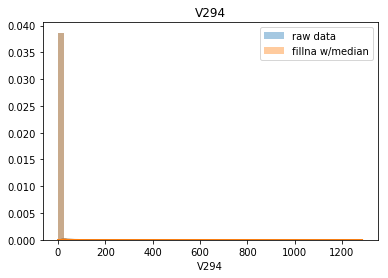

*** V295
count    590528.000000
mean          1.433424
std          25.962948
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         928.000000
Name: V295, dtype: float64


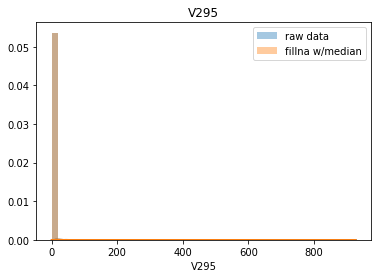

*** V296
count    589271.000000
mean          0.328917
std           3.264745
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          93.000000
Name: V296, dtype: float64


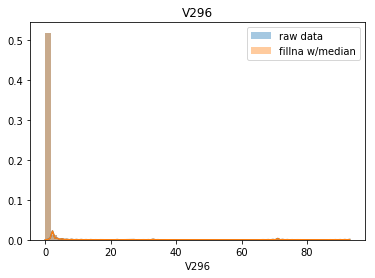

*** V297
count    590528.000000
mean          0.089034
std           0.628352
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          12.000000
Name: V297, dtype: float64


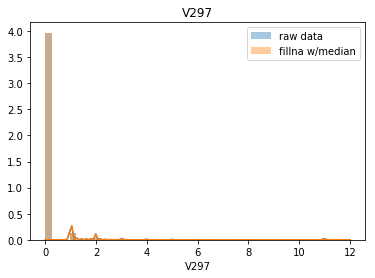

*** V298
count    590528.000000
mean          0.298829
std           3.175062
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          93.000000
Name: V298, dtype: float64


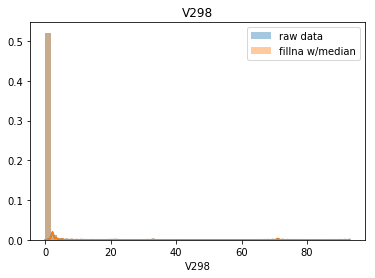

*** V299
count    590528.000000
mean          0.171655
std           1.724218
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          49.000000
Name: V299, dtype: float64


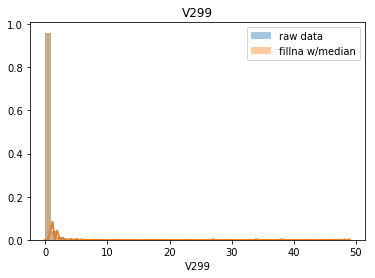

*** V300
count    589271.000000
mean          0.045507
std           0.289573
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          11.000000
Name: V300, dtype: float64


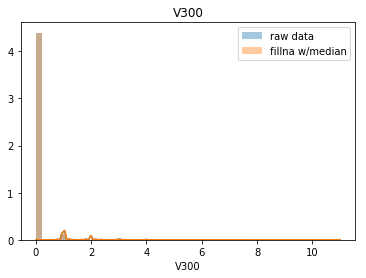

*** V301
count    589271.000000
mean          0.052002
std           0.318310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          13.000000
Name: V301, dtype: float64


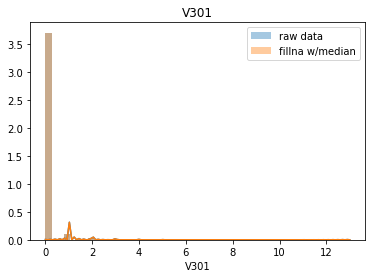

*** V302
count    590528.000000
mean          0.251761
std           0.481889
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V302, dtype: float64


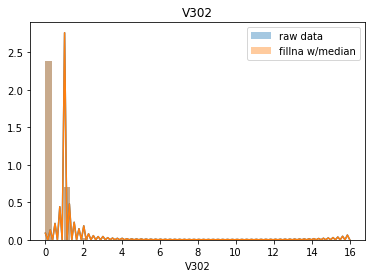

*** V303
count    590528.000000
mean          0.283140
std           0.623608
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: V303, dtype: float64


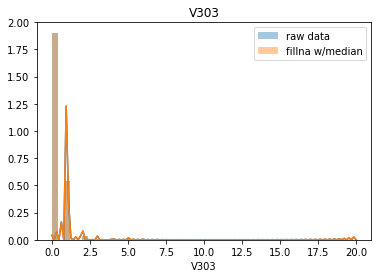

*** V304
count    590528.000000
mean          0.264208
std           0.528238
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: V304, dtype: float64


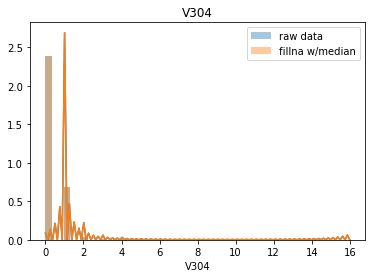

*** V305
count    590528.000000
mean          1.000007
std           0.002603
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: V305, dtype: float64


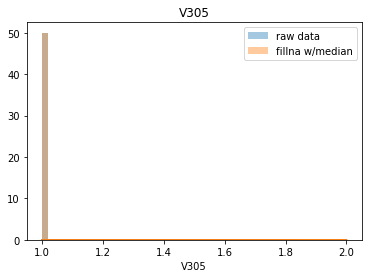

*** V306
count    590528.000000
mean        139.748713
std        2348.849634
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      108800.000000
Name: V306, dtype: float64


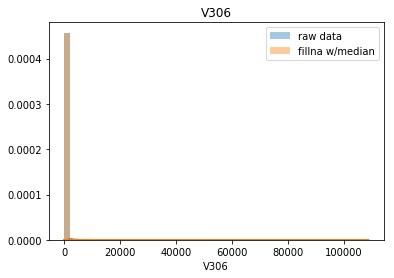

*** V307
count    590528.000000
mean        408.682375
std        4391.992977
min           0.000000
25%           0.000000
50%           0.000000
75%         151.380680
max      145765.000000
Name: V307, dtype: float64


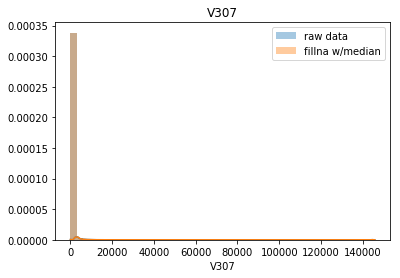

*** V308
count    590528.000000
mean        230.413180
std        3021.924247
min           0.000000
25%           0.000000
50%           0.000000
75%          35.970001
max      108800.000000
Name: V308, dtype: float64


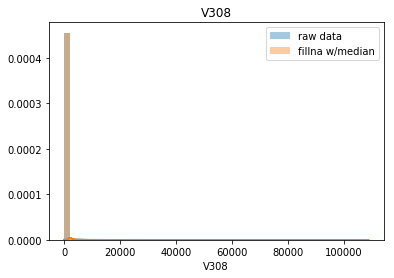

*** V309
count    590528.000000
mean         10.995986
std         116.254277
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V309, dtype: float64


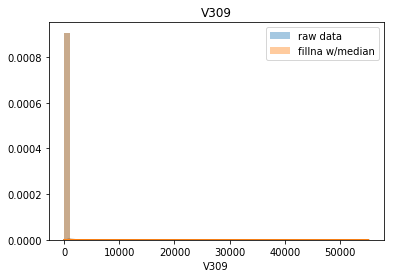

*** V310
count    590528.000000
mean        118.195658
std         352.983093
min           0.000000
25%           0.000000
50%           0.000000
75%         107.949997
max       55125.000000
Name: V310, dtype: float64


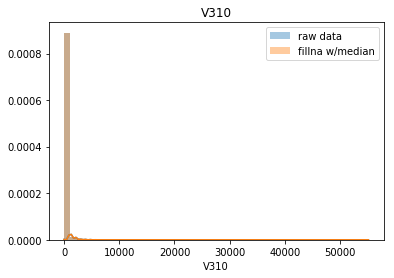

*** V311
count    590528.000000
mean          4.202175
std         102.374938
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V311, dtype: float64


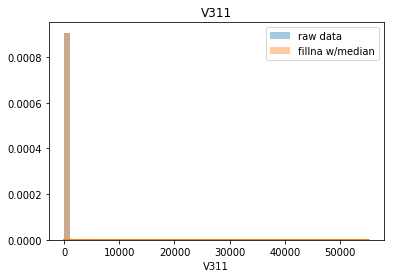

*** V312
count    590528.000000
mean         39.173910
std         172.128339
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       55125.000000
Name: V312, dtype: float64


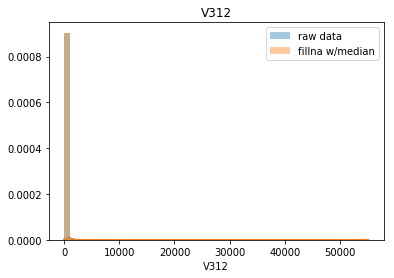

*** V313
count    589271.000000
mean         21.351473
std          95.902970
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4817.470215
Name: V313, dtype: float64


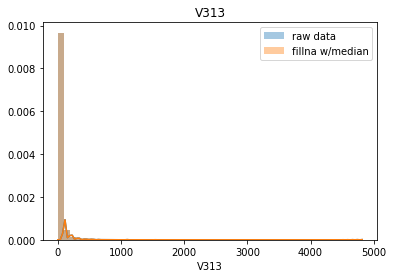

*** V314
count    589271.000000
mean         43.319174
std         173.619028
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        7519.870117
Name: V314, dtype: float64


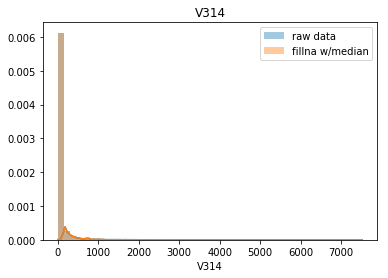

*** V315
count    589271.000000
mean         26.806977
std         116.853222
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4817.470215
Name: V315, dtype: float64


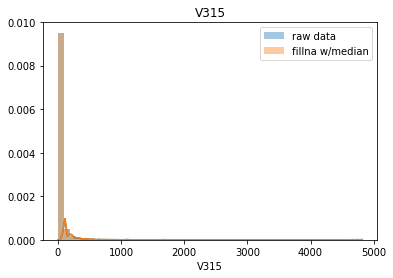

*** V316
count    590528.000000
mean        109.818544
std        2270.033202
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       93736.000000
Name: V316, dtype: float64


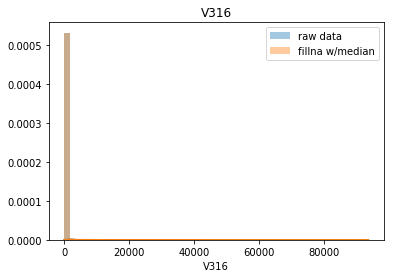

*** V317
count    590528.000000
mean        247.606741
std        3980.042828
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      134021.000000
Name: V317, dtype: float64


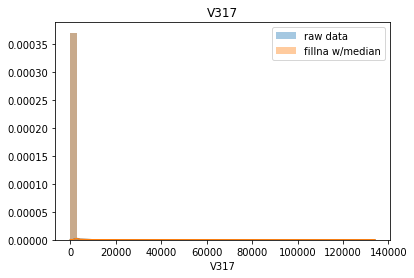

*** V318
count    590528.000000
mean        162.153398
std        2793.343636
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       98476.000000
Name: V318, dtype: float64


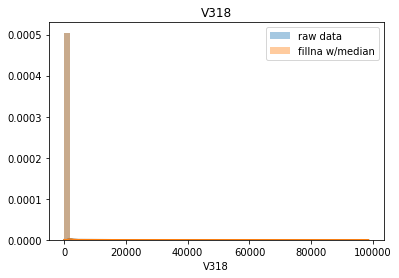

*** V319
count    590528.000000
mean         18.372476
std         332.304848
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V319, dtype: float64


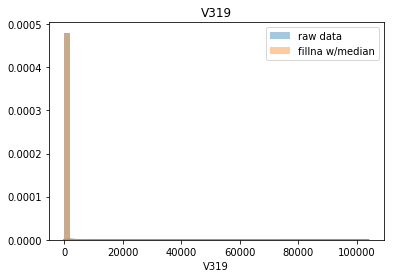

*** V320
count    590528.000000
mean         42.073133
std         473.499307
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V320, dtype: float64


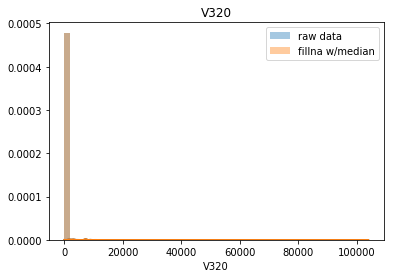

*** V321
count    590528.000000
mean         28.326584
std         382.053171
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V321, dtype: float64


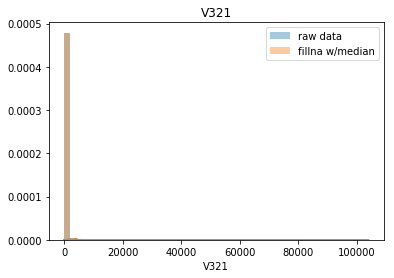

*** V322
count    82351.000000
mean         6.220289
std         56.022561
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        880.000000
Name: V322, dtype: float64


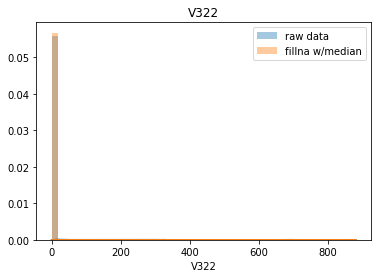

*** V323
count    82351.000000
mean        13.103775
std        106.739813
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max       1411.000000
Name: V323, dtype: float64


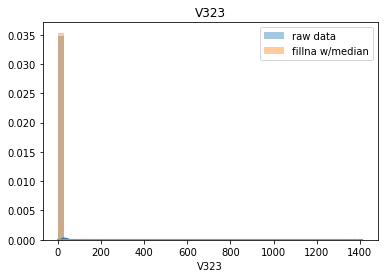

*** V324
count    82351.000000
mean         9.184612
std         73.627893
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        976.000000
Name: V324, dtype: float64


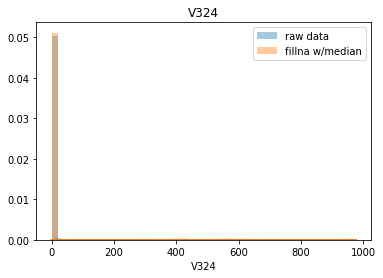

*** V325
count    82351.000000
mean         0.058494
std          0.304415
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: V325, dtype: float64


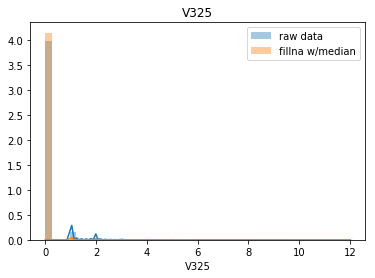

*** V326
count    82351.000000
mean         0.851040
std          3.950295
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         44.000000
Name: V326, dtype: float64


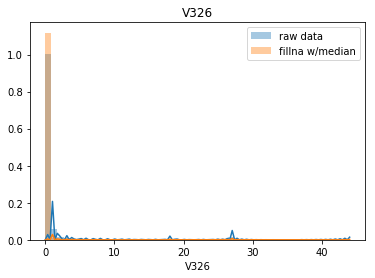

*** V327
count    82351.000000
mean         0.296633
std          1.364356
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: V327, dtype: float64


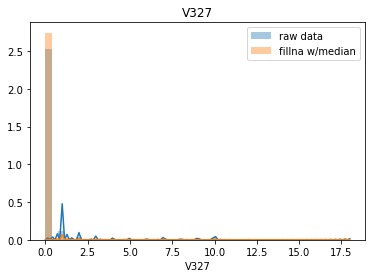

*** V328
count    82351.000000
mean         0.336790
std          1.580144
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: V328, dtype: float64


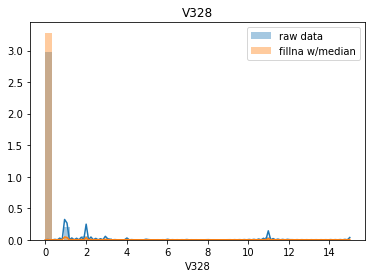

*** V329
count    82351.000000
mean         1.312844
std          8.769083
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         99.000000
Name: V329, dtype: float64


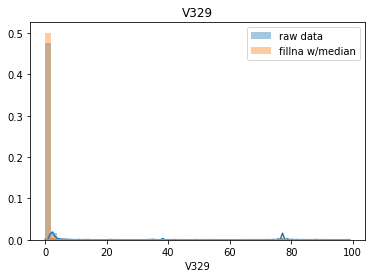

*** V330
count    82351.000000
mean         0.775874
std          4.727971
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: V330, dtype: float64


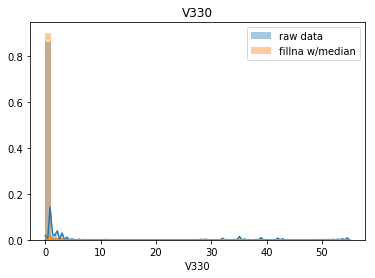

*** V331
count     82351.000000
mean        721.741883
std        6217.223583
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      160000.000000
Name: V331, dtype: float64


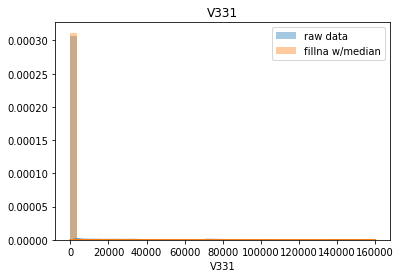

*** V332
count     82351.000000
mean       1375.783644
std       11169.275702
min           0.000000
25%           0.000000
50%           0.000000
75%          25.000000
max      160000.000000
Name: V332, dtype: float64


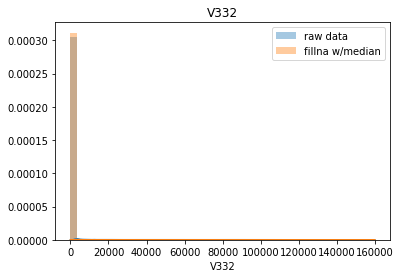

*** V333
count     82351.000000
mean       1014.622782
std        7955.735482
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      160000.000000
Name: V333, dtype: float64


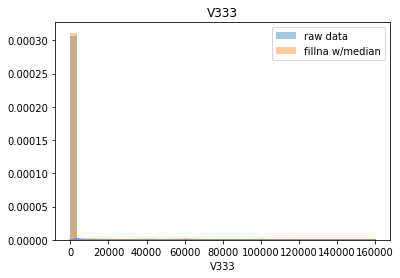

*** V334
count    82351.000000
mean         9.807015
std        243.861391
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      55125.000000
Name: V334, dtype: float64


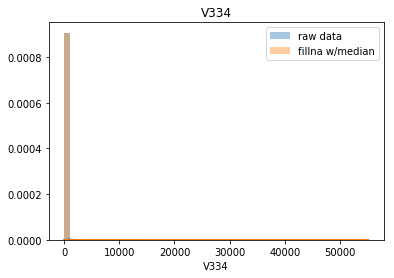

*** V335
count    82351.00000
mean        59.16455
std        387.62948
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max      55125.00000
Name: V335, dtype: float64


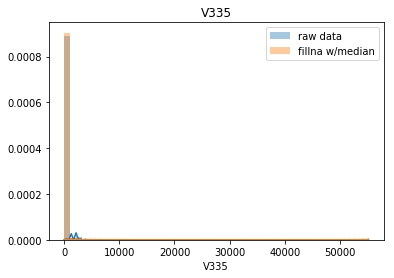

*** V336
count    82351.000000
mean        28.530903
std        274.576920
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      55125.000000
Name: V336, dtype: float64


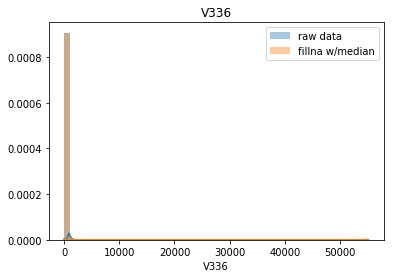

*** V337
count     82351.000000
mean         55.352422
std         668.486833
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V337, dtype: float64


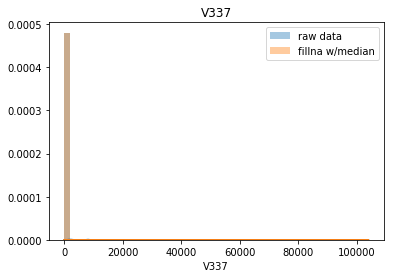

*** V338
count     82351.000000
mean        151.160542
std        1095.034387
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V338, dtype: float64


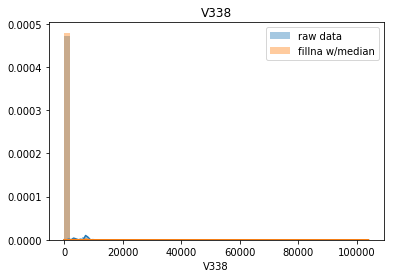

*** V339
count     82351.000000
mean        100.700882
std         814.946722
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      104060.000000
Name: V339, dtype: float64


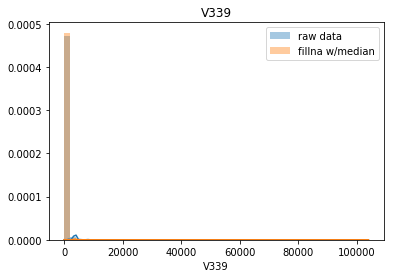

In [21]:
v_obj = examine_group(trans_df,'V',1,339,showfill=True)

In [22]:
# Double checking that there are no categorical variables among the V variables--they would show up here.
v_obj

[]

At a glance, a lot of these Vnnn variables look similar. With no other context, their usefulness seems kind of questionable. If PCA is a useful way to go, maybe all of these similar variables can be combined into components that hold more relevance?

### Identity

In [23]:
id_df.shape

(144233, 41)

In [24]:
id_df.describe(include='all')

TransactionID          id_01          id_02         id_03  \
count    1.442330e+05  144233.000000  140872.000000  66324.000000   
unique            NaN            NaN            NaN           NaN   
top               NaN            NaN            NaN           NaN   
freq              NaN            NaN            NaN           NaN   
mean     3.236329e+06     -10.170502  174716.584708      0.060189   
std      1.788496e+05      14.347949  159651.816856      0.598231   
min      2.987004e+06    -100.000000       1.000000    -13.000000   
25%      3.077142e+06     -10.000000   67992.000000      0.000000   
50%      3.198818e+06      -5.000000  125800.500000      0.000000   
75%      3.392923e+06      -5.000000  228749.000000      0.000000   
max      3.577534e+06       0.000000  999595.000000     10.000000   

               id_04          id_05          id_06        id_07        id_08  \
count   66324.000000  136865.000000  136865.000000  5155.000000  5155.000000   
unique           NaN            NaN            NaN          NaN          NaN   
top              NaN            NaN            NaN          NaN          NaN   
freq             NaN            NaN            NaN          NaN          NaN   
mean       -0.058938       1.615585      -6.698710    13.285354   -38.600388   
std         0.701015       5.249856      16.491104    11.384207    26.084899   
min       -28.000000     -72.000000    -100.000000   -46.000000  -100.000000   
25%         0.000000       0.000000      -6.000000     5.000000   -48.000000   
50%         0.000000       0.000000       0.000000    14.000000   -34.000000   
75%         0.000000       1.000000       0.000000    22.000000   -23.000000   
max         0.000000      52.000000       0.000000    61.000000     0.000000   

               id_09  ...        id_31         id_32      id_33  \
count   74926.000000  ...       140282  77586.000000      73289   
unique           NaN  ...          130           NaN        260   
top              NaN  ...  chrome 63.0           NaN  1920x1080   
freq             NaN  ...        22000           NaN      16874   
mean        0.091023  ...          NaN     26.508597        NaN   
std         0.983842  ...          NaN      3.737502        NaN   
min       -36.000000  ...          NaN      0.000000        NaN   
25%         0.000000  ...          NaN     24.000000        NaN   
50%         0.000000  ...          NaN     24.000000        NaN   
75%         0.000000  ...          NaN     32.000000        NaN   
max        25.000000  ...          NaN     32.000000        NaN   

                 id_34   id_35   id_36   id_37   id_38  DeviceType  DeviceInfo  
count            77805  140985  140985  140985  140985      140810      118666  
unique               4       2       2       2       2           2        1786  
top     match_status:2       T       F       T       F     desktop     Windows  
freq             60011   77814  134066  110452   73922       85165       47722  
mean               NaN     NaN     NaN     NaN     NaN         NaN         NaN  
std                NaN     NaN     NaN     NaN     NaN         NaN         NaN  
min                NaN     NaN     NaN     NaN     NaN         NaN         NaN  
25%                NaN     NaN     NaN     NaN     NaN         NaN         NaN  
50%                NaN     NaN     NaN     NaN     NaN         NaN         NaN  
75%                NaN     NaN     NaN     NaN     NaN         NaN         NaN  
max                NaN     NaN     NaN     NaN     NaN         NaN         NaN  

[11 rows x 41 columns]

Let's also see what using fillna to replace NaNs with the median of the id variables will do.

*** id_01
count    144233.000000
mean        -10.170502
std          14.347949
min        -100.000000
25%         -10.000000
50%          -5.000000
75%          -5.000000
max           0.000000
Name: id_01, dtype: float64


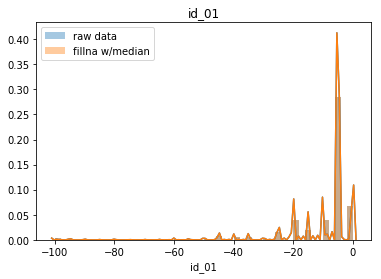

*** id_02
count    140872.000000
mean     174716.584708
std      159651.816856
min           1.000000
25%       67992.000000
50%      125800.500000
75%      228749.000000
max      999595.000000
Name: id_02, dtype: float64


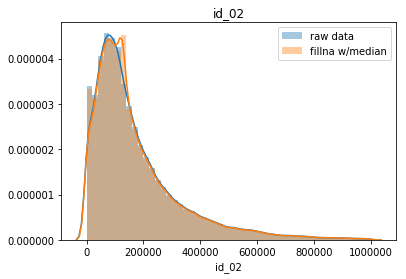

*** id_03
count    66324.000000
mean         0.060189
std          0.598231
min        -13.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         10.000000
Name: id_03, dtype: float64


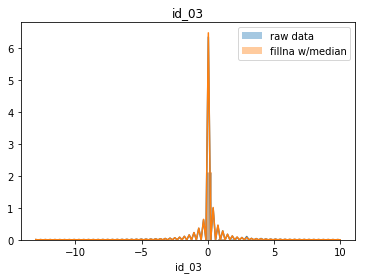

*** id_04
count    66324.000000
mean        -0.058938
std          0.701015
min        -28.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: id_04, dtype: float64


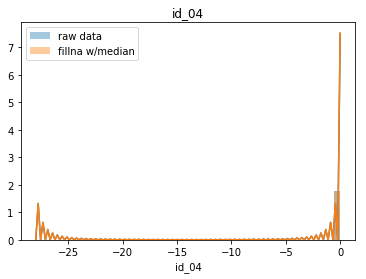

*** id_05
count    136865.000000
mean          1.615585
std           5.249856
min         -72.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          52.000000
Name: id_05, dtype: float64


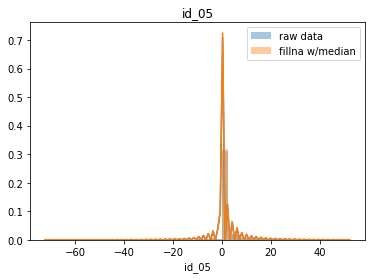

*** id_06
count    136865.000000
mean         -6.698710
std          16.491104
min        -100.000000
25%          -6.000000
50%           0.000000
75%           0.000000
max           0.000000
Name: id_06, dtype: float64


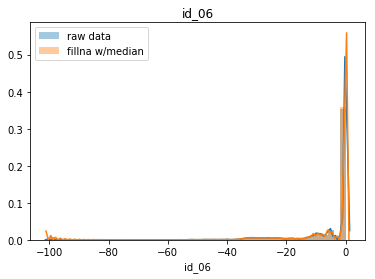

*** id_07
count    5155.000000
mean       13.285354
std        11.384207
min       -46.000000
25%         5.000000
50%        14.000000
75%        22.000000
max        61.000000
Name: id_07, dtype: float64


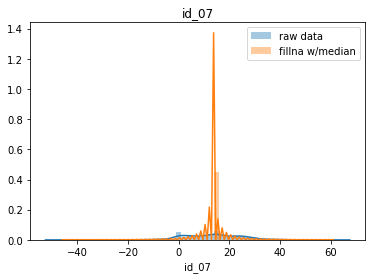

*** id_08
count    5155.000000
mean      -38.600388
std        26.084899
min      -100.000000
25%       -48.000000
50%       -34.000000
75%       -23.000000
max         0.000000
Name: id_08, dtype: float64


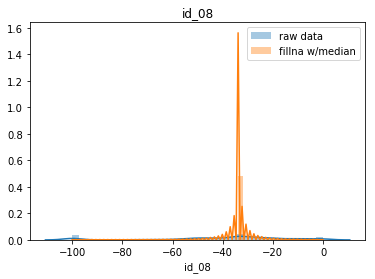

*** id_09
count    74926.000000
mean         0.091023
std          0.983842
min        -36.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         25.000000
Name: id_09, dtype: float64


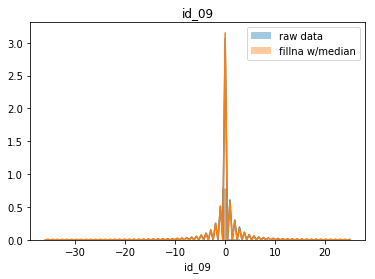

*** id_10
count    74926.000000
mean        -0.301124
std          2.789446
min       -100.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: id_10, dtype: float64


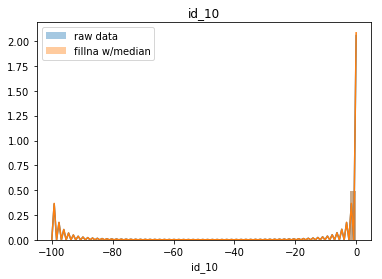

*** id_11
count    140978.000000
mean         99.745325
std           1.127602
min          90.000000
25%         100.000000
50%         100.000000
75%         100.000000
max         100.000000
Name: id_11, dtype: float64


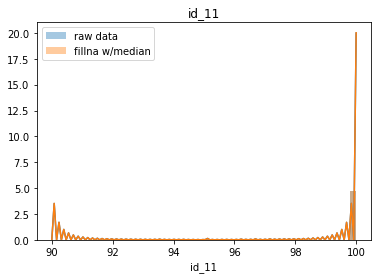

*** id_12
count       144233
unique           2
top       NotFound
freq        123025
Name: id_12, dtype: object
*** id_13
count    127320.000000
mean         48.053071
std          11.774858
min          10.000000
25%          49.000000
50%          52.000000
75%          52.000000
max          64.000000
Name: id_13, dtype: float64


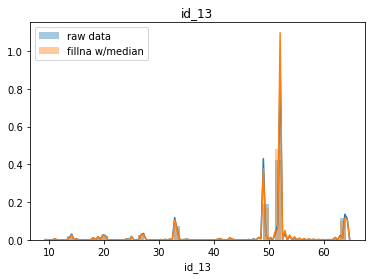

*** id_14
count    80044.000000
mean      -344.507146
std         93.695502
min       -660.000000
25%       -360.000000
50%       -300.000000
75%       -300.000000
max        720.000000
Name: id_14, dtype: float64


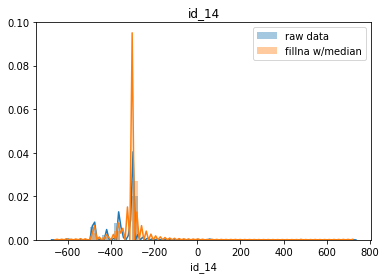

*** id_15
count     140985
unique         3
top        Found
freq       67728
Name: id_15, dtype: object
*** id_16
count     129340
unique         2
top        Found
freq       66324
Name: id_16, dtype: object
*** id_17
count    139369.000000
mean        189.451377
std          30.375360
min         100.000000
25%         166.000000
50%         166.000000
75%         225.000000
max         229.000000
Name: id_17, dtype: float64


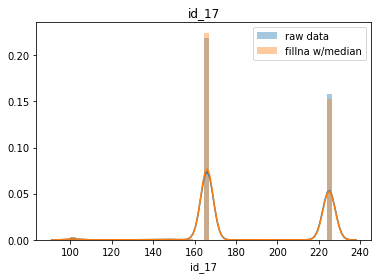

*** id_18
count    45113.000000
mean        14.237337
std          1.561302
min         10.000000
25%         13.000000
50%         15.000000
75%         15.000000
max         29.000000
Name: id_18, dtype: float64


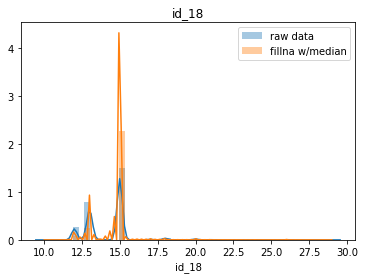

*** id_19
count    139318.000000
mean        353.128174
std         141.095343
min         100.000000
25%         266.000000
50%         341.000000
75%         427.000000
max         671.000000
Name: id_19, dtype: float64


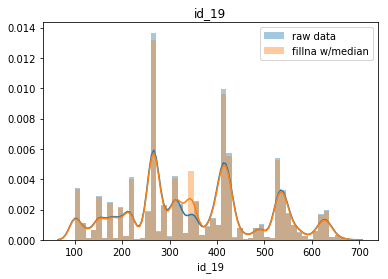

*** id_20
count    139261.000000
mean        403.882666
std         152.160327
min         100.000000
25%         256.000000
50%         472.000000
75%         533.000000
max         661.000000
Name: id_20, dtype: float64


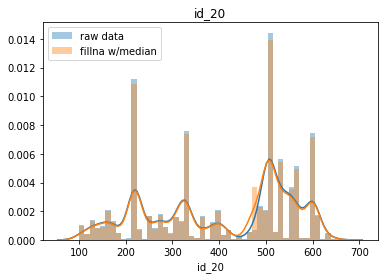

*** id_21
count    5159.000000
mean      368.269820
std       198.847038
min       100.000000
25%       252.000000
50%       252.000000
75%       486.500000
max       854.000000
Name: id_21, dtype: float64


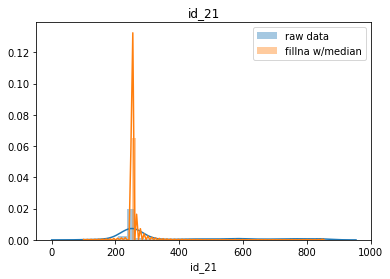

*** id_22
count    5169.000000
mean       16.002708
std         6.897665
min        10.000000
25%        14.000000
50%        14.000000
75%        14.000000
max        44.000000
Name: id_22, dtype: float64


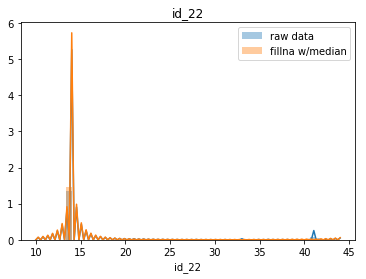

*** id_23
count                     5169
unique                       3
top       IP_PROXY:TRANSPARENT
freq                      3489
Name: id_23, dtype: object
*** id_24
count    4747.000000
mean       12.800927
std         2.372447
min        11.000000
25%        11.000000
50%        11.000000
75%        15.000000
max        26.000000
Name: id_24, dtype: float64


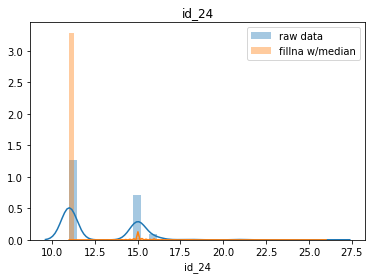

*** id_25
count    5132.000000
mean      329.608924
std        97.461089
min       100.000000
25%       321.000000
50%       321.000000
75%       371.000000
max       548.000000
Name: id_25, dtype: float64


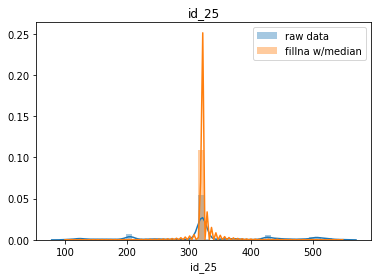

*** id_26
count    5163.000000
mean      149.070308
std        32.101995
min       100.000000
25%       119.000000
50%       149.000000
75%       169.000000
max       216.000000
Name: id_26, dtype: float64


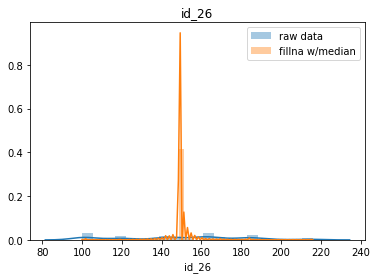

*** id_27
count      5169
unique        2
top       Found
freq       5155
Name: id_27, dtype: object
*** id_28
count     140978
unique         2
top        Found
freq       76232
Name: id_28, dtype: object
*** id_29
count     140978
unique         2
top        Found
freq       74926
Name: id_29, dtype: object
*** id_30
count          77565
unique            75
top       Windows 10
freq           21155
Name: id_30, dtype: object
*** id_31
count          140282
unique            130
top       chrome 63.0
freq            22000
Name: id_31, dtype: object
*** id_32
count    77586.000000
mean        26.508597
std          3.737502
min          0.000000
25%         24.000000
50%         24.000000
75%         32.000000
max         32.000000
Name: id_32, dtype: float64


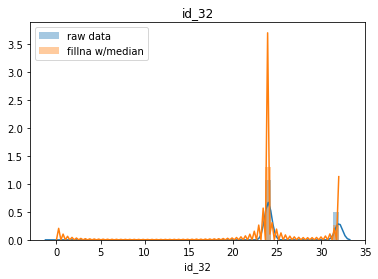

*** id_33
count         73289
unique          260
top       1920x1080
freq          16874
Name: id_33, dtype: object
*** id_34
count              77805
unique                 4
top       match_status:2
freq               60011
Name: id_34, dtype: object
*** id_35
count     140985
unique         2
top            T
freq       77814
Name: id_35, dtype: object
*** id_36
count     140985
unique         2
top            F
freq      134066
Name: id_36, dtype: object
*** id_37
count     140985
unique         2
top            T
freq      110452
Name: id_37, dtype: object
*** id_38
count     140985
unique         2
top            F
freq       73922
Name: id_38, dtype: object


In [25]:
# Peek at the ID columns. Mix of categorical and continuous data
id_obj = examine_group(id_df,'id_',1,38,zeropad=True,showfill=True)

In [26]:
# The ID group of variables contains a number of categorical variables.
# We'll want to determine the best way to fill nulls for these.
id_obj

['id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38']

## Data cleanup / feature creation

Fill NaNs in the card<i>n</i> variables.

* card2: 100-600. fillna with median
* card3: fillna with median
* card4: card network. fillna with 'other'
* card5: total guess, APR? values are 100-237, median is 226 (22.6%?). fillna with median
* card6: card type, primarily credit/debit. fillna with 'other' (prepaid?)

In [27]:
trans_df['card2'].fillna(trans_df['card2'].median(),inplace=True)
trans_df['card3'].fillna(trans_df['card3'].median(),inplace=True)
trans_df['card4'].fillna('other',inplace=True)
trans_df['card5'].fillna(trans_df['card5'].median(),inplace=True)
trans_df['card6'].fillna('other',inplace=True)

In [28]:
trans_df['card6'] = trans_df['card6'].apply(lambda x: card6_cleanup(x))

In [29]:
trans_df['card6'].value_counts()

debit     439938
credit    148986
other       1616
Name: card6, dtype: int64

Fill NaNs in addr1 and addr2. These are numerical representations of categorical data (billing address ZIP and country), so I don't think we would ever use a mean or sum of these values. 0 is outside of the range of values for both, so let's use 0 to replace NaNs.

In [30]:
trans_df['addr1'].fillna(0,inplace=True)
trans_df['addr2'].fillna(0,inplace=True)

The dist<i>n</i> variables represent distance between billing and shipping address, and some similar measures. I'm going to replace NaNs with 0--if we understood which distances these are measuring, and we knew how to interpret the variables we have that represent that data (assuming we have them...?), we could probably impute these values instead.

In [31]:
trans_df['dist1'].fillna(0,inplace=True)
trans_df['dist2'].fillna(0,inplace=True)

Email domains for purchaser and recipient are strictly categorical. Some of the domains helpfully add country--we could strip this information, but it may prove useful. 

R_emaildomain has a LOT of null values because it's only used for online transactions where the recipient is not the same as the purchaser. This seems like it may be a great opportunity to identify fraudulent online transactions, so despite the sparse population, let's keep this variable and fill nulls with 'none'.

In [32]:
trans_df.drop('P_emaildomain',axis='columns',inplace=True)
trans_df.drop('R_emaildomain',axis='columns',inplace=True)

C<i>n</i> variables have no NaNs!

D<i>n</i> variables represent time deltas--time between detected uses of a particular billing address, email address, etc. If we don't know these values, we should set them to 0.

In [33]:
for i in range(1,16):
    range_id = 'D{}'.format(i)
    trans_df[range_id].fillna(0,inplace=True)

M<i>n</i> variables are mostly binary (T/F, presumably True/False)--if the value isn't True, but must be defined, it will be made False.

M4 is categorical, with values M0, M1, M2.

Let's take the time to make these values numeric too--this will save us from having to encode them later:
* False/NaN --> 0
* True --> 1

For M4:
* NaN --> -1
* Strip the M from the other values

In [34]:
for i in range(1,10):
    range_id = 'M{}'.format(i)
    if range_id != 'M4':
        trans_df[range_id] = trans_df[range_id].map({'F': 0, 'T': 1})
        trans_df[range_id].fillna(0,inplace=True)
    else:
        trans_df[range_id].fillna(-1,inplace=True)
        trans_df[range_id] = trans_df[range_id].apply(lambda x: int(str(x).strip('M')))

There are a lot of V<i>nnn</i> variables--probably too many for our purposes, since we have no clear idea of what they represent, and not all of them are well-populated. Let's see how many of these variables we would drop if we insisted that they be 50%/60%/75%/80%/85%/90% populated with actual values.

In [35]:
trans_len = trans_df.shape[0]
for pct in [.50,.60,.75,.80,.85,.9]:
    low_list = []
    for i in range(1,340):
        range_id = 'V{}'.format(i)
        if (pct > trans_df[range_id].describe()['count'] / trans_len):
            low_list.append(range_id)
    print("At {}: {}".format(pct,low_list))
    print("({} items; {} would remain)".format(len(low_list),339-len(low_list)))

At 0.5: ['V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261',

I am no longer dropping these variables, because I determined that PCA does a better job at feature reduction with all of the variables from the dataset in place. I presume this is because having the full explanation of the variance of the dataset allows the PCA function to do a more complete/efficient job.

When I was still dropping poorly populated variables, this is what I had to say about it:

>Let's start on the conservative end, and drop the columns that are only 50% or less populated. 
>
>After confirming the cutoff, the cell below drops the poorly-populated variables, and generates a list of the variables that were dropped. We'll use this list to both understand which variables to skip in the effort to fill NaNs for the Vesta and ID groups of variables, and to ensure that the same list of Vesta variables will be dropped when I prep Kaggle's test set of data, for the run of my preferred model.

In [36]:
for i in range(1,340):
    range_id = 'V{}'.format(i)
    trans_df[range_id].fillna(trans_df[range_id].median(),inplace=True)

```
v_50_drop_list = []
for i in range(1,340):
    range_id = 'V{}'.format(i)
    if (.50 > trans_df[range_id].describe()['count'] / trans_len):
        v_50_drop_list.append(range_id)
    else:
        trans_df[range_id].fillna(trans_df[range_id].median(),inplace=True)  

for i in range(1,340):
    range_id = 'V{}'.format(i)
    trans_df[range_id].fillna(trans_df[range_id].median(),inplace=True)

trans_df.drop(v_50_drop_list,axis='columns',inplace=True)
```

Variables in the identity dataframe are also not all so well populated. I performed similar analysis here to identify and drop poorly populated variables,, before I decided to use PCA to reduce the number of features instead.


In [37]:
id_len = id_df.shape[0]
for pct in [.5,.6,.75,.8,.95,.9,.95]:
    low_list = []
    for i in range(1,39):
        range_id = 'id_{:02d}'.format(i)
        if (pct > id_df[range_id].describe()['count'] / id_len):
            low_list.append(range_id)
    print("At {}: {}".format(pct,low_list))
    print("({} items; {} would remain)".format(len(low_list),38-len(low_list)))

At 0.5: ['id_03', 'id_04', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']
(12 items; 26 would remain)
At 0.6: ['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
(19 items; 19 would remain)
At 0.75: ['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
(19 items; 19 would remain)
At 0.8: ['id_03', 'id_04', 'id_07', 'id_08', 'id_09', 'id_10', 'id_14', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
(19 items; 19 would remain)
At 0.95: ['id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_13', 'id_14', 'id_16', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
(23 items; 15

I feel like this IP proxy variable may be useful, even though it's not very well populated. Let's clean it up a bit.

In [38]:
id_df.fillna({'id_23': 'NA'},inplace=True)
id_df['id_23'] = id_df['id_23'].map(lambda x: re.sub(r'IP_PROXY:','',str(x)))

Replace null values with "NotFound" for these Found/NotFound features--as with True/False values for other variables, if it's not explicitly True (Found), it should probably be False (NotFound).

We can also take the time to convert these values to numeric values.

A couple of these variables also have 'New', which we can convert to a 2.

In [39]:
for fnf in ['id_12','id_15','id_16','id_27','id_28','id_29']:
    id_df[fnf] = id_df[fnf].map({'NotFound': 0, 'Found': 1, 'New': 2, 'Unknown': -1})
    id_df[fnf].fillna(0,inplace=True)

Reduce the large number of OSes in id_30 to just a handful by lopping off version information.

In [40]:
id_df.drop(columns=['id_30'],axis='columns',inplace=True)

Reduce the large number of browsers to a much shorter, higher-level list.

In [41]:
id_df['id_31'] = id_df['id_31'].apply(lambda x: reduce_browsers(x))

In [42]:
id_df['id_31'].value_counts()

Chrome                    76059
Safari                    37281
Internet Explorer 11.0     9677
Firefox                    7012
Microsoft Edge             6401
Other                      5409
Samsung Browser            2028
Opera                       366
Name: id_31, dtype: int64

id_32 appears to be sound quality of the purchaser's computer/mobile device (16-bit, 24-bit, 32-bit audio). I have the feeling this will prove to be useless, but let's fill NaNs with 0.

In [43]:
id_df['id_32'].fillna(0.0,inplace=True)

In [44]:
id_df['id_32'].value_counts()

0.0     66653
24.0    53071
32.0    24428
16.0       81
Name: id_32, dtype: int64

id_33 is screen resolution. I get the sense this is also going to be useless. This is also one of those categorical variables with a ton of unique values. Let's transform it into a simple measure of resolution: high/medium/low/none, and then encode that.

In [45]:
id_df['id_33'].fillna('0x0',inplace=True)

In [46]:
id_df['id_33'] = id_df['id_33'].str.split(pat='x').str[0].apply(lambda x: reduce_resolution(x))

In [47]:
id_df['id_33'].value_counts()

0    70950
2    51160
3    20772
1     1351
Name: id_33, dtype: int64

Turn id_34 into a purely numeric/categorical feature by removing the "match_status:" string, and filling nulls with a 3. -1 and 0 are already valid (though rare) values. The number of rows that fall into this new category will follow the trend of increasing #s for each higher categorical value.

In [48]:
id_df.fillna({'id_34': 3},inplace=True)
id_df['id_34'] = id_df['id_34'].map(lambda x: re.sub(r'match_status:','',str(x))).astype(int)

In [49]:
id_df['id_34'].value_counts()

 3    66428
 2    60011
 1    17376
 0      415
-1        3
Name: id_34, dtype: int64

# This variable has different values in the Kaggle test set.
# If my models' performance drops without this variable, I can look at other options--
# but for now, I'm going to drop it.
id_df.drop(['id_34'],axis='columns',inplace=True)

Encode the T/F values in the last 3 ID columns.

In [50]:
for i in range(35,39):
    range_id = 'id_{}'.format(i)
    id_df[range_id] = id_df[range_id].map({'F': 0, 'T': 1})
    id_df[range_id].fillna(0,inplace=True)

Let's reduce the number of categories for Device Info.

In [51]:
id_df['DeviceInfo'].fillna('NA',inplace=True)

In [52]:
id_df['DeviceInfo'] = id_df['DeviceInfo'].apply(lambda x: reduce_devices(x))

In [53]:
id_df['DeviceInfo'].value_counts()

Windows          47722
NA               25567
iOS Device       19782
MacOS            12573
SAMSUNG          11940
Trident/7.0       7440
Other             5864
Unknown (rv:)     4385
Moto              2851
LG                2563
Huawei            2415
ZTE Blade          504
HTC                406
Hisense            221
Name: DeviceInfo, dtype: int64

This is where I dropped the poorly populated id_ features, before I decided to use PCA for feature reduction.

```
id_50_drop_list = []
for i in range(1,39):
    range_id = 'id_{:02d}'.format(i)
    if (.50 > id_df[range_id].describe()['count'] / id_len):
        id_50_drop_list.append(range_id)
    if range_id not in id_obj:
        id_df[range_id].fillna(id_df[range_id].median(),inplace=True)

id_df.drop(id_50_drop_list,axis='columns',inplace=True)
```

### Merge the transaction and identity dataframes

In [54]:
df = pd.merge(trans_df,id_df,on='TransactionID',how='left')

In [55]:
df.shape

(590540, 431)

In [56]:
df.describe(include='all')

TransactionID        isFraud  TransactionDT  TransactionAmt ProductCD  \
count    5.905400e+05  590540.000000   5.905400e+05   590540.000000    590540   
unique            NaN            NaN            NaN             NaN         5   
top               NaN            NaN            NaN             NaN         W   
freq              NaN            NaN            NaN             NaN    439670   
mean     3.282270e+06       0.034990   7.372311e+06      135.027176       NaN   
std      1.704744e+05       0.183755   4.617224e+06      239.162522       NaN   
min      2.987000e+06       0.000000   8.640000e+04        0.251000       NaN   
25%      3.134635e+06       0.000000   3.027058e+06       43.321000       NaN   
50%      3.282270e+06       0.000000   7.306528e+06       68.769000       NaN   
75%      3.429904e+06       0.000000   1.124662e+07      125.000000       NaN   
max      3.577539e+06       1.000000   1.581113e+07    31937.391000       NaN   

                card1          card2          card3   card4          card5  \
count   590540.000000  590540.000000  590540.000000  590540  590540.000000   
unique            NaN            NaN            NaN       5            NaN   
top               NaN            NaN            NaN    visa            NaN   
freq              NaN            NaN            NaN  384767            NaN   
mean      9898.734658     362.531959     153.186458     NaN     199.471611   
std       4901.170153     156.595356      11.322604     NaN      41.157610   
min       1000.000000     100.000000     100.000000     NaN     100.000000   
25%       6019.000000     215.000000     150.000000     NaN     166.000000   
50%       9678.000000     361.000000     150.000000     NaN     226.000000   
75%      14184.000000     512.000000     150.000000     NaN     226.000000   
max      18396.000000     600.000000     231.000000     NaN     237.000000   

        ...   id_31          id_32          id_33          id_34  \
count   ...  144233  144233.000000  144233.000000  144233.000000   
unique  ...       8            NaN            NaN            NaN   
top     ...  Chrome            NaN            NaN            NaN   
freq    ...   76059            NaN            NaN            NaN   
mean    ...     NaN      14.259538       1.150825       2.334272   
std     ...     NaN      13.497454       1.183193       0.693537   
min     ...     NaN       0.000000       0.000000      -1.000000   
25%     ...     NaN       0.000000       0.000000       2.000000   
50%     ...     NaN      24.000000       1.000000       2.000000   
75%     ...     NaN      24.000000       2.000000       3.000000   
max     ...     NaN      32.000000       3.000000       3.000000   

                id_35          id_36          id_37          id_38  \
count   144233.000000  144233.000000  144233.000000  144233.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean         0.539502       0.047971       0.765789       0.464963   
std          0.498439       0.213706       0.423506       0.498773   
min          0.000000       0.000000       0.000000       0.000000   
25%          0.000000       0.000000       1.000000       0.000000   
50%          1.000000       0.000000       1.000000       0.000000   
75%          1.000000       0.000000       1.000000       1.000000   
max          1.000000       1.000000       1.000000       1.000000   

        DeviceType  DeviceInfo  
count       140810      144233  
unique           2          14  
top        desktop     Windows  
freq         85165       47722  
mean           NaN         NaN  
std            NaN         NaN  
min            NaN         NaN  
25%            NaN         NaN  
50%            NaN         NaN  
75%            NaN         NaN  
max            NaN         NaN  

[11 rows x 431 columns]

### Delete the two individual dataframes to reclaim some memory

In [57]:
import gc
del trans_df,id_df
gc.collect()

16

## What does fraud look like?

I'm curious about what the fraudulent transactions look in terms of amounts and frequency.

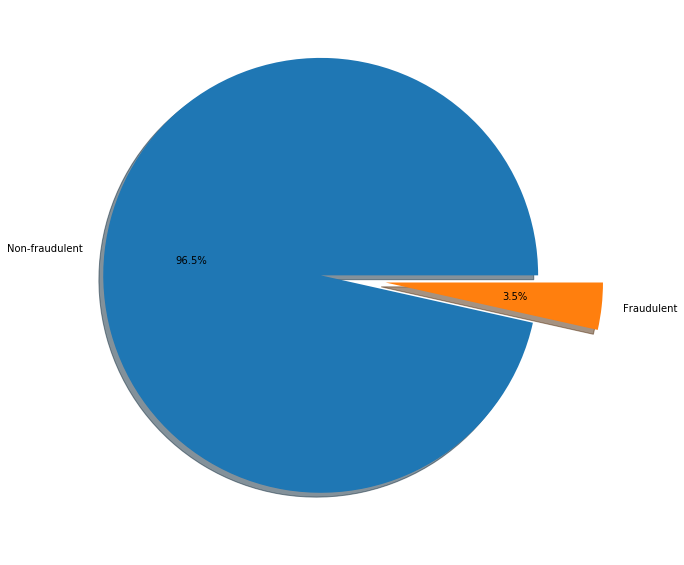

In [58]:
fig=plt.figure(figsize=(10,10))
pie = plt.pie(df['isFraud'].value_counts().apply(lambda x: x/(df['isFraud'].count()) * 100).values,
        autopct='%1.1f%%',
        labels=['Non-fraudulent','Fraudulent'],
        explode=[.3,0],shadow=True)

One __super__ important thing to note here is that the number of instances of fraud (at least as detected by Vesta and friends) is extremely small--the Vesta rep in the Kaggle comment board suggested 2-3% of transactions is reasonable in the real world. __If the training and test sets Kaggle generated for us are reflective of that, they are heavily biased toward no fraud, and we will want to take this bias into account.__ Otherwise, at these percentages, the model could just classify everything as legit and still be correct 97% of the time.

In [59]:
fraud_df = df.loc[df['isFraud'] == 1]

I'm curious about how many of the fraudulent transactions have identity information associated with them. If this data isn't helpful, we can ignore it.

In [60]:
fraud_df.loc[fraud_df['id_01'].isnull()].shape[0] / fraud_df.shape[0] * 100

45.22576586168513

So, only 45%, but that's still close to half of the transactions.

What kinds of amounts are we talking about?

In [61]:
fraud_df['TransactionAmt'].describe()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

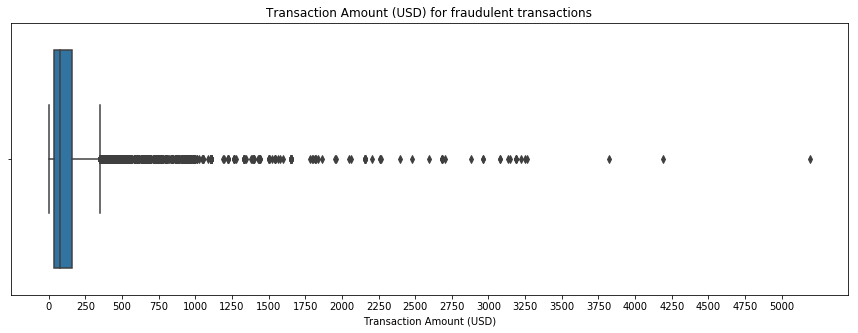

In [62]:
fig = plt.figure(figsize=(15,5))
ax = sns.boxplot(fraud_df['TransactionAmt'])
labels = ax.set(xticks=(np.arange(0,fraud_df['TransactionAmt'].max(),step=250)),
                xlabel="Transaction Amount (USD)",
                title="Transaction Amount (USD) for fraudulent transactions")

It's sort of a surprise to see that the majority of transactions are less than \\$100.

Taking a closer look at the lowest quartile of transactions (plus low outliers):

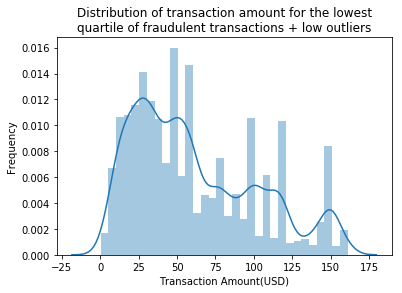

In [63]:
ax2 = sns.distplot(fraud_df.loc[fraud_df['TransactionAmt'] < fraud_df['TransactionAmt'].describe()['75%'],
                          'TransactionAmt'])
labels = ax2.set(xlabel="Transaction Amount(USD)",ylabel="Frequency",
                 title="Distribution of transaction amount for the lowest\nquartile of fraudulent transactions + low outliers")

Are fraudulent transactions any higher or lower on average compared to non-fraudulent transactions? __Yes, though not by a lot.__

The means are only \\$15 apart--the medians are even closer, only \\$7 apart.

In [64]:
df.loc[df['isFraud'] == 1,'TransactionAmt'].describe() #.sort_values(ascending=False).head(30)#.mean()

count    20663.000000
mean       149.244779
std        232.212163
min          0.292000
25%         35.044000
50%         75.000000
75%        161.000000
max       5191.000000
Name: TransactionAmt, dtype: float64

In [65]:
df.loc[df['isFraud'] == 0,'TransactionAmt'].describe() #.sort_values(ascending=False).head(30)#.mean()

count    569877.000000
mean        134.511665
std         239.395078
min           0.251000
25%          43.970000
50%          68.500000
75%         120.000000
max       31937.391000
Name: TransactionAmt, dtype: float64

Is there any correlation between product code and fraudulent transactions? Product Code for the full training set has this distribution.
```
W    439670
C     68519
R     37699
H     33024
S     11628
```

And the distribution of Product Code for fraudulent transactions looks like this:

In [66]:
fraud_pcd = fraud_df['ProductCD'].value_counts()
fraud_pcd

W    8969
C    8008
H    1574
R    1426
S     686
Name: ProductCD, dtype: int64

Note that there are more fraudulent transactions with a product code of 'W', but as a percentage of 'W' transactions, this is a low number. 

Over 11% of transactions with a product type of 'C' are fraudulent--this is higher than the overall percentage of fraudulent transactions in the dataset, and higher than any other product code.

In [67]:
for pcd in fraud_df['ProductCD'].unique():
    print(" Percentage of fraudulent transactions having product code {}: {}".format(pcd,fraud_pcd[pcd] / trans_pcd[pcd] * 100))

 Percentage of fraudulent transactions having product code W: 2.0399390451929857
 Percentage of fraudulent transactions having product code C: 11.687269224594637
 Percentage of fraudulent transactions having product code R: 3.782593702750736
 Percentage of fraudulent transactions having product code S: 5.8995528035775715
 Percentage of fraudulent transactions having product code H: 4.766230620155039


Which credit card network is the most frequent victim of fraudulent transactions?

In [68]:
fraud_ccn = fraud_df['card4'].value_counts()
fraud_ccn

visa                13373
mastercard           6496
discover              514
american express      239
other                  41
Name: card4, dtype: int64

In [69]:
trans_ccn = df['card4'].value_counts()
trans_ccn

visa                384767
mastercard          189217
american express      8328
discover              6651
other                 1577
Name: card4, dtype: int64

In [70]:
fraud_ccn / len(df) * 100

visa                2.264538
mastercard          1.100010
discover            0.087039
american express    0.040471
other               0.006943
Name: card4, dtype: float64

In [71]:
for ccn in fraud_df['card4'].unique():
    print(" Percentage of fraudulent transactions from the {} network: {}".format(ccn.title(),fraud_ccn[ccn] / trans_ccn[ccn] * 100))

 Percentage of fraudulent transactions from the Visa network: 3.4756099145716757
 Percentage of fraudulent transactions from the Mastercard network: 3.433095334985757
 Percentage of fraudulent transactions from the Discover network: 7.72816117877011
 Percentage of fraudulent transactions from the American Express network: 2.8698366954851102
 Percentage of fraudulent transactions from the Other network: 2.599873176918199


This is an interesting stat--Visa cards have far and away the most fraudulent transactions, because Visa cards are the overwhelming choice for purchasers. Discover cards are a relatively tiny amount of transactions compared to Visa, but Discover has the highest percentage of fraudulent transactions for their type.

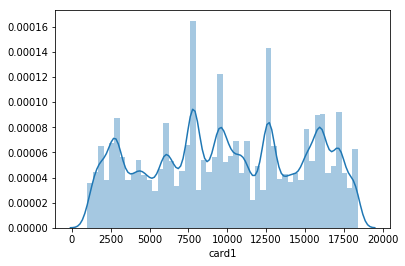

In [72]:
sns.distplot(df['card1'])

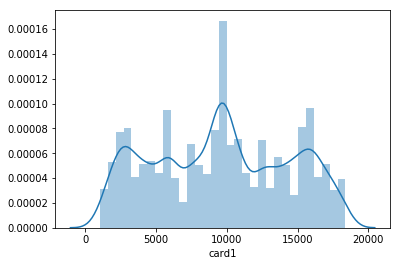

In [73]:
sns.distplot(df.loc[df['isFraud'] ==1]['card1'])

## Split the Kaggle "training" dataset into training and test data.
(The Kaggle "test" dataset is our "production" data.)

__NOTE:__ I'm not dropping the isFraud variable from Xtrain and Xtest! I want to confirm the split left us with a distribution for this variable that is comparable to the full dataset. I can drop isFraud when I am ready to build my models.

In [74]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(df.drop(['TransactionID'],axis='columns'),
                                                df['isFraud'],
                                                test_size = 0.2,
                                                random_state = 0)

In [75]:
Xtest.describe()

isFraud  TransactionDT  TransactionAmt          card1  \
count  118108.000000   1.181080e+05   118108.000000  118108.000000   
mean        0.034308   7.366406e+06      134.694562    9903.897357   
std         0.182019   4.612504e+06      231.776803    4895.438573   
min         0.000000   8.651000e+04        0.292000    1001.000000   
25%         0.000000   3.031912e+06       43.783000    6019.000000   
50%         0.000000   7.274000e+06       68.500000    9665.000000   
75%         0.000000   1.123388e+07      123.000000   14184.000000   
max         1.000000   1.581105e+07     5279.950000   18395.000000   

               card2          card3          card5          addr1  \
count  118108.000000  118108.000000  118108.000000  118108.000000   
mean      362.055441     153.165357     199.341814     258.406399   
std       156.430210      11.288086      41.203381     132.467004   
min       100.000000     100.000000     100.000000       0.000000   
25%       215.000000     150.000000     166.000000     184.000000   
50%       361.000000     150.000000     226.000000     272.000000   
75%       512.000000     150.000000     226.000000     327.000000   
max       600.000000     229.000000     237.000000     540.000000   

               addr2          dist1  ...         id_27         id_28  \
count  118108.000000  118108.000000  ...  28708.000000  28708.000000   
mean       77.150151      47.434611  ...      0.036227      1.424899   
std        27.412015     243.137848  ...      0.186857      0.539488   
min         0.000000       0.000000  ...      0.000000      0.000000   
25%        87.000000       0.000000  ...      0.000000      1.000000   
50%        87.000000       0.000000  ...      0.000000      1.000000   
75%        87.000000       5.000000  ...      0.000000      2.000000   
max       102.000000    7068.000000  ...      1.000000      2.000000   

              id_29         id_32         id_33         id_34         id_35  \
count  28708.000000  28708.000000  28708.000000  28708.000000  28708.000000   
mean       0.519576     14.193117      1.141041      2.340428      0.537376   
std        0.499625     13.496850      1.182364      0.690167      0.498610   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      2.000000      0.000000   
50%        1.000000     24.000000      1.000000      2.000000      1.000000   
75%        1.000000     24.000000      2.000000      3.000000      1.000000   
max        1.000000     32.000000      3.000000      3.000000      1.000000   

              id_36         id_37         id_38  
count  28708.000000  28708.000000  28708.000000  
mean       0.048767      0.765501      0.464435  
std        0.215384      0.423693      0.498742  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000  

[8 rows x 423 columns]

Verify that the split left us with similarly imbalanced data.

In [76]:
Xtrain['isFraud'].value_counts().apply(lambda x: x/(Xtrain['isFraud'].count()) * 100)

0    96.483938
1     3.516062
Name: isFraud, dtype: float64

In [77]:
Xtest['isFraud'].value_counts().apply(lambda x: x/(Xtest['isFraud'].count()) * 100)

0    96.569242
1     3.430758
Name: isFraud, dtype: float64

Nice!

### I had memory issues trying to build models for the entire training dataset, so to try and mitigate this _and_ potential issues around training with imbalanced data, I chose to [undersample](https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8).

To create this dataset, I select a number of random, non-fraudulent rows from the dataframe totaling the number of fraudulent rows--this leaves me with a 50/50 split, which should be better for training.

In [78]:
fraud_df = Xtrain.loc[Xtrain['isFraud'] == 1]

In [79]:
nonfraud_df = Xtrain.loc[Xtrain['isFraud'] == 0].sample(len(fraud_df))

In [80]:
smaller_df = pd.concat([fraud_df,nonfraud_df],ignore_index=True)

In [81]:
smaller_df.describe(include='all')

isFraud  TransactionDT  TransactionAmt ProductCD         card1  \
count   33222.000000   3.322200e+04    33222.000000     33222  33222.000000   
unique           NaN            NaN             NaN         5           NaN   
top              NaN            NaN             NaN         W           NaN   
freq             NaN            NaN             NaN     19703           NaN   
mean        0.500000   7.526012e+06      141.299011       NaN   9733.288574   
std         0.500008   4.521360e+06      229.331665       NaN   4831.362085   
min         0.000000   8.800400e+04        0.292000       NaN   1006.000000   
25%         0.000000   3.516756e+06       39.000000       NaN   5829.000000   
50%         0.500000   7.418170e+06       72.950000       NaN   9633.000000   
75%         1.000000   1.123114e+07      150.000000       NaN  13832.000000   
max         1.000000   1.581088e+07     4409.870000       NaN  18395.000000   

               card2         card3  card4         card5  card6  ...   id_31  \
count   33222.000000  33222.000000  33222  33222.000000  33222  ...   13029   
unique           NaN           NaN      5           NaN      3  ...       8   
top              NaN           NaN   visa           NaN  debit  ...  Chrome   
freq             NaN           NaN  21628           NaN  20999  ...    7879   
mean      364.396334    157.605713    NaN    196.018542    NaN  ...     NaN   
std       157.789764     15.339681    NaN     43.602093    NaN  ...     NaN   
min       100.000000    100.000000    NaN    100.000000    NaN  ...     NaN   
25%       215.000000    150.000000    NaN    166.000000    NaN  ...     NaN   
50%       361.000000    150.000000    NaN    224.000000    NaN  ...     NaN   
75%       514.000000    150.000000    NaN    226.000000    NaN  ...     NaN   
max       600.000000    231.000000    NaN    237.000000    NaN  ...     NaN   

               id_32         id_33         id_34         id_35         id_36  \
count   13029.000000  13029.000000  13029.000000  13029.000000  13029.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean       10.446849      0.832758      2.503569      0.385678      0.028475   
std        13.464820      1.133903      0.690248      0.486774      0.166332   
min         0.000000      0.000000      0.000000      0.000000      0.000000   
25%         0.000000      0.000000      2.000000      0.000000      0.000000   
50%         0.000000      0.000000      3.000000      0.000000      0.000000   
75%        24.000000      2.000000      3.000000      1.000000      0.000000   
max        32.000000      3.000000      3.000000      1.000000      1.000000   

               id_37         id_38  DeviceType  DeviceInfo  
count   13029.000000  13029.000000       12859       13029  
unique           NaN           NaN           2          14  
top              NaN           NaN     desktop     Windows  
freq             NaN           NaN        6821        3797  
mean        0.800061      0.387750         NaN         NaN  
std         0.399969      0.487256         NaN         NaN  
min         0.000000      0.000000         NaN         NaN  
25%         1.000000      0.000000         NaN         NaN  
50%         1.000000      0.000000         NaN         NaN  
75%         1.000000      1.000000         NaN         NaN  
max         1.000000      1.000000         NaN         NaN  

[11 rows x 430 columns]

In [82]:
X = smaller_df.drop(['isFraud'],axis='columns')
Y = smaller_df['isFraud']

X = pd.get_dummies(X,drop_first=True)
X = X.dropna(axis='columns')

In [83]:
X.shape

(33222, 421)

In [84]:
X.columns

Index(['TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5',
       'addr1', 'addr2', 'dist1', 'dist2',
       ...
       'DeviceInfo_MacOS', 'DeviceInfo_Moto', 'DeviceInfo_NA',
       'DeviceInfo_Other', 'DeviceInfo_SAMSUNG', 'DeviceInfo_Trident/7.0',
       'DeviceInfo_Unknown (rv:)', 'DeviceInfo_Windows',
       'DeviceInfo_ZTE Blade', 'DeviceInfo_iOS Device'],
      dtype='object', length=421)

### Scale the data, and apply PCA to reduce features.

We want to apply the same transformations to our training set (Xtrain) and test set (Xtest), _and_ to the Kaggle test set.

I ran through a few iterations of test data and models. Those iterations include:
1. Feeding the dataset more or less as-is to my models, only turning categorical variables into dummies, and dropping rows with NaNs.
2. Dropping poorly populated variables (> 50% NaNs), filling NaNs in remaining variables with values appropriate to each variable, and reducing the number of unique values for id_30 and id_31 (operating system and browser) to shorter, higher-level lists.
3. After running an iteration of the random forest model, computing permutation importance for one of the models, and using the output from that to try and further reduce the feature set. (I only eliminated another 8 features this way.)
4. Encoding more of the categorical variables myself instead of relying on get_dummies, and dropping the emaildomain columns--they generated a lot of dummy variables that varied between datasets, and were not even that relevant to determining fraud.

So many of the Vesta-generated variables have a similar distribution that PCA seems like an obvious way to reduce features without losing too much of the ability to explain the variance of the model. 

In [85]:
sclr = StandardScaler()
X_transformed = sclr.fit_transform(X)

In [86]:
pca = PCA(.95)

In [87]:
pca.fit(X_transformed)
X_pca = pca.transform(X_transformed)

Just a quick look at how the components look--how much variance each of them explains. Together, they should explain about 95% of the variance of the data.

In [88]:
pca.explained_variance_ratio_

array([0.12895586, 0.11184527, 0.06306493, 0.03396261, 0.02987238,
       0.02548651, 0.02456606, 0.02341861, 0.02284787, 0.02104973,
       0.01741101, 0.01651446, 0.01541842, 0.01359579, 0.01153611,
       0.01076186, 0.01072318, 0.0097884 , 0.0095321 , 0.00932653,
       0.00893673, 0.00850275, 0.00800656, 0.00761437, 0.00737263,
       0.00708239, 0.00702598, 0.00675809, 0.00645706, 0.00608248,
       0.00579666, 0.00572826, 0.00560908, 0.00542446, 0.00533386,
       0.00506272, 0.00498144, 0.00482444, 0.00476305, 0.00465514,
       0.0045804 , 0.00453319, 0.00445471, 0.00425449, 0.00415425,
       0.00393275, 0.00387966, 0.00381135, 0.00374002, 0.00366544,
       0.00358314, 0.00349515, 0.00342144, 0.00328078, 0.00318408,
       0.00313684, 0.00300608, 0.00298962, 0.0029157 , 0.00285814,
       0.00278238, 0.00273146, 0.00265817, 0.00263839, 0.00260339,
       0.00258874, 0.00255776, 0.00249716, 0.00247798, 0.00245864,
       0.00244751, 0.00240047, 0.00239074, 0.00237809, 0.00235

In [89]:
pca.explained_variance_ratio_.sum()

0.95033634234273

Let's also transform our test dataset, using the same scaler and PCA objects.

In [90]:
Xtest = Xtest.drop(['isFraud'],axis='columns')
Xtest = pd.get_dummies(Xtest,drop_first=True)
Xtest = Xtest.dropna(axis='columns')

When I was having problems with different column counts between the training and test datasets, the following line of code helped determine which specific columns were the causing the problem. The culprits were mostly dummies for the two emaildomain columns, which I dropped, and a handful of others that I was able to correct without dropping.

`set(X).symmetric_difference(set(Xtest))`

With those discrepancies resolved, I was able to transform the test set as well.

In [91]:
Xtest_transformed = sclr.fit_transform(Xtest)
Xtest_pca = pca.transform(Xtest_transformed)

### Effects of utlizing PCA on the number of features

I applied PCA to copies of the training data where I had performed no additional feature reduction, and where I dropped poorly populated V* and id_* variables. What I found was that dropping poorly populated features actually left me with more components after applying PCA, than if I had done nothing with them:

__smaller_df.shape__
* (33222,264) w/dropped features
* <font color=red>__(33222, 433) w/out dropped features__</font>

__X_pca.shape__
* (33222,267) w/dropped features
* <font color=green>__(33222, 232) w/out dropped features__</font>

After performing cleanup and some basic encoding, I dropped a few useless variables, and was able to reduce the number of features by a decent amount. This will make training the models a little easier.

In [92]:
df.shape

(590540, 431)

In [93]:
X_pca.shape

(33222, 143)

In [94]:
Xtest_pca.shape

(118108, 143)

## Model selection

__The Kaggle competition requires an output file containing TransactionID, and the probability of the transaction being fraudulent, represented as a decimal between 0 and 1.__

A random forest is an obvious choice, as they handle both regression and classification issues rather well. 

An SGD classifier may also work.

A gradient boosting classifier is my third option.

We were asked to consider how a KNN model could be used to detect fraud in the exercises, so let's try a KNN classifier model too.

### Random Forest Classifier

In [95]:
rfc = ensemble.RandomForestClassifier(class_weight='balanced',)
cross_val_score(rfc, X_pca, Y, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

array([0.7776775 , 0.79139073, 0.77934979, 0.79349789, 0.78326309,
       0.78236002, 0.79409994, 0.79018663, 0.77122216, 0.79891632])

These scores look great for a first run! I'm eager to see if I can improve them by tuning this model.

### SGD Classifier

In [96]:
sgd = linear_model.SGDClassifier()
cross_val_score(sgd, X_pca, Y, cv=10)

array([0.74939832, 0.7576761 , 0.75406382, 0.72155328, 0.756472  ,
       0.7372065 , 0.74683925, 0.72065021, 0.74984949, 0.75918122])

For a first shot, this is not bad. The random forest classifier performed better. We can try tuning this model to see if it improves.

### Gradient Boosting Classifier

In [97]:
gbc = ensemble.GradientBoostingClassifier(loss='deviance')

In [98]:
cross_val_score(gbc, X_pca, Y, cv=10)

array([0.77135981, 0.77001806, 0.77393137, 0.78868152, 0.77724262,
       0.77543648, 0.78988561, 0.78506924, 0.7679109 , 0.76821192])

This is better than the SGD classifier, but the random forest classifier is still the best.

### KNN Classifier

The KNN classifier really only had one parameter that I wanted to tune, which is the weights used when considering the importance of a data point's neighbors. It looks like weighting by distance is helpful in this case.

In [99]:
knn = KNeighborsClassifier(weights='distance',n_jobs=-1)
cross_val_score(knn, X, Y, cv=10)

array([0.63598075, 0.63907285, 0.64539434, 0.65562914, 0.63515954,
       0.64449127, 0.64780253, 0.64539434, 0.64148104, 0.65051174])

In [100]:
knn = KNeighborsClassifier(weights='uniform',n_jobs=-1)
cross_val_score(knn, X, Y, cv=10)

array([0.61161252, 0.59753161, 0.60024082, 0.61980734, 0.60535822,
       0.61468995, 0.61468995, 0.6089705 , 0.61107766, 0.61589404])

However, these scores are the worst of the bunch. I don't want to spend much more time on this model.

## Using GridSearchCV and cross-validation to find the best parameters for our models

### Random forest

__I turned these blocks into Markdown so they don't rerun--they take forever.__

```
# Try tweaking some parameters. What works best?
rfc_params = {'n_estimators': np.arange(50,500,50),
              'criterion': ['entropy','gini'],
              'max_depth': [2,3,4,5],
              }
gs_rfc = GridSearchCV(rfc,rfc_params,cv=10)
```

`gs_rfc.best_params_`

The best parameters GridSearch found:
```
{'criterion': 'gini', 'max_depth': 5, 'n_estimators': 450}
```

`gs_rfc.best_score_`

The best score:
`0.7246703991331046`

Here are the results of some previous runs of this model, as I ran through iterations of data cleanup and prep. Round 1 was feeding the training dataset more or less as-is to the model. For round 2 I engaged in some feature reduction, dropping poorly populated variables. As you can see, dropping a minimal number of variables and performing PCA produces the best results.

```
gs_rfc.best_score_
Round one: 0.6880172288631854
Round two: 0.7024633402700479
```

### SGD

```
sgd_params = {'loss': ['hinge','log','modified_huber','squared_hinge','perceptron'],
             }
gs_sgd = GridSearchCV(sgd,sgd_params,cv=10)
gs_sgd.fit(X_pca,Y)
```

`gs_sgd.best_params_`

The best parameters GridSearch found:
```
{'loss': 'log'}
```

`gs_sgd.best_score_`

The best score:
`0.710854253205707`

```
sgd_best = linear_model.SGDClassifier(loss='log',n_jobs=-1)
cross_val_score(sgd, X_pca, Y, cv=10)
```

Cross-validation output:
```
array([0.70637786, 0.70951234, 0.70409392, 0.71011439, 0.71523179,
       0.69265503, 0.70469597, 0.69024684, 0.69777243, 0.7037929 ])
```

### Gradient boosting

```
gbc_params = {'n_estimators': np.arange(100,600,100),
             }
gs_gbc = GridSearchCV(gbc,gbc_params,cv=10)
gs_gbc.fit(X_pca,Y)
```

`gs_gbc.best_params_`

The best parameters Grid Search found:
`{'n_estimators': 500}`

`gs_gbc.best_score_`

The best score:
`0.7668111492384564`

### The best Random Forest model:

In [101]:
rfc_best = ensemble.RandomForestClassifier(max_depth=5,n_estimators=450)
cross_val_score(rfc, X_pca, Y, cv=10)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

array([0.77707581, 0.79560506, 0.77904877, 0.79500301, 0.78928356,
       0.79590608, 0.79560506, 0.78898254, 0.78085491, 0.78958459])

In [102]:
rfc_best.fit(X_pca,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=450,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [103]:
Y_pred = rfc_best.predict_proba(Xtest_pca)

The output from predict_proba consists of an array of arrays, with a probability for each class of the output. In this case, we have two possibilities (0 or 1), so there are a pair of probabilities for each row.

In [104]:
Y_pred

array([[0.38700638, 0.61299362],
       [0.44269903, 0.55730097],
       [0.35514601, 0.64485399],
       ...,
       [0.49443565, 0.50556435],
       [0.41523233, 0.58476767],
       [0.56592524, 0.43407476]])

We only care about the probability that corresponds to getting a 1:

In [105]:
Y_pred[:,1]

array([0.61299362, 0.55730097, 0.64485399, ..., 0.50556435, 0.58476767,
       0.43407476])

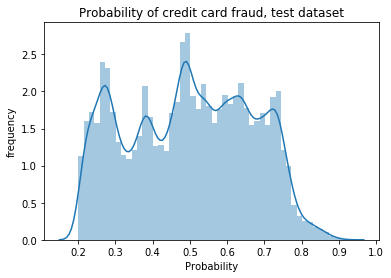

In [106]:
ax = sns.distplot(Y_pred[:,1])
labels = ax.set(xlabel='Probability',ylabel='frequency',title='Probability of credit card fraud, test dataset')

Ideally, 97% of this distribution would be at or under .5. That isn't the case unfortunately, but it definitely skews right, which is good.

### The best Gradient Boosting model:

In [107]:
gbc_best = ensemble.GradientBoostingClassifier(loss='deviance',n_estimators=500)

`cross_val_score(gbc_best,X_pca,Y,cv=10)`

Cross validation scores:
```
array([0.77105897, 0.77393137, 0.77152318, 0.76881397, 0.7718242 ,
   0.78055388, 0.76309452, 0.77363034, 0.77543648, 0.75526791])
```

These cross-validation scores aren't as good as the best random forest's scores.

### Which features did this model find most important? (pre-PCA)

As I understand it, feature_importance_ uses a measure called Gini importance, or mean decrease in impurity. This is a measure of how many times a feature is used to split a node, weighted based on the number of samples it splits.

`feature_importance = pd.DataFrame(zip(df.columns,rfc_best.feature_importances_))`

`feature_importance.sort_values(by=[1],ascending=False)`

I read up a little about the reliability of the feature_importances_ attribute. The authors of [this article](https://explained.ai/rf-importance/) created their own package, with functions to calculate what they call the permutation importance for both regressor models and classifier models. 

In addition to offering a different measure of which features the model considers most important in reaching its predictions, their function returns negative values to indicate where a model may be better off without a given feature. Before I implemented PCA, I tried reviewing the negative values output by permutation_importances to further reduce the feature set and run another iteration of the random forest model.

```
import rfpimp as rf
rfc_pi = pd.DataFrame(rf.permutation_importances(rfc_best,X,Y,rf.oob_classifier_accuracy))
rfc_pi.loc[rfc_pi['Importance'] < 0]
```

## Moving forward with the best-looking model: Let's create a file to submit to Kaggle.

But first--we are holding onto so many dataframes and series. Let's drop them and free up memory.

In [108]:
X_old = X.copy(deep=True)
#X_old_pca = X_pca.copy(deep=True)
Xtrain_old = Xtrain.copy(deep=True)

In [109]:
%who_ls DataFrame

['X',
 'X_old',
 'Xtest',
 'Xtrain',
 'Xtrain_old',
 'df',
 'fraud_df',
 'nonfraud_df',
 'smaller_df']

In [110]:
%who_ls Series

['Y', 'Ytest', 'Ytrain', 'fraud_ccn', 'fraud_pcd', 'trans_ccn', 'trans_pcd']

In [111]:
del X,Xtrain,Xtest,df,fraud_df,nonfraud_df,smaller_df
del Y,Ytest,Ytrain,fraud_ccn,fraud_pcd,trans_ccn,trans_pcd
gc.collect()

5

In [112]:
trans_df = pd.read_csv('ieee-fraud-detection/test_transaction.csv')
id_df = pd.read_csv('ieee-fraud-detection/test_identity.csv')

### Data cleanup--same as we performed with the training set

In [113]:
trans_df['card2'].fillna(trans_df['card2'].median(),inplace=True)
trans_df['card3'].fillna(trans_df['card3'].median(),inplace=True)
trans_df['card4'].fillna('other',inplace=True)
trans_df['card5'].fillna(trans_df['card5'].median(),inplace=True)
trans_df['card6'].fillna('other',inplace=True)

In [114]:
trans_df['card6'] = trans_df['card6'].apply(lambda x: card6_cleanup(x))

In [115]:
trans_df['addr1'].fillna(0,inplace=True)
trans_df['addr2'].fillna(0,inplace=True)

In [116]:
trans_df['dist1'].fillna(0,inplace=True)
trans_df['dist2'].fillna(0,inplace=True)

In [117]:
trans_df.drop('P_emaildomain',axis='columns',inplace=True)
trans_df.drop('R_emaildomain',axis='columns',inplace=True)

In [118]:
# The C columns have a handful of nulls in the Kaggle test set! 
# They represent counts of things, so fillna with 0.
for i in range (1,15):
    range_id = 'C{}'.format(i)
    trans_df[range_id].fillna(0,inplace=True)

In [119]:
for i in range(1,16):
    range_id = 'D{}'.format(i)
    trans_df[range_id].fillna(0,inplace=True)

In [120]:
for i in range(1,10):
    range_id = 'M{}'.format(i)
    if range_id != 'M4':
        trans_df[range_id] = trans_df[range_id].map({'F': 0, 'T': 1})
        trans_df[range_id].fillna(0,inplace=True)
    else:
        trans_df[range_id].fillna(-1,inplace=True)
        trans_df[range_id] = trans_df[range_id].apply(lambda x: int(str(x).strip('M')))

In [121]:
for i in range(1,340):
    range_id = 'V{}'.format(i)
    trans_df[range_id].fillna(trans_df[range_id].median(),inplace=True)

In [122]:
id_df.fillna({'id_23': 'NA'},inplace=True)
id_df['id_23'] = id_df['id_23'].map(lambda x: re.sub(r'IP_PROXY:','',str(x)))

In [123]:
for fnf in ['id_12','id_15','id_16','id_27','id_28','id_29']:
    id_df[fnf] = id_df[fnf].map({'NotFound': 0, 'Found': 1, 'New': 2, 'Unknown': -1})
    id_df[fnf].fillna(0,inplace=True)

In [124]:
id_df.drop(columns=['id_30'],axis='columns',inplace=True)

In [125]:
id_df['id_31'] = id_df['id_31'].apply(lambda x: reduce_browsers(x))

In [126]:
id_df['id_32'].fillna(0.0,inplace=True)

In [127]:
id_df['id_33'].fillna('0x0',inplace=True)

In [128]:
id_df['id_33'] = id_df['id_33'].str.split(pat='x').str[0].apply(lambda x: reduce_resolution(x))

In [129]:
id_df.fillna({'id_34': 3},inplace=True)
id_df['id_34'] = id_df['id_34'].map(lambda x: re.sub(r'match_status:','',str(x))).astype(int)

id_df.drop(['id_34'],axis='columns',inplace=True)

In [130]:
for i in range(35,39):
    range_id = 'id_{}'.format(i)
    id_df[range_id] = id_df[range_id].map({'F': 0, 'T': 1})
    id_df[range_id].fillna(0,inplace=True)

In [131]:
id_df['DeviceInfo'].fillna('NA',inplace=True)

In [132]:
id_df['DeviceInfo'] = id_df['DeviceInfo'].apply(lambda x: reduce_devices(x))

### Merge the transaction and identity dataframes

In [133]:
df = pd.merge(trans_df,id_df,on='TransactionID',how='left')

In [134]:
df.shape

(506691, 430)

__Capture Transaction ID before dropping it from the merged dataframe--it's a required field in the output file for Kaggle.__

In [135]:
trans_id = trans_df['TransactionID'].copy(deep=True)

### Delete the two individual dataframes to reclaim some memory

In [136]:
import gc
del trans_df,id_df
gc.collect()

13

In [137]:
X = df.drop(['TransactionID'],axis='columns')
X = pd.get_dummies(X,drop_first=True)
X = X.dropna(axis='columns')

In [138]:
X.shape

(506691, 421)

### Scale the data, and apply PCA to reduce features.

In [139]:
sclr = StandardScaler()
X_transformed = sclr.fit_transform(X)

Use the existing PCA object for this dataset too!

In [140]:
X_pca = pca.transform(X_transformed)

In [141]:
X_pca.shape

(506691, 143)

In [149]:
pca.explained_variance_ratio_

array([0.12895586, 0.11184527, 0.06306493, 0.03396261, 0.02987238,
       0.02548651, 0.02456606, 0.02341861, 0.02284787, 0.02104973,
       0.01741101, 0.01651446, 0.01541842, 0.01359579, 0.01153611,
       0.01076186, 0.01072318, 0.0097884 , 0.0095321 , 0.00932653,
       0.00893673, 0.00850275, 0.00800656, 0.00761437, 0.00737263,
       0.00708239, 0.00702598, 0.00675809, 0.00645706, 0.00608248,
       0.00579666, 0.00572826, 0.00560908, 0.00542446, 0.00533386,
       0.00506272, 0.00498144, 0.00482444, 0.00476305, 0.00465514,
       0.0045804 , 0.00453319, 0.00445471, 0.00425449, 0.00415425,
       0.00393275, 0.00387966, 0.00381135, 0.00374002, 0.00366544,
       0.00358314, 0.00349515, 0.00342144, 0.00328078, 0.00318408,
       0.00313684, 0.00300608, 0.00298962, 0.0029157 , 0.00285814,
       0.00278238, 0.00273146, 0.00265817, 0.00263839, 0.00260339,
       0.00258874, 0.00255776, 0.00249716, 0.00247798, 0.00245864,
       0.00244751, 0.00240047, 0.00239074, 0.00237809, 0.00235

In [150]:
pca.explained_variance_ratio_.sum()

0.95033634234273

In [151]:
Y_pred = rfc_best.predict_proba(X_pca)

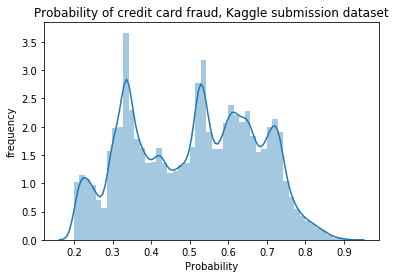

In [152]:
ax = sns.distplot(Y_pred[:,1])
labels = ax.set(xlabel='Probability',ylabel='frequency',
                title='Probability of credit card fraud, Kaggle submission dataset')

## Write the results to disk, for submission to Kaggle!

In [153]:
pd.concat([trans_id,pd.Series(Y_pred[:,1])],
          axis=1,
          ignore_index=True).rename(columns={0: 'TransactionID',1: 'isFraud'}).\
  to_csv('submission.csv',index=False)

# Future work

## Improve the model
* I read about a random forest model that specializes in handling imbalanced data.
* I read about [a Bayesian Optimizer](https://medium.com/vantageai/bringing-back-the-time-spent-on-hyperparameter-tuning-with-bayesian-optimisation-2e21a3198afb) that is supposed to be much faster than GridSearchCV. I could use it to tune parameters for any model.

## Other performance improvements
* Train on a machine with more resources than my laptop--maybe a virtual machine in the cloud (AWS/Azure/Google Cloud).
* Transform the code in this notebook into a Python script that can run without the overhead of the browser and Jupyter Notebooks.
* Breaking up the work may improve resource management.
    * Use pickling to preserve/load the PCA object, and the model, from one notebook or script to another notebook or script.
    * In a production environment, breaking this pipeline into rerunnable components would also help with future support/development efforts. 

## Questions to answer:
```
Transaction data:
How do the fraudulent transactions compare to their "typical" transactions?
	--Amount
	--Possibly location of transaction (do billing and shipping addresses, or P_ and R_emails, differ?)
	--Do we have a category for purchases? (ie, groceries, entertainment, car maintenance)

Create a feature indicating a foreign transaction, for TransactionAmt with > 2 decimal places?

If card1 represents the card limit, is there a "class" of card that is compromised more often?

Is there a particular network/card type that experiences fraud more?

How do those distN features figure into fraudulent charges? Any correlation there?

How do the Cn counts look for fraudulent transactions? Higher than normal?

Same for the Dn counts--are these values lower for fraudulent transactions (representing shorter periods of time between usages of an email/address/etc.)?

Is there any correlation between fraudulent transactions and the Mn variables?


Identity data:
Which customers were most often at risk? 
Is there anything we know about their shopping history that made them a bigger target?
	--Their economic background/salary N/A
	--Their physical location          N/A
	--How frequently they shop online  N/A

I see DeviceType and DeviceInfo among the identity variables. Is there a particular platform that could indicate fraud? (Windows, Linux, mobile?)

```

### ***Transformations:***
```
Is any of this necessary?
  Encode any T/F columns --> 1/0 
  Similarly encode Found/NotFound --> 1/0

Drop the Vnnn variables? This would drastically reduce the number of variables.
Maybe you'd be able to process the entire training set.

```

# START HERE. What columns are different between your training and "production" sets? What further cleanup can you perform to bring them in line?

In [142]:
set(X_old).symmetric_difference(set(X))

set()

In [143]:
for colname in X_old.columns:
    if colname.startswith('id'):
        print(colname)

id_23_HIDDEN
id_23_NA
id_23_TRANSPARENT
id_31_Firefox
id_31_Internet Explorer 11.0
id_31_Microsoft Edge
id_31_Opera
id_31_Other
id_31_Safari
id_31_Samsung Browser


In [144]:
for colname in X.columns:
    if colname.startswith('id'):
        print(colname)

id_23_HIDDEN
id_23_NA
id_23_TRANSPARENT
id_31_Firefox
id_31_Internet Explorer 11.0
id_31_Microsoft Edge
id_31_Opera
id_31_Other
id_31_Safari
id_31_Samsung Browser


In [145]:
df.shape

(506691, 430)

In [146]:
df.loc[df['C1'].isnull()]

Empty DataFrame
Columns: [TransactionID, TransactionDT, TransactionAmt, ProductCD, card1, card2, card3, card4, card5, card6, addr1, addr2, dist1, dist2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, M1, M2, M3, M4, M5, M6, M7, M8, M9, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, V29, V30, V31, V32, V33, V34, V35, V36, V37, V38, V39, V40, V41, V42, V43, V44, V45, V46, V47, V48, ...]
Index: []

[0 rows x 430 columns]

*** C1
count    506691.000000
mean         10.093151
std          79.334551
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2950.000000
Name: C1, dtype: float64


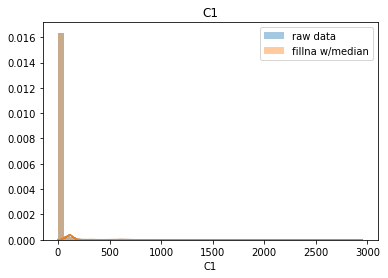

*** C2
count    506691.000000
mean         10.714572
std          88.896661
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        3275.000000
Name: C2, dtype: float64


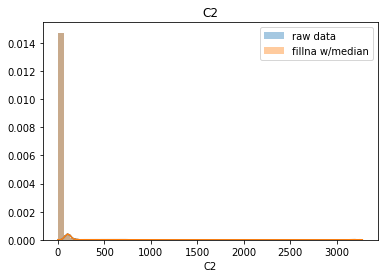

*** C3
count    506691.000000
mean          0.027403
std           0.227752
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          31.000000
Name: C3, dtype: float64


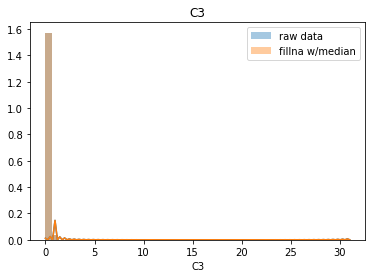

*** C4
count    506691.000000
mean          2.385860
std          41.942853
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        1601.000000
Name: C4, dtype: float64


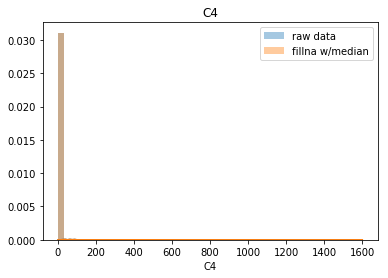

*** C5
count    506691.000000
mean          4.962672
std          25.462123
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         376.000000
Name: C5, dtype: float64


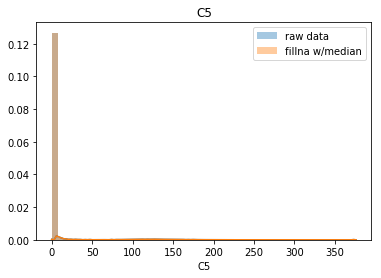

*** C6
count    506691.000000
mean          6.854951
std          46.783429
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max        1601.000000
Name: C6, dtype: float64


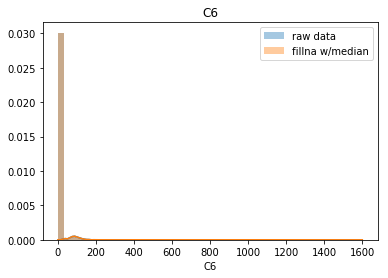

*** C7
count    506691.000000
mean          1.678163
std          37.874715
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1621.000000
Name: C7, dtype: float64


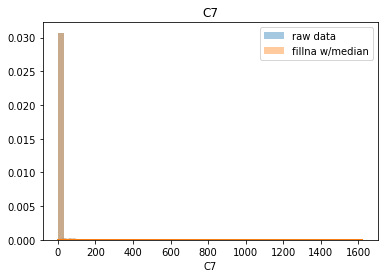

*** C8
count    506691.000000
mean          1.893983
std          26.766036
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        1005.000000
Name: C8, dtype: float64


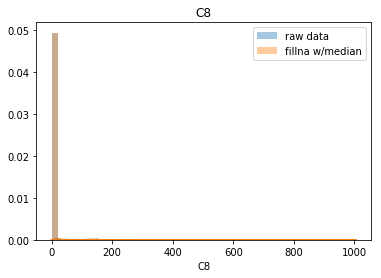

*** C9
count    506691.000000
mean          4.611915
std          21.282580
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max         572.000000
Name: C9, dtype: float64


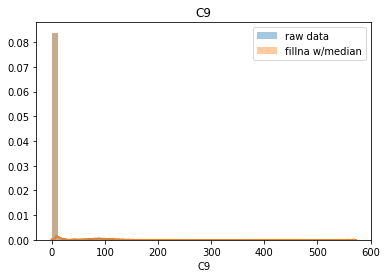

[]

In [147]:
# Peek at the addr columns. Data appears continuous but its purpose is more categorical (billing ZIP and country)
examine_group(df,'C',1,9,showfill=True)

*** V95
count    506691.000000
mean          0.231695
std           0.859311
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          60.000000
Name: V95, dtype: float64


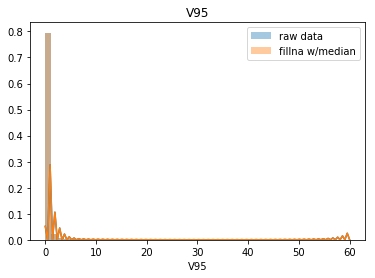

*** V96
count    506691.000000
mean          1.376553
std           3.806585
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         103.000000
Name: V96, dtype: float64


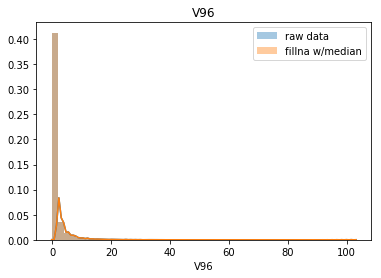

*** V97
count    506691.000000
mean          0.531728
std           1.687563
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          82.000000
Name: V97, dtype: float64


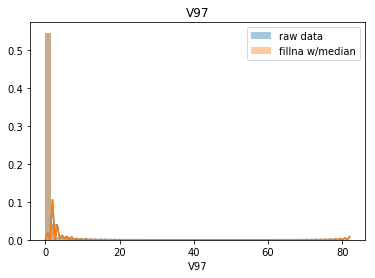

*** V98
count    506691.000000
mean          0.057532
std           0.272315
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           8.000000
Name: V98, dtype: float64


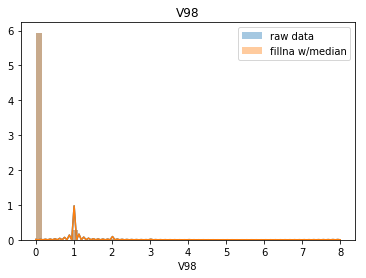

*** V99
count    506691.000000
mean          0.939983
std           2.425097
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          62.000000
Name: V99, dtype: float64


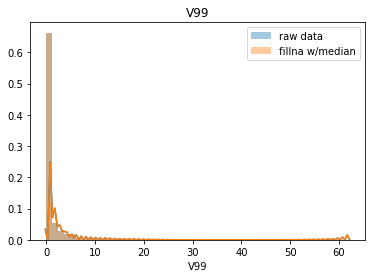

*** V100
count    506691.000000
mean          0.270194
std           0.834316
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          30.000000
Name: V100, dtype: float64


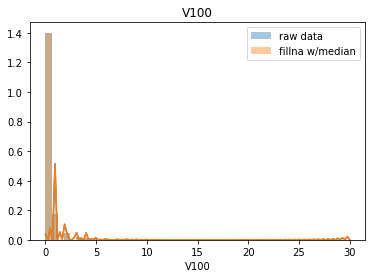

*** V101
count    506691.000000
mean          0.091320
std           0.516291
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          18.000000
Name: V101, dtype: float64


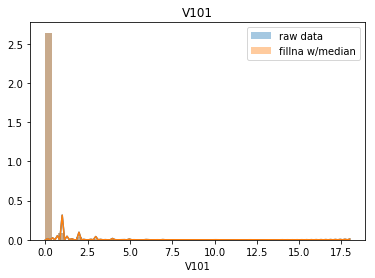

*** V102
count    506691.000000
mean          0.246503
std           1.639347
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          68.000000
Name: V102, dtype: float64


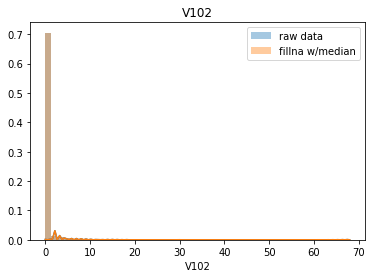

*** V103
count    506691.000000
mean          0.145142
std           0.846263
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: V103, dtype: float64


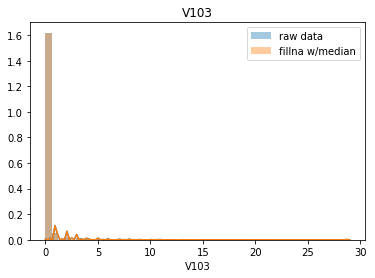

*** V104
count    506691.000000
mean          0.081497
std           0.557815
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          59.000000
Name: V104, dtype: float64


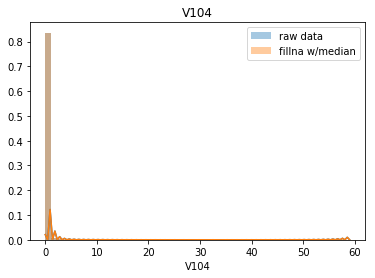

*** V105
count    506691.000000
mean          0.188436
std           1.493119
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          99.000000
Name: V105, dtype: float64


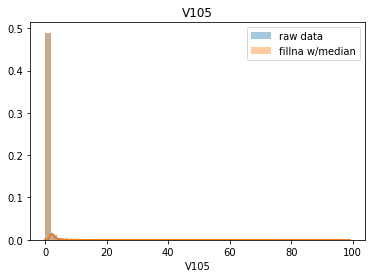

*** V106
count    506691.000000
mean          0.114971
std           0.878800
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          80.000000
Name: V106, dtype: float64


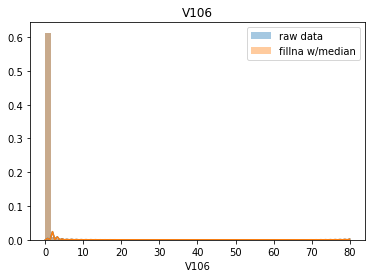

*** V107
count    506691.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: V107, dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


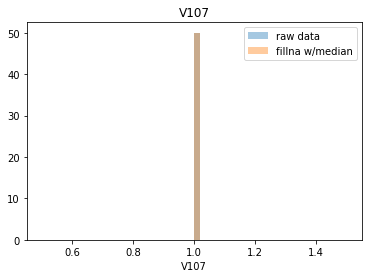

*** V108
count    506691.000000
mean          1.006973
std           0.093677
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V108, dtype: float64


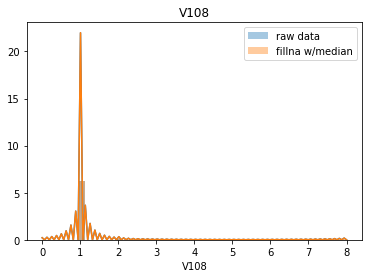

*** V109
count    506691.000000
mean          1.020756
std           0.151220
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V109, dtype: float64


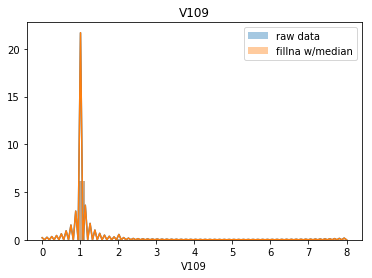

*** V110
count    506691.000000
mean          1.010740
std           0.112401
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V110, dtype: float64


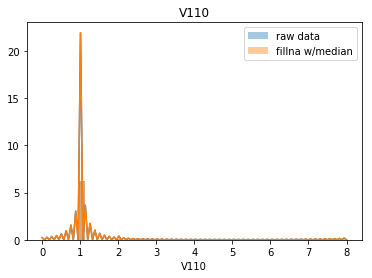

*** V111
count    506691.000000
mean          1.004188
std           0.077498
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V111, dtype: float64


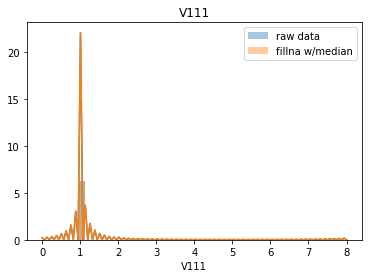

*** V112
count    506691.000000
mean          1.007865
std           0.098856
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V112, dtype: float64


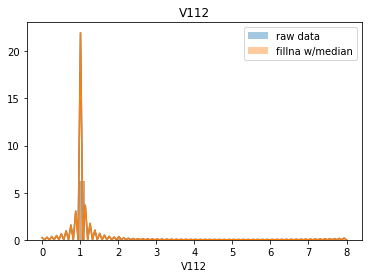

*** V113
count    506691.000000
mean          1.005202
std           0.084060
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           8.000000
Name: V113, dtype: float64


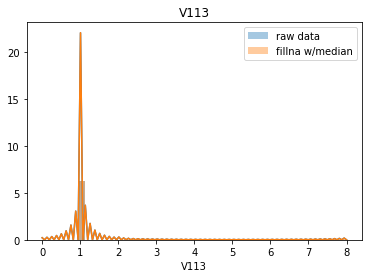

*** V114
count    506691.000000
mean          1.013608
std           0.132229
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V114, dtype: float64


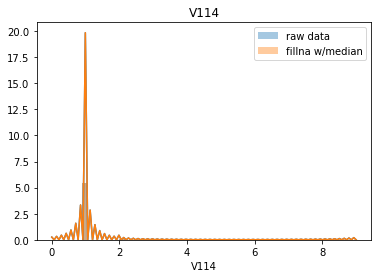

*** V115
count    506691.000000
mean          1.043129
std           0.223200
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V115, dtype: float64


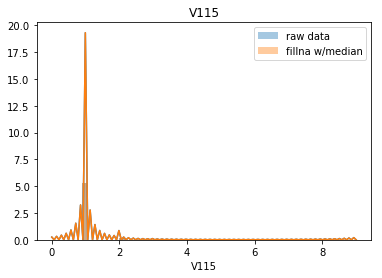

*** V116
count    506691.000000
mean          1.021445
std           0.161190
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           9.000000
Name: V116, dtype: float64


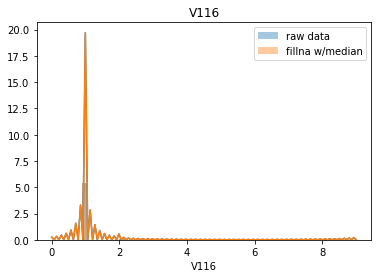

*** V117
count    506691.000000
mean          1.000943
std           0.030892
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: V117, dtype: float64


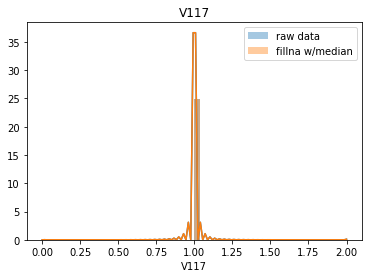

*** V118
count    506691.000000
mean          1.002297
std           0.048121
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: V118, dtype: float64


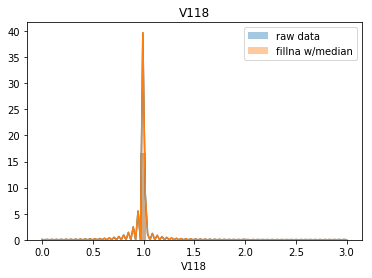

*** V119
count    506691.000000
mean          1.001449
std           0.038188
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           2.000000
Name: V119, dtype: float64


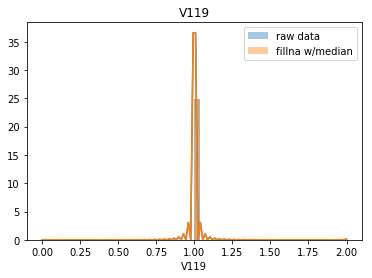

*** V120
count    506691.000000
mean          1.001796
std           0.043536
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: V120, dtype: float64


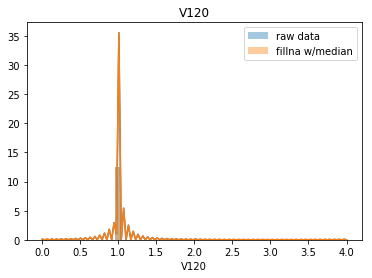

*** V121
count    506691.000000
mean          1.006442
std           0.082192
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: V121, dtype: float64


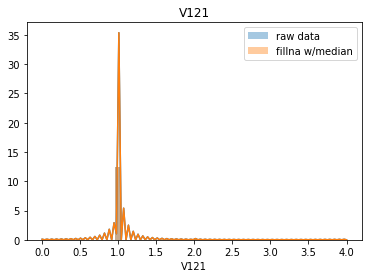

*** V122
count    506691.000000
mean          1.002992
std           0.056395
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: V122, dtype: float64


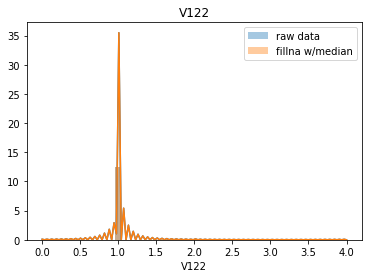

*** V123
count    506691.000000
mean          1.037607
std           0.251355
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          12.000000
Name: V123, dtype: float64


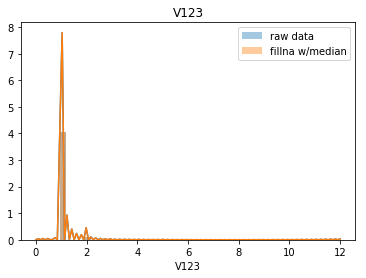

*** V124
count    506691.000000
mean          1.106114
std           0.407922
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          13.000000
Name: V124, dtype: float64


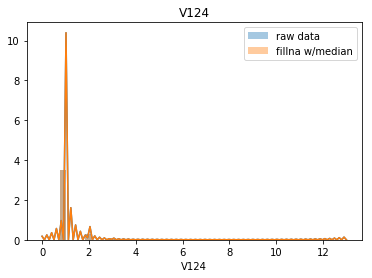

*** V125
count    506691.000000
mean          1.056028
std           0.303396
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          12.000000
Name: V125, dtype: float64


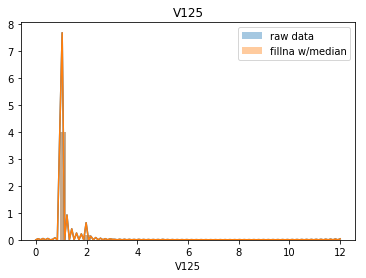

*** V126
count    506691.000000
mean         65.612052
std        2180.122508
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      519038.500000
Name: V126, dtype: float64


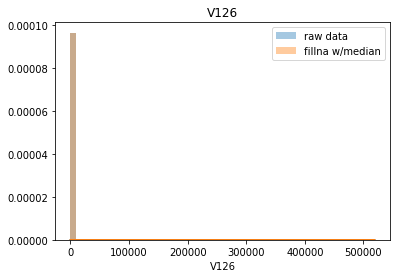

*** V127
count    506691.000000
mean        205.845487
std        2545.692423
min           0.000000
25%           0.000000
50%           0.000000
75%         115.900002
max      544500.000000
Name: V127, dtype: float64


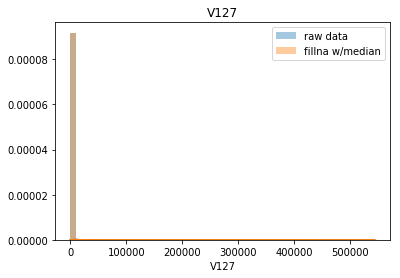

*** V128
count    506691.000000
mean        106.361069
std        2282.943655
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      519038.500000
Name: V128, dtype: float64


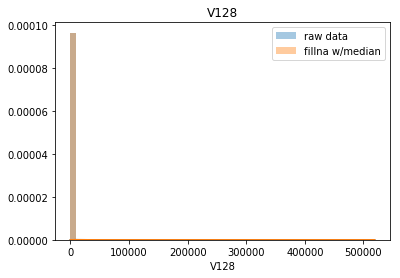

*** V129
count    506691.000000
mean         10.658756
std         337.299989
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       64800.000000
Name: V129, dtype: float64


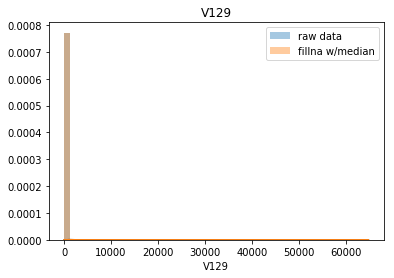

*** V130
count    506691.000000
mean        107.366682
std         583.515717
min           0.000000
25%           0.000000
50%           0.000000
75%          65.145901
max      167200.000000
Name: V130, dtype: float64


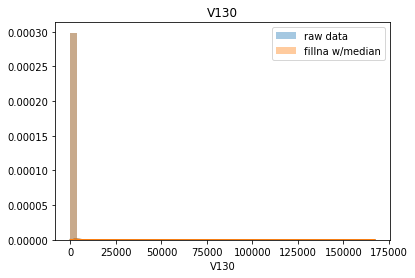

*** V131
count    506691.000000
mean         35.442398
std         464.100478
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      167200.000000
Name: V131, dtype: float64


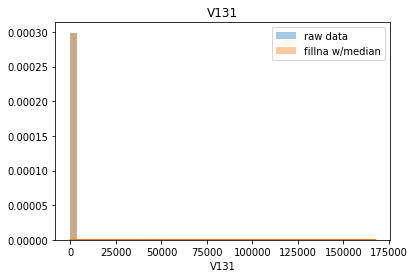

*** V132
count    506691.000000
mean         30.273769
std        1863.563032
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      519038.500000
Name: V132, dtype: float64


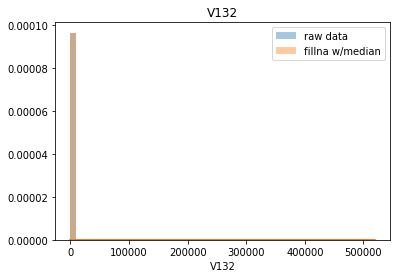

*** V133
count    506691.000000
mean         56.926002
std        2063.254734
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      519038.500000
Name: V133, dtype: float64


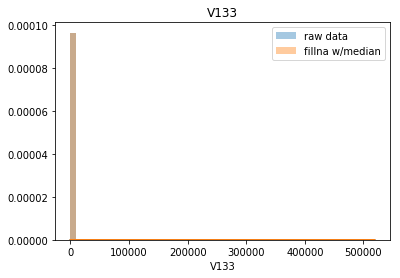

*** V134
count    506691.000000
mean         39.334035
std        1876.708561
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      519038.500000
Name: V134, dtype: float64


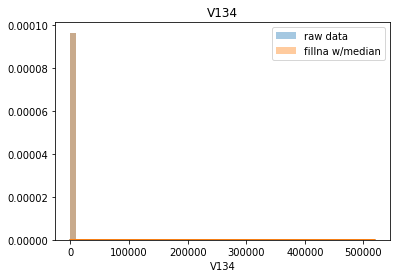

*** V135
count    506691.000000
mean         24.233004
std         661.652798
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      302500.000000
Name: V135, dtype: float64


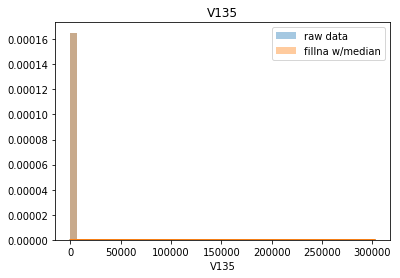

*** V136
count    506691.000000
mean         41.052809
std         833.083599
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      302500.000000
Name: V136, dtype: float64


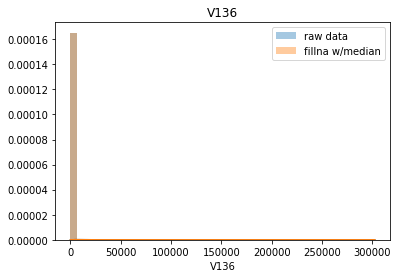

*** V137
count    506691.000000
mean         31.126621
std         804.012468
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      302500.000000
Name: V137, dtype: float64


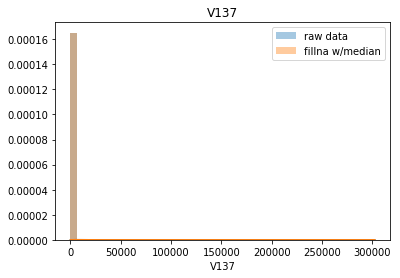

[]

In [148]:
examine_group(X,'V',95,137,showfill=True)

Just a quick look at how the components look--how much variance each of them explains. Together, they should explain about 95% of the variance of the data.

# ------------------------------------------------------ end of temp analysis